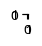

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

In [11]:
from joblib import Parallel, delayed
from functools import partial
MAXLENS={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}
def split_seq(seq, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    rec_seq = []
    i=0
    for name,length in max_lens.items():
        if length==0:
            continue
        rec_seq.append(seq[i:i+length].rstrip('X'))
        i+=length
    return rec_seq

def get_all_split(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df=df.copy()
    df.drop(columns=[x for x in df.columns if x.startswith('z_')], inplace=True)
    df[list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['true_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    df[list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['hat_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    return df
    
def get_cdr_acc(true, rec):
    if len(true)==len(rec):
        return np.mean([x==y for x,y in zip(true,rec)])
    elif len(true)>len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(true)-len(rec))*'X')])
    elif len(true)<len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(rec)-len(true))*'X')])
    else:
        return 0
      

In [12]:
def glob_path(path, pattern):
    pt = glob.glob(f'{path}*{pattern}*.pt')[0]
    js = glob.glob(f'{path}*JSON_kwargs*.json')[0]
    return pt, js

  
def get_per_seq_acc(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df = df.copy()
    df = get_all_split(df, max_lens)
    true_cols=list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)
    rec_cols=list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)
    for true, rec in zip(true_cols, rec_cols):
        chain = true.rstrip('_true_rec')
        df[f'acc_{chain}'] =  df.apply(lambda x: get_cdr_acc(x[true], x[rec]), axis=1)
    return df

In [14]:
os_notrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/'
os_cstrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/'
ts_notrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC/'
ts_cstrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd/'
os_notrp = load_model_full(*glob_path(os_notrp_path, 'best'))
ts_notrp = load_model_full(*glob_path(ts_notrp_path, '4500'))
os_cstrp = load_model_full(*glob_path(os_cstrp_path, 'best'))
ts_cstrp = load_model_full(*glob_path(ts_cstrp_path, '4500'))

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19904
total: 0.3804485993018143
reconstruction: 0.3688316931078958
kld: 0.011616906193918503
triplet: 0.0
seq_accuracy: 0.9929980039596558
pos_accuracy: 0.9998289346694946
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
epoch: 4500
total: 0.7775099739190969
reconstruction: 0.24511546373418122
kld: 0.0
triplet: 0.0
BCE: 0.5323945055735589
seq_accuracy: 0.9910694360733032
pos_accuracy: 0.9997903108596802
auc: 0.7436
auc_01: 0.59057
auc_01_real: 0.22208
precision: 0.39935
recall: 0.43906
accuracy: 0.79582
AP: 0.35665
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19934
total: 0.07886607476881971
reconstruction: 0.05939108139774983
kld: 0.003005831211369365
triplet: 0.01646916461991662
seq_accuracy: 

# Get patient reconstruction accuracies

In [13]:
garner = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv')
francis = pd.concat([pd.read_csv(x) for x in glob.glob(f'../data/OTS/francis_covid_042/*')])

In [19]:
garner_os_notrp = get_latent_df(os_notrp, garner)
francis_os_notrp = get_latent_df(os_notrp, francis)
garner_ts_notrp = get_latent_df(ts_notrp, garner)
francis_ts_notrp = get_latent_df(ts_notrp, francis)
garner_os_cstrp = get_latent_df(os_cstrp, garner)
francis_os_cstrp = get_latent_df(os_cstrp, francis)
garner_ts_cstrp = get_latent_df(ts_cstrp, garner)
francis_ts_cstrp = get_latent_df(ts_cstrp, francis)

In [28]:
garner_os_notrp = garner_os_notrp.drop(columns=[x for x in garner_os_notrp.columns if x.startswith('z_')])
francis_os_notrp = francis_os_notrp.drop(columns=[x for x in francis_os_notrp.columns if x.startswith('z_')])
garner_ts_notrp = garner_ts_notrp.drop(columns=[x for x in garner_ts_notrp.columns if x.startswith('z_')])
francis_ts_notrp = francis_ts_notrp.drop(columns=[x for x in francis_ts_notrp.columns if x.startswith('z_')])
garner_os_cstrp = garner_os_cstrp.drop(columns=[x for x in garner_os_cstrp.columns if x.startswith('z_')])
francis_os_cstrp = francis_os_cstrp.drop(columns=[x for x in francis_os_cstrp.columns if x.startswith('z_')])
garner_ts_cstrp = garner_ts_cstrp.drop(columns=[x for x in garner_ts_cstrp.columns if x.startswith('z_')])
francis_ts_cstrp = francis_ts_cstrp.drop(columns=[x for x in francis_ts_cstrp.columns if x.startswith('z_')])

In [38]:
from src.utils import flatten_level_columns
COLS= ['partition', 'peptide', 'A1','A2','A3','B1','B2','B3', 
       'A1_hat_rec','A2_hat_rec','A3_hat_rec', 'B1_hat_rec', 'B2_hat_rec', 'B3_hat_rec', 
       'acc_A1', 'acc_A2', 'acc_A3', 'acc_B1', 'acc_B2', 'acc_B3', 'seq_acc']
garner_total = pd.concat([get_per_seq_acc(garner_os_notrp).assign(Dataset='garner', Model='os_notrp'), 
                          get_per_seq_acc(garner_ts_notrp).assign(Dataset='garner', Model='ts_notrp'), 
                          get_per_seq_acc(garner_os_cstrp).assign(Dataset='garner', Model='os_cstrp'), 
                          get_per_seq_acc(garner_ts_cstrp).assign(Dataset='garner', Model='ts_cstrp')])
francis_total = pd.concat([get_per_seq_acc(francis_os_notrp).assign(Dataset='francis', Model='os_notrp'), 
                           get_per_seq_acc(francis_ts_notrp).assign(Dataset='francis', Model='ts_notrp'), 
                           get_per_seq_acc(francis_os_cstrp).assign(Dataset='francis', Model='os_cstrp'), 
                           get_per_seq_acc(francis_ts_cstrp).assign(Dataset='francis', Model='ts_cstrp')])
total = pd.concat([garner_total, francis_total])[[x for x in COLS if x in garner_total.columns]+['Model','Dataset']]
del garner_total, francis_total
total_gb = total.groupby(['Model', 'Dataset'])[[x for x in total.columns if "acc" in x]].describe()
drop_cols = [x for x in total_gb.describe().columns if x[1] in ['count', '25%', '50%', '75%']]
total_gb = flatten_level_columns(total_gb.drop(columns=drop_cols))
total_gb = total_gb.round(5).T
total_gb

Model        os_cstrp          os_notrp          ts_cstrp          ts_notrp  \
Dataset       francis   garner  francis   garner  francis   garner  francis   
acc_a1_mean   0.99291  0.99832  0.97843  0.99527  0.98059  0.99527  0.96497   
acc_a1_std    0.04120  0.02166  0.07368  0.03556  0.06652  0.03520  0.12037   
acc_a1_min    0.16667  0.16667  0.33333  0.33333  0.28571  0.16667  0.33333   
acc_a1_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_a2_mean   0.98287  0.99328  0.98435  0.99306  0.98302  0.99365  0.97986   
acc_a2_std    0.06064  0.03919  0.05169  0.03942  0.05880  0.03674  0.06645   
acc_a2_min    0.00000  0.00000  0.00000  0.16667  0.00000  0.00000  0.14286   
acc_a2_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_a3_mean   0.98768  0.99548  0.98949  0.99567  0.98496  0.99465  0.98249   
acc_a3_std    0.03957  0.02374  0.04028  0.02412  0.04125  0.02508  0.04985   
acc_a3_min    0.47368  0.66667  0.50000  0.63158  0.50000  0.64706  0.40000   
acc_a3_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_b1_mean   0.99819  0.99670  0.99935  0.99775  0.99815  0.99746  0.99933   
acc_b1_std    0.02291  0.02830  0.01237  0.02646  0.02928  0.02851  0.01322   
acc_b1_min    0.60000  0.40000  0.60000  0.40000  0.40000  0.20000  0.40000   
acc_b1_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_b2_mean   0.99816  0.99805  0.99891  0.99770  0.99720  0.99727  0.99896   
acc_b2_std    0.02354  0.02332  0.01777  0.02830  0.02370  0.02743  0.01674   
acc_b2_min    0.16667  0.25000  0.16667  0.00000  0.33333  0.16667  0.33333   
acc_b2_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_b3_mean   0.99225  0.99520  0.98950  0.99323  0.99289  0.99479  0.98397   
acc_b3_std    0.03675  0.02737  0.04456  0.03445  0.03343  0.02742  0.05103   
acc_b3_min    0.38095  0.42857  0.40000  0.38095  0.47619  0.47619  0.25000   
acc_b3_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
seq_acc_mean  0.99094  0.99574  0.98898  0.99477  0.98887  0.99508  0.98345   
seq_acc_std   0.02134  0.01450  0.02426  0.01702  0.02456  0.01601  0.03183   
seq_acc_min   0.70000  0.75439  0.73016  0.75926  0.72000  0.79630  0.71429   
seq_acc_max   1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   

Model                  
Dataset        garner  
acc_a1_mean   0.99224  
acc_a1_std    0.05875  
acc_a1_min    0.33333  
acc_a1_max    1.00000  
acc_a2_mean   0.99172  
acc_a2_std    0.04551  
acc_a2_min    0.25000  
acc_a2_max    1.00000  
acc_a3_mean   0.99277  
acc_a3_std    0.03107  
acc_a3_min    0.47059  
acc_a3_max    1.00000  
acc_b1_mean   0.99686  
acc_b1_std    0.02887  
acc_b1_min    0.40000  
acc_b1_max    1.00000  
acc_b2_mean   0.99823  
acc_b2_std    0.02499  
acc_b2_min    0.00000  
acc_b2_max    1.00000  
acc_b3_mean   0.98952  
acc_b3_std    0.04000  
acc_b3_min    0.40000  
acc_b3_max    1.00000  
seq_acc_mean  0.99248  
seq_acc_std   0.02075  
seq_acc_min   0.75472  
seq_acc_max   1.00000

In [39]:
total_gb.to_csv('../../../writing/VAE_TCR_DRAFT/tables/240919_patient_reconstruction_accuracies.csv')

# Get Kmeansret-pur graph

## inits

In [2]:
from sklearn.neighbors import KNeighborsClassifier
# dataset = pd.read_csv(X)~
# def knn_retpur(

In [45]:
data=pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_26peps_labeled.csv')
data.set_index('q_index', inplace=True)

In [56]:
from sklearn.preprocessing import LabelEncoder
sample = data.sample(100, random_state=1)
sample = sample[[str(x) for x in sample.index]+['binder','peptide','original_index']]
sample_array = sample.iloc[:len(sample), :len(sample)]
labels = sample['peptide'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
knn = KNeighborsClassifier(5, metric='precomputed', n_jobs=-1)
knn.fit(sample_array, encoded_labels)

KNeighborsClassifier(metric='precomputed', n_jobs=-1)

In [3]:
# KMeans
from sklearn.cluster import KMeans
easy5peps = ['GILGFVFTL', 'ELAGIGILTV', 'RAKFKQLL', 'YLQPRTFLL', 'CINGVCWTV'] 
sample = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv').query('partition==0 and peptide in @easy5peps').sample(frac=0.5)
latent = get_latent_df(os_cstrp, sample)
features = latent[[z for z in latent.columns if z.startswith('z_')]].values
labels = latent['peptide'].values
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(labels)
km = KMeans(n_clusters=len(sample)-1)
km.fit(features)
predicted_labels = km.predict(features)

NameError: name 'os_cstrp' is not defined

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
def get_purity_mixity(cluster_label: int,
                                true_labels: list,
                                pred_labels: list,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_,
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels == cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size <= 1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity': np.nan, 'cluster_size': 1}

    # Query the subset of the true labels belonging to this cluster using indices
    # Convert to int label encodings in order to use np.bincount to get purity and mixity

    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i: k for i, k in enumerate(np.bincount(encoded_subset)) if k > 0}
    majority_label = label_encoder.inverse_transform([sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]])[
        0]
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)

    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity': purity, 'cluster_size': cluster_size, 'majority_label': majority_label}



def get_kmeans_metrics(t, features, c, true_labels, encoded_labels, label_encoder, return_df=False):
    n_cluster = np.sum((np.bincount(c.labels_) > 1))
    n_singletons = (np.bincount(c.labels_) == 1).sum()
    try:
        s_score = silhouette_score(features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    df_out = pd.concat(
        [pd.DataFrame(get_purity_mixity(label_i, true_labels, c.labels_, label_encoder), index=[0])
         for label_i in set(c.labels_)]).reset_index(drop=True).reset_index().rename(columns={'index': 'pred_label'})
    nc_07 = len(df_out.query('purity>=0.7'))
    if return_df:
        return {'threshold': t,
                'n_cluster': n_cluster, 'n_singletons': n_singletons,
                'n_cluster_over_70p': nc_07,
                'mean_purity': df_out['purity'].mean(),
                'min_purity': df_out['purity'].min(),
                'max_purity': df_out['purity'].max(),
                'mean_cluster_size': df_out['cluster_size'].mean(),
                'min_cluster_size': df_out['cluster_size'].min(),
                'max_cluster_size': df_out['cluster_size'].max(),
                'silhouette': s_score,
                'ch_index': c_score, 'db_index': d_score, 'ARI': ari_score}, df_out
    else:
        return {'threshold': t,
                'n_cluster': n_cluster, 'n_singletons': n_singletons,
                'n_cluster_over_70p': nc_07,
                'mean_purity': df_out['purity'].mean(),
                'min_purity': df_out['purity'].min(),
                'max_purity': df_out['purity'].max(),
                'mean_cluster_size': df_out['cluster_size'].mean(),
                'min_cluster_size': df_out['cluster_size'].min(),
                'max_cluster_size': df_out['cluster_size'].max(),
                'silhouette': s_score,
                'ch_index': c_score, 'db_index': d_score, 'ARI': ari_score}
        

In [7]:
def kmeans_all_thresholds(features, labels, encoded_labels, label_encoder, n_jobs=1):
    # Getting clustering at all thresholds, from 2 clusters to every clusters being duplets
    limits = np.arange(2, len(features))
    if n_jobs > 1:
        wrapper = partial(kmeans_single_threshold, features=features, labels=labels,
                          encoded_labels=encoded_labels, label_encoder=label_encoder)
        results = Parallel(n_jobs=n_jobs)(delayed(wrapper)(k=k) for k in tqdm(limits))
    else:
        results = []
        for t in tqdm(limits):
            results.append(kmeans_single_threshold(features, labels, encoded_labels, label_encoder, t))
    results = pd.DataFrame(results).sort_values('threshold')
    results['retention'] = (len(labels) - results['n_singletons']) / len(labels)
    return results

def kmeans_single_threshold(features, labels, encoded_labels, label_encoder, k,
                             return_df_and_c=False):
    if k>= len(features)//2:
        max_iter=75
    c = KMeans(n_clusters=k, max_iter=max_iter)
    c.fit(features)
    if return_df_and_c:
        return *get_kmeans_metrics(threshold, features, c, labels, encoded_labels, label_encoder,
                                return_df=return_df_and_c), c
    else:
        return get_kmeans_metrics(k, features, c, labels, encoded_labels, label_encoder)

# kmeans_single_threshold(features, labels, encoded_labels, label_encoder, k=200)

In [8]:
def get_purity_mixity(cluster_label: int,
                                true_labels: list,
                                pred_labels: list,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_,
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels == cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size <= 1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity': np.nan, 'coherence': np.nan, 'cluster_size': 1}

    # Query the subset of the true labels belonging to this cluster using indices
    # Convert to int label encodings in order to use np.bincount to get purity and mixity

    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i: k for i, k in enumerate(np.bincount(encoded_subset)) if k > 0}
    majority_label = label_encoder.inverse_transform([sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]])[
        0]
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)

    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity': purity, 'cluster_size': cluster_size, 'majority_label': majority_label}

In [254]:
out = kmeans_all_thresholds(features, labels, encoded_labels, label_encoder, n_jobs=8)

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

In [263]:
pd.read_csv('../output/240618_NestedKCV_CNNVAE/clustering/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_ExpData17peps_KFold_v0_t1_240620_1257_ER8wJ/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_ExpData17peps_KFold_v0_t1_240620_1257_ER8wJ_test_results.csv')


Unnamed: 0  threshold  n_cluster  n_singletons  n_cluster_over_70p  \
0              0    0.00557          0          1470                   0   
1              1    0.00623          1          1468                   1   
2              2    0.00689          1          1468                   1   
3              3    0.00755          1          1468                   1   
4              4    0.00821          1          1468                   1   
...          ...        ...        ...           ...                 ...   
9995         495    0.62987          2             0                   0   
9996         496    0.63113          2             0                   0   
9997         497    0.63238          2             0                   0   
9998         498    0.63364          2             0                   0   
9999         499    0.63490          1             0                   0   

      mean_purity  min_purity  max_purity  mean_coherence  min_coherence  \
0             NaN         NaN         NaN             NaN            NaN   
1        1.000000    1.000000    1.000000        0.005576       0.005576   
2        1.000000    1.000000    1.000000        0.005576       0.005576   
3        1.000000    1.000000    1.000000        0.005576       0.005576   
4        1.000000    1.000000    1.000000        0.005576       0.005576   
...           ...         ...         ...             ...            ...   
9995     0.197482    0.159670    0.235294        0.359444       0.332498   
9996     0.197482    0.159670    0.235294        0.359444       0.332498   
9997     0.197482    0.159670    0.235294        0.359444       0.332498   
9998     0.197482    0.159670    0.235294        0.359444       0.332498   
9999     0.158503    0.158503    0.158503        0.387666       0.387666   

      max_coherence  mean_cluster_size  min_cluster_size  max_cluster_size  \
0               NaN                NaN               NaN               NaN   
1          0.005576                2.0               2.0               2.0   
2          0.005576                2.0               2.0               2.0   
3          0.005576                2.0               2.0               2.0   
4          0.005576                2.0               2.0               2.0   
...             ...                ...               ...               ...   
9995       0.386389              735.0              17.0            1453.0   
9996       0.386389              735.0              17.0            1453.0   
9997       0.386389              735.0              17.0            1453.0   
9998       0.386389              735.0              17.0            1453.0   
9999       0.387666             1470.0            1470.0            1470.0   

      silhouette  ch_index   db_index      ARI  retention       input_type  
0            NaN       NaN        NaN  0.00000   0.000000        TBCRalign  
1            0.0  0.508803  10.448633  0.00002   0.001361        TBCRalign  
2            0.0  0.508803  10.448633  0.00002   0.001361        TBCRalign  
3            0.0  0.508803  10.448633  0.00002   0.001361        TBCRalign  
4            0.0  0.508803  10.448633  0.00002   0.001361        TBCRalign  
...          ...       ...        ...      ...        ...              ...  
9995         0.0  0.007104  84.499144      NaN   1.000000  agg_epoch_12000  
9996         0.0  0.007104  84.499144      NaN   1.000000  agg_epoch_12000  
9997         0.0  0.007104  84.499144      NaN   1.000000  agg_epoch_12000  
9998         0.0  0.007104  84.499144      NaN   1.000000  agg_epoch_12000  
9999         NaN       NaN        NaN      NaN   1.000000  agg_epoch_12000  

[10000 rows x 20 columns]

## ExpData Top17

In [17]:
def kmeans_pipeline(model, df, model_name, dataset_name, partition, n_jobs=10):
    latent = get_latent_df(model, df)
    features = latent[[z for z in latent.columns if z.startswith('z_')]]
    labels = latent['peptide'].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    out = kmeans_all_thresholds(features, labels, encoded_labels, label_encoder, n_jobs)
    out['input_type']=model_name
    out['dataset']=dataset_name
    out['partition'] = partition
    return out

In [18]:
top17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')

df = top17.copy()
train = df.query('partition!=0 and partition!=1')
valid = df.query('partition==0')
test = df.query('partition==1')

results = []
for model, name in zip([os_notrp, ts_notrp, os_cstrp, ts_cstrp], ['os_notrp', 'ts_notrp', 'os_cstrp', 'ts_cstrp']):
    # results.append(kmeans_pipeline(model, train, name, 'top17', 'train'))
    results.append(kmeans_pipeline(model, test, name, 'top17', 'test'))
    results.append(kmeans_pipeline(model, valid, name, 'top17', 'valid'))
    break

  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

## ExpData Top78

In [267]:
top78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
df = top78.copy()
train = df.query('partition!=0 and partition!=1')
valid = df.query('partition==0')
test = df.query('partition==1')

for model, name in zip([os_notrp, ts_notrp, os_cstrp, ts_cstrp], ['os_notrp', 'ts_notrp', 'os_cstrp', 'ts_cstrp']):
    results.append(kmeans_pipeline(model, train, name, 'top17', 'train'))
    results.append(kmeans_pipeline(model, test, name, 'top17', 'test'))
    results.append(kmeans_pipeline(model, valid, name, 'top17', 'valid'))

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

## results

In [19]:
kmeans_results = pd.concat(results)
# kmeans_results.to_csv('../output/240618_NestedKCV_CNNVAE/clustering/kmeans_results_4vaes.csv')

In [20]:
kmeans_results['clustering'] = 'KMeans'

In [21]:
model_names = ['os_notrp', 'ts_cstrp', 'os_cstrp', 'ts_notrp']
ntr = ['checkpoint_best', 'epoch_4500', 'checkpoint_best', 'epoch_4500']
test_files = [x for x in glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*17p*/*test*.csv') if '6omni' in x or 'jyGpd' in x or 'N1jMC' in x or 'ER8wJ' in x]
valid_files = [x for x in glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*17p*/*valid*.csv') if '6omni' in x or 'jyGpd' in x or 'N1jMC' in x or 'ER8wJ' in x]
train_files = [x for x in glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*17p*/*train*.csv') if '6omni' in x or 'jyGpd' in x or 'N1jMC' in x or 'ER8wJ' in x]
train_res = pd.concat([pd.read_csv(x).query('input_type==@z').assign(input_type=m) for x,m,z in zip(train_files, model_names, ntr)]).assign(db='top17', partition='train', clustering='Agglo')
valid_res = pd.concat([pd.read_csv(x).query('input_type==@z').assign(input_type=m) for x,m,z in zip(valid_files, model_names, ntr)]).assign(db='top17', partition='valid', clustering='Agglo')
test_res = pd.concat([pd.read_csv(x).query('input_type==@z').assign(input_type=m) for x,m,z in zip(test_files, model_names, ntr)]).assign(db='top17', partition='test', clustering='Agglo')

train_baseline = pd.read_csv(train_files[0]).query('not input_type.str.contains("0") and not input_type.str.contains("check")').assign(partition='train', db='top17', clustering='Agglo')
valid_baseline = pd.read_csv(valid_files[0]).query('not input_type.str.contains("0") and not input_type.str.contains("check")').assign(partition='valid', db='top17', clustering='Agglo')
test_baseline = pd.read_csv(test_files[0]).query('not input_type.str.contains("0") and not input_type.str.contains("check")').assign(partition='test', db='top17', clustering='Agglo')

In [22]:
concat_res = pd.concat([kmeans_results.assign(clustering='KMeans'), 
                        train_res, valid_res, test_res, 
                        train_baseline, valid_baseline, test_baseline])
concat_res['hue'] = concat_res.apply(lambda x: x['clustering']+'_'+x['input_type'], axis=1)
concat_res.drop(columns=[x for x in concat_res.columns if 'coherence' in x or 'Unn' in x], inplace=True)
# concat_res.to_csv('../output/240618_NestedKCV_CNNVAE/clustering/kmeans_results_4vaes.csv')

(<Figure size 1620x1620 with 1 Axes>,
 <Axes: xlabel='Retention', ylabel='Mean Purity'>)

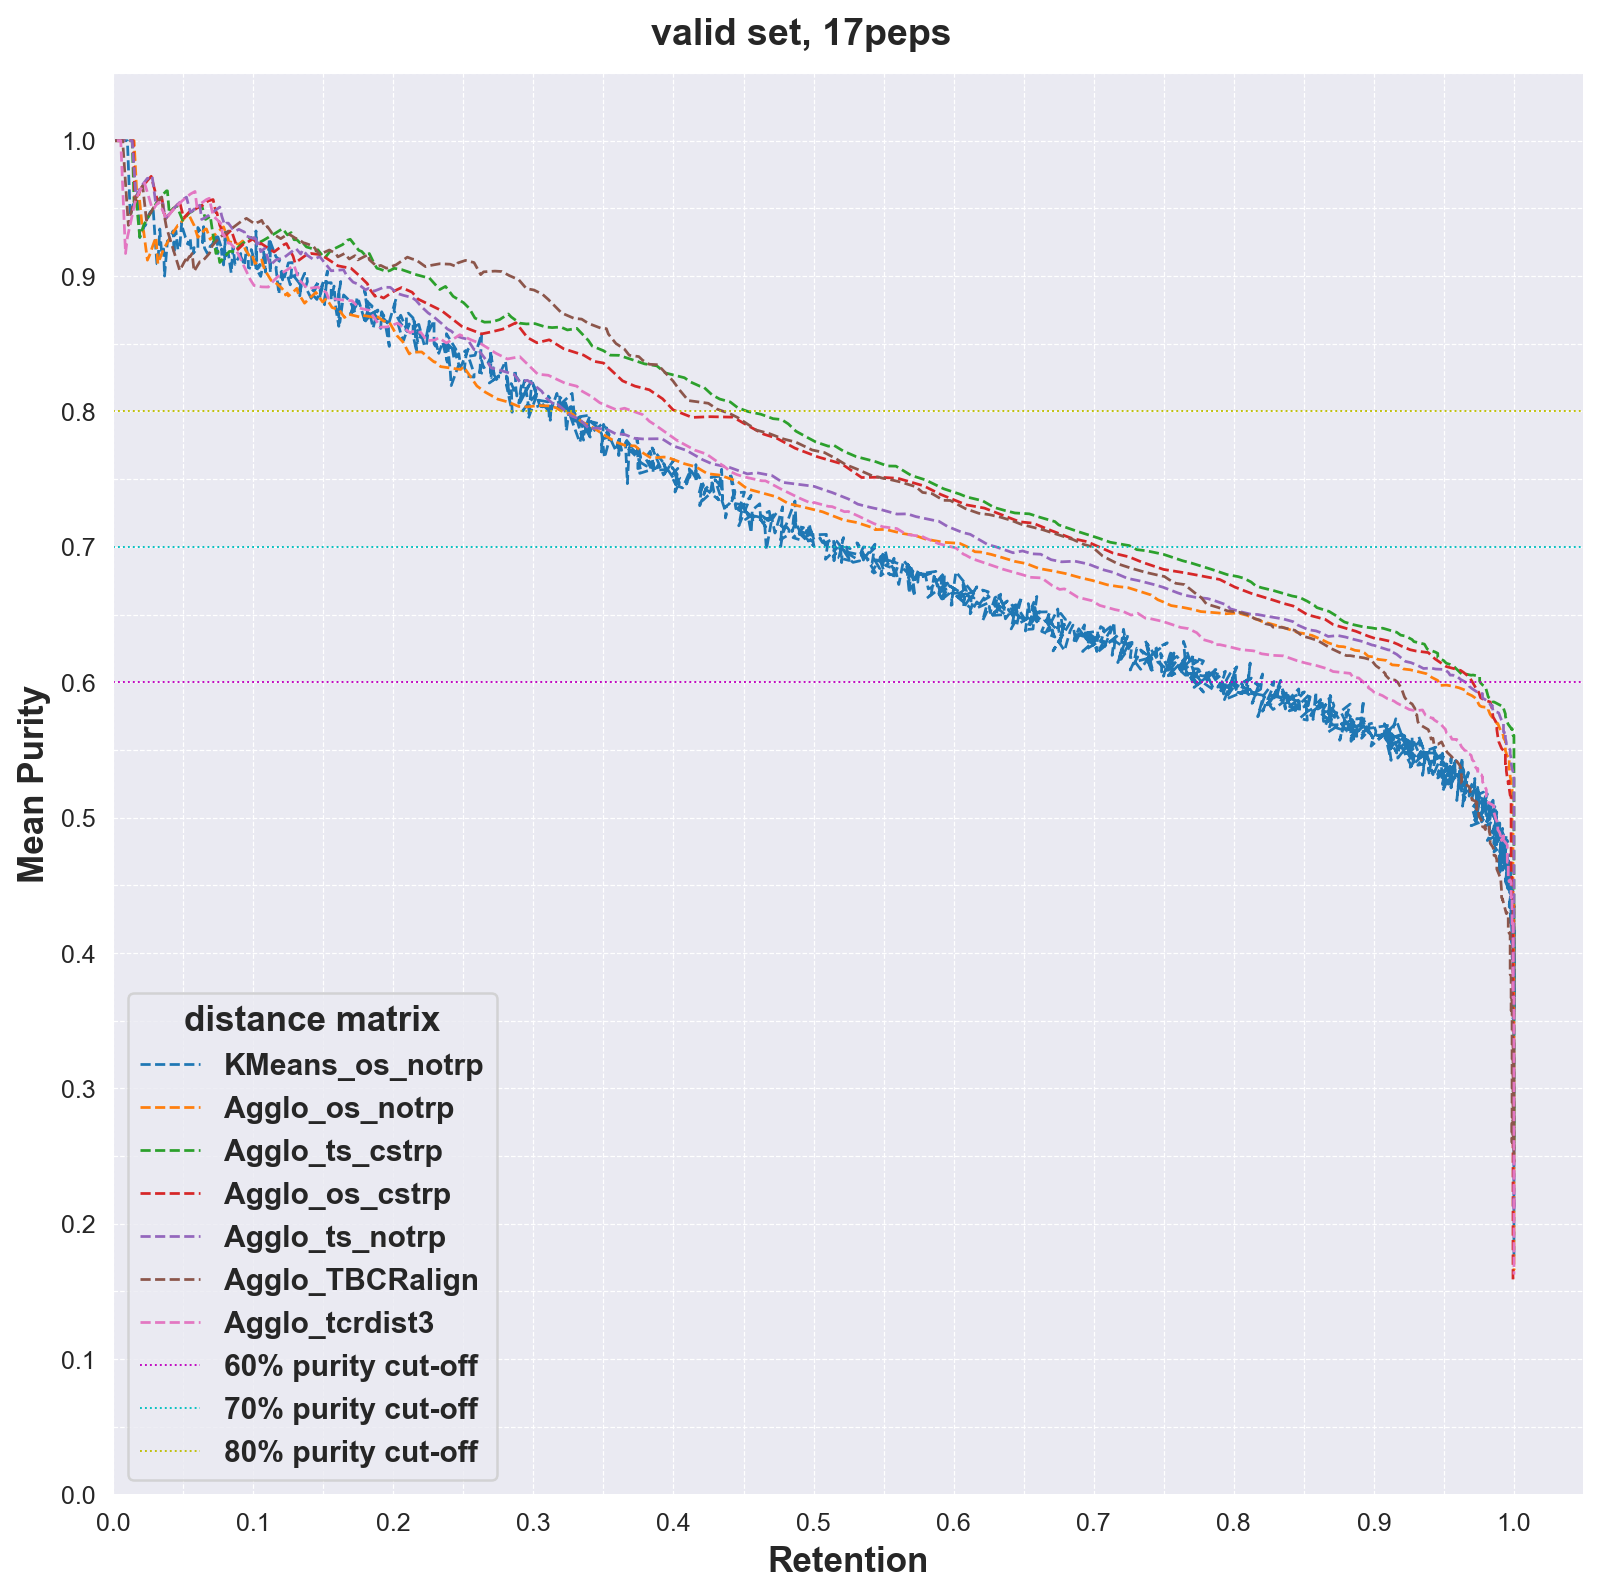

In [24]:
plot_retention_purities(concat_res.query('partition=="valid"').drop(columns=['input_type']).rename(columns={'hue':'input_type'}), title='valid set, 17peps')

(<Figure size 1620x1620 with 1 Axes>,
 <Axes: xlabel='Retention', ylabel='Mean Purity'>)

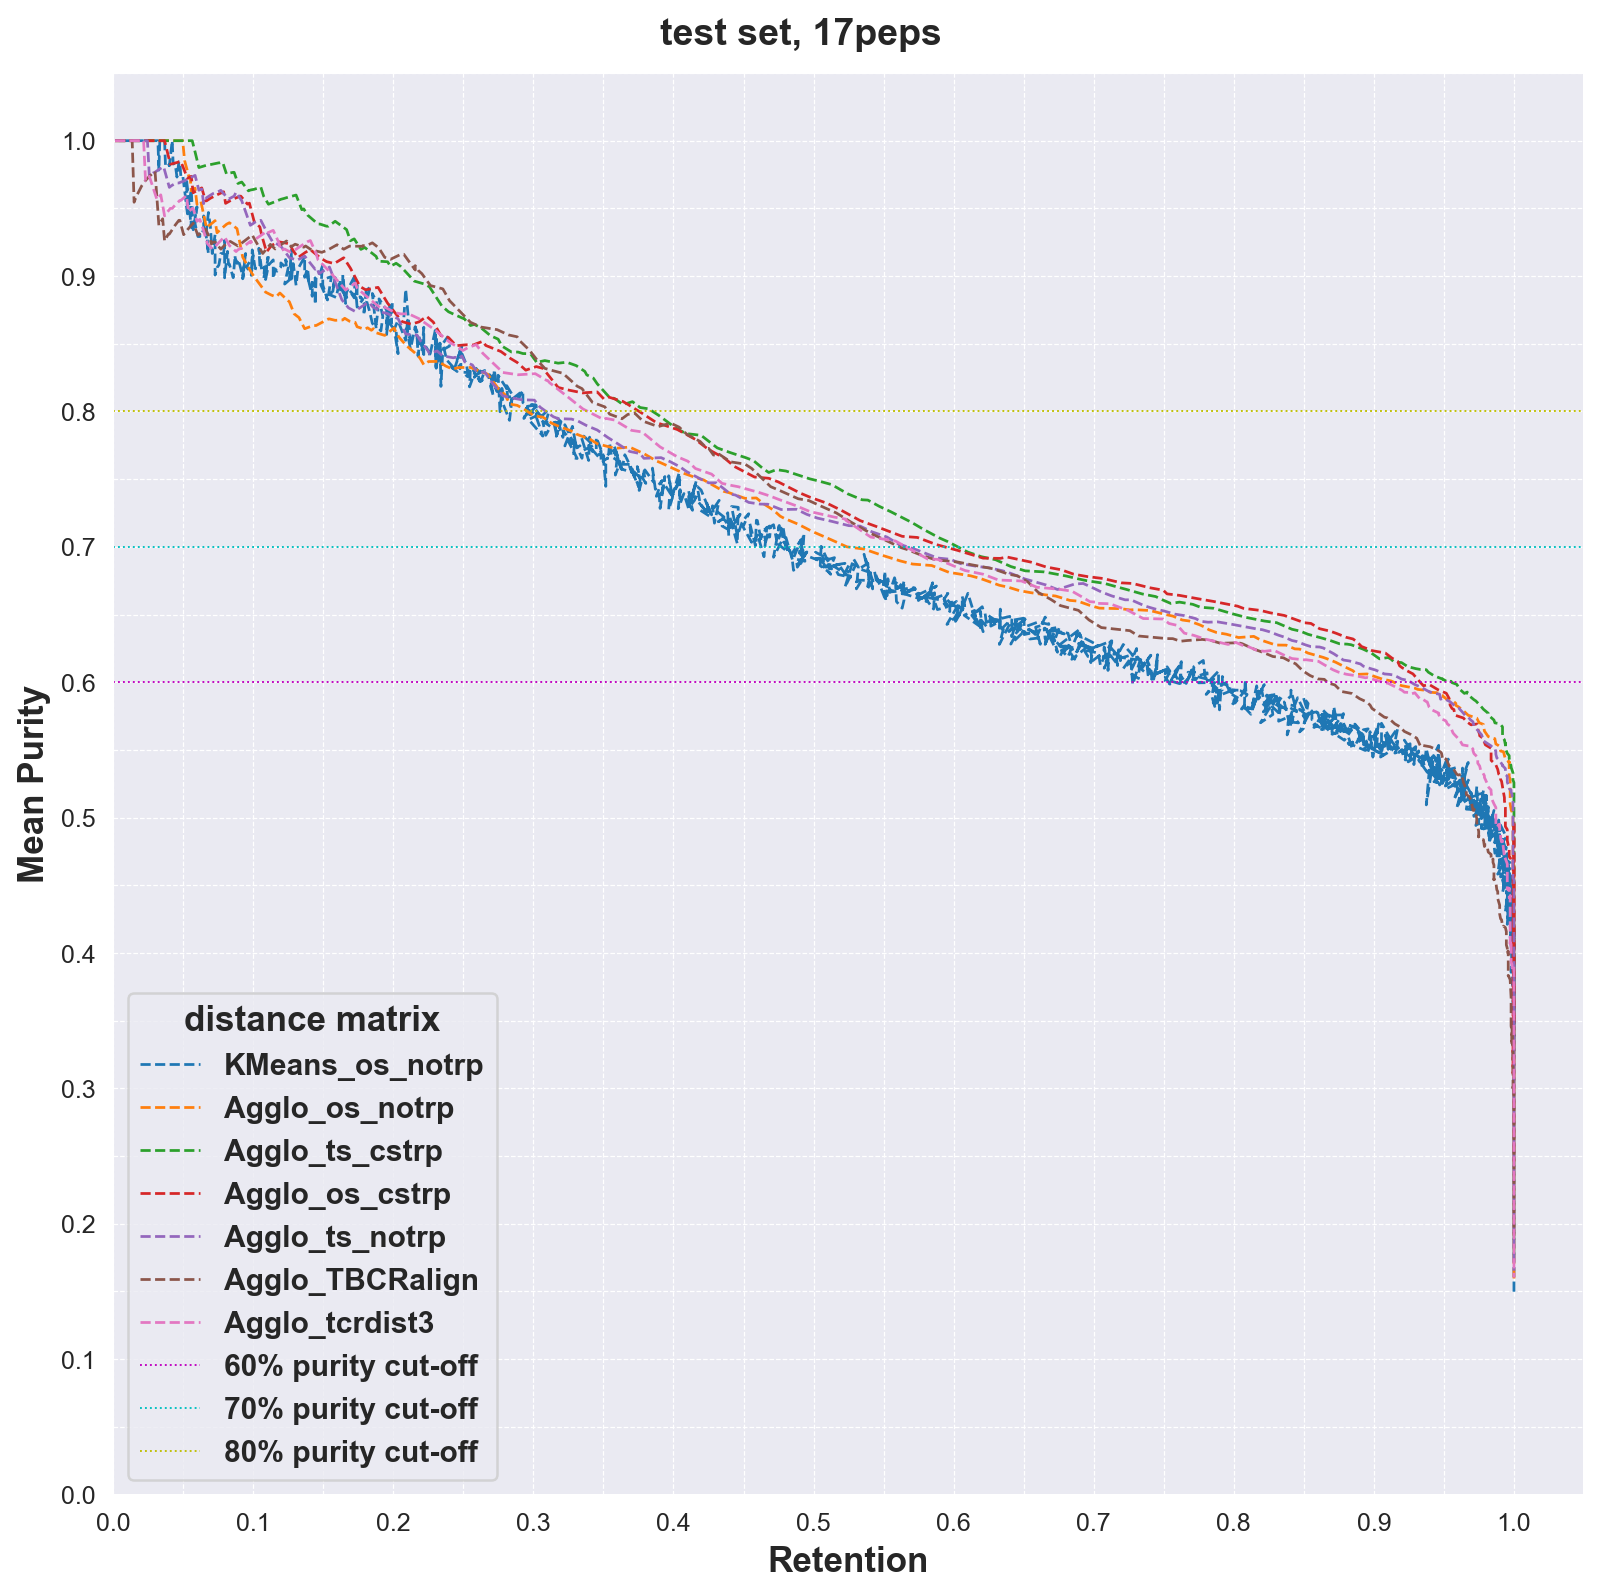

In [23]:
plot_retention_purities(concat_res.query('partition=="test"').drop(columns=['input_type']).rename(columns={'hue':'input_type'}), title='test set, 17peps')

# Agglo Silhouette check

## first check

In [32]:
concat_res.query('partition=="valid" and clustering=="KMeans" and input_type=="os_notrp"').loc[concat_res.query('partition=="valid" and clustering=="KMeans" and input_type=="os_notrp"')['silhouette'].idxmax()] 


threshold                        15.0
n_cluster                          15
n_singletons                        0
n_cluster_over_70p                  0
mean_purity                  0.235617
min_purity                   0.147826
max_purity                   0.458824
mean_cluster_size           98.066667
min_cluster_size                  9.0
max_cluster_size                166.0
silhouette                   0.118173
ch_index                    27.414168
db_index                     3.082343
ARI                          0.034099
retention                         1.0
input_type                   os_notrp
dataset                         top17
partition                       valid
clustering                     KMeans
db                                NaN
hue                   KMeans_os_notrp
Name: 13, dtype: object

In [79]:
def get_sc(df, input_type, clustering,partition):
    tmp = df.query('partition==@partition and clustering==@clustering and input_type==@input_type')
    return tmp.loc[tmp['silhouette'].idxmax()]

In [47]:
get_sc(concat_res, 'Agglo', 'os_cstrp', 'valid')

threshold                    0.38982
n_cluster                          1
n_singletons                       1
n_cluster_over_70p                 0
mean_purity                 0.157823
min_purity                  0.157823
max_purity                  0.157823
mean_cluster_size             1470.0
min_cluster_size              1470.0
max_cluster_size              1470.0
silhouette                  0.464159
ch_index                    2.027156
db_index                     0.69831
ARI                        -0.000215
retention                    0.99932
input_type                  os_cstrp
dataset                          NaN
partition                      valid
clustering                     Agglo
db                             top17
hue                   Agglo_os_cstrp
Name: 9323, dtype: object

In [241]:
def clusterfuck(df, input_type, clustering, partition, fn=None):
    f,ax = plt.subplots(1,1,figsize=(7,4))
    tmp = df.query('input_type==@input_type and clustering==@clustering and partition==@partition').reset_index(drop=True)

    tmp[['mean_purity', 'silhouette', 'retention']].plot(ax=ax)
    ax2 = ax.twinx()
    tmp[['n_cluster']].plot(ax=ax2, c='r')
    ax.axvline(tmp['silhouette'].idxmax(),
              ls='--', lw=0.5, c='k')
    ax.legend(loc='center left')
    ax.set_title(f'{partition} - {input_type} - {clustering}')
    if fn is not None:
        f.savefig(fn, dpi=200, bbox_inches='tight')

from src.cluster_utils import get_all_metrics
def wtf(model, df, cat, input_type, clustering, partition, threshold=None):
    if threshold is None:
        sc = get_sc(cat, input_type, clustering, partition)
        threshold = sc['threshold']
        print(sc)
    latent = get_latent_df(model, df)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=threshold)
    dm, da, feats, labs, enc_labs, lab_enc = get_distances_labels_from_latent(latent, index_col='raw_index')
    c.fit(da);
    # cosine 
    print('Cosine using features', round(silhouette_score(feats, c.labels_, metric='cosine'),4))
    print('Eucli using features', round(silhouette_score(feats, c.labels_, metric='euclidean'),4))
    print('Cosine-precomputed', round(silhouette_score(da, c.labels_, metric='precomputed'),4))
    print('Get Metrics: ', get_all_metrics(threshold, torch.rand((len(latent), 2)), c, da, labs, enc_labs, lab_enc))
    print('--'*10)


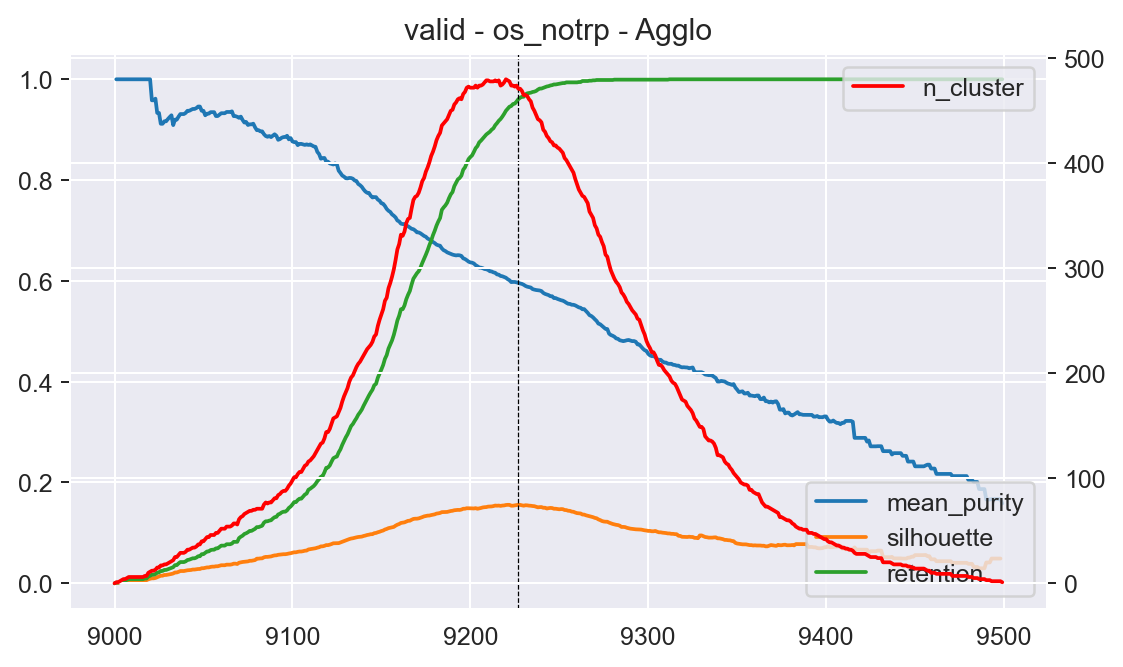

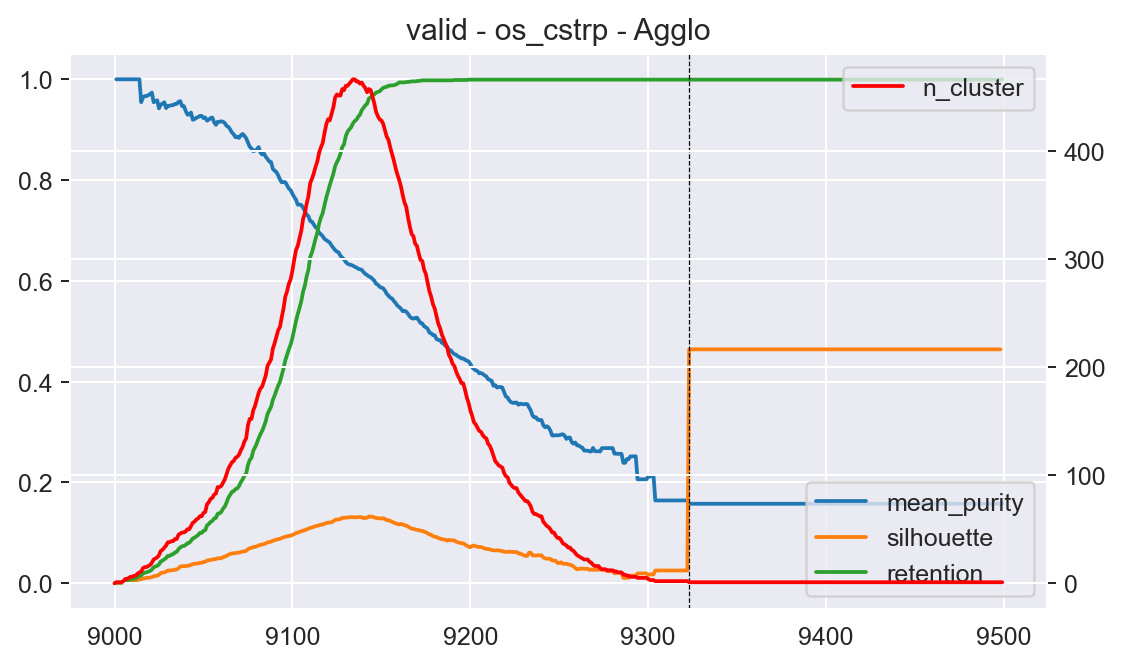

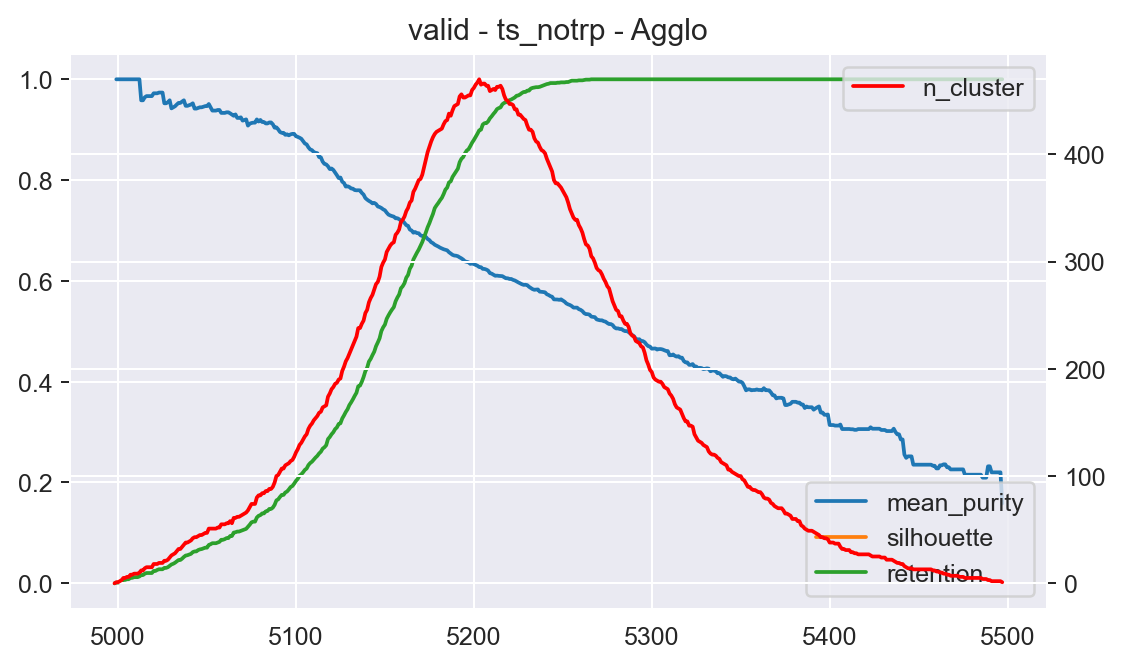

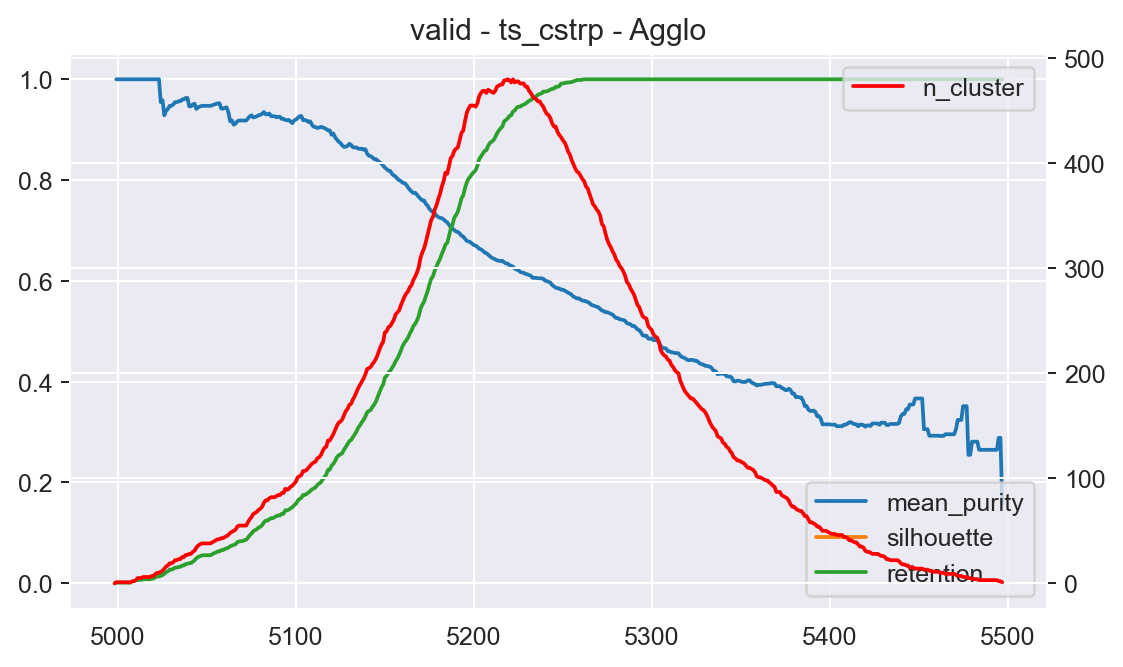

In [75]:
clusterfuck(concat_res, 'os_notrp', 'Agglo', 'valid')
clusterfuck(concat_res, 'os_cstrp', 'Agglo', 'valid')
clusterfuck(concat_res, 'ts_notrp', 'Agglo', 'valid')
clusterfuck(concat_res, 'ts_cstrp', 'Agglo', 'valid')

In [111]:
wtf(os_cstrp, test, concat_res, 'os_cstrp', 'Agglo', 'test')

threshold                    0.39371
n_cluster                          2
n_singletons                       0
n_cluster_over_70p                 0
mean_purity                 0.246243
min_purity                  0.159153
max_purity                  0.333333
mean_cluster_size              735.0
min_cluster_size                 6.0
max_cluster_size              1464.0
silhouette                  0.246658
ch_index                    4.298209
db_index                    2.265203
ARI                        -0.000023
retention                        1.0
input_type                  os_cstrp
dataset                          NaN
partition                       test
clustering                     Agglo
db                             top17
hue                   Agglo_os_cstrp
Name: 9421, dtype: object
Cosine using features 0.2467
Eucli using features 0.1224
Cosine-precomputed 0.2467
Get Metrics:  {'threshold': 0.39371, 'n_cluster': 2, 'n_singletons': 0, 'n_cluster_over_70p': 0, 'mean_purity': 0.

In [114]:
wtf(ts_cstrp, test, concat_res, 'ts_cstrp', 'Agglo', 'test', threshold=1.0)

Cosine using features 0.0704
Eucli using features 0.0248
Cosine-precomputed 0.0704
Get Metrics:  {'threshold': 1.0, 'n_cluster': 129, 'n_singletons': 0, 'n_cluster_over_70p': 13, 'mean_purity': 0.39696974621031667, 'min_purity': 0.15384615384615385, 'max_purity': 1.0, 'mean_coherence': 0.6921525, 'min_coherence': 0.46167216, 'max_coherence': 0.8090778, 'mean_cluster_size': 11.395348837209303, 'min_cluster_size': 3, 'max_cluster_size': 50, 'silhouette': 0.07036166, 'ch_index': 0.8880767501883372, 'db_index': 71.97997559134986, 'ARI': 0.06163594948806153}
--------------------


In [146]:
def pipe_agglo(model, input_df, input_type, clustering, partition):
    latent = get_latent_df(model, input_df)
    dm, da, feats, labs, enc_labs, lab_enc = get_distances_labels_from_latent(latent, index_col='raw_index')
    results = cluster_all_thresholds(da, feats, labs, enc_labs, lab_enc, n_jobs=8)
    return results.assign(input_type=input_type, clustering=clustering, partition=partition)

In [150]:
os_cstrp_res = pd.concat([pipe_agglo(os_cstrp, test, 'os_cstrp', 'Agglo', 'test'),
                          pipe_agglo(os_cstrp, valid, 'os_cstrp', 'Agglo', 'valid')])
ts_cstrp_res = pd.concat([pipe_agglo(ts_cstrp, test, 'ts_cstrp', 'Agglo', 'test'),
                          pipe_agglo(ts_cstrp, valid, 'ts_cstrp', 'Agglo', 'valid')])
os_notrp_res = pd.concat([pipe_agglo(os_notrp, test, 'os_notrp', 'Agglo', 'test'),
                          pipe_agglo(os_notrp, valid, 'os_notrp', 'Agglo', 'valid')])
ts_notrp_res = pd.concat([pipe_agglo(ts_notrp, test, 'ts_notrp', 'Agglo', 'test'),
                          pipe_agglo(ts_notrp, valid, 'ts_notrp', 'Agglo', 'valid')])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [210]:
%rm -r ../output/240924_PeptideRedoClustering
%mkdir ../output/240924_PeptideRedoClustering
vaes_results_test_valid = pd.concat([os_cstrp_res, ts_cstrp_res, os_notrp_res, ts_notrp_res])
vaes_results_test_valid.to_csv('../output/240924_PeptideRedoClustering/17peps_valid_test_agglo_micro_avg_results.csv')

In [152]:
valid.iloc[[943]]

Unnamed: 0.1  Unnamed: 0    peptide     A1       A2  \
4726          4726        6261  GILGFVFTL  TTSDR  LLSNGAV   

                          A3     B1      B2           B3       allele  \
4726  AVVRGISRWHQNAGGTSYGKLT  LNHDA  SQIVND  ASSIRSAQPQH  HLA-A*02:01   

      partition  binder origin original_peptide   raw_index reference  \
4726          0       1    10x        GILGFVFTL  ITRAP_1738  37133356   

     source_organism input_type      db  len_q  
4726             NaN     paired  nettcr      5

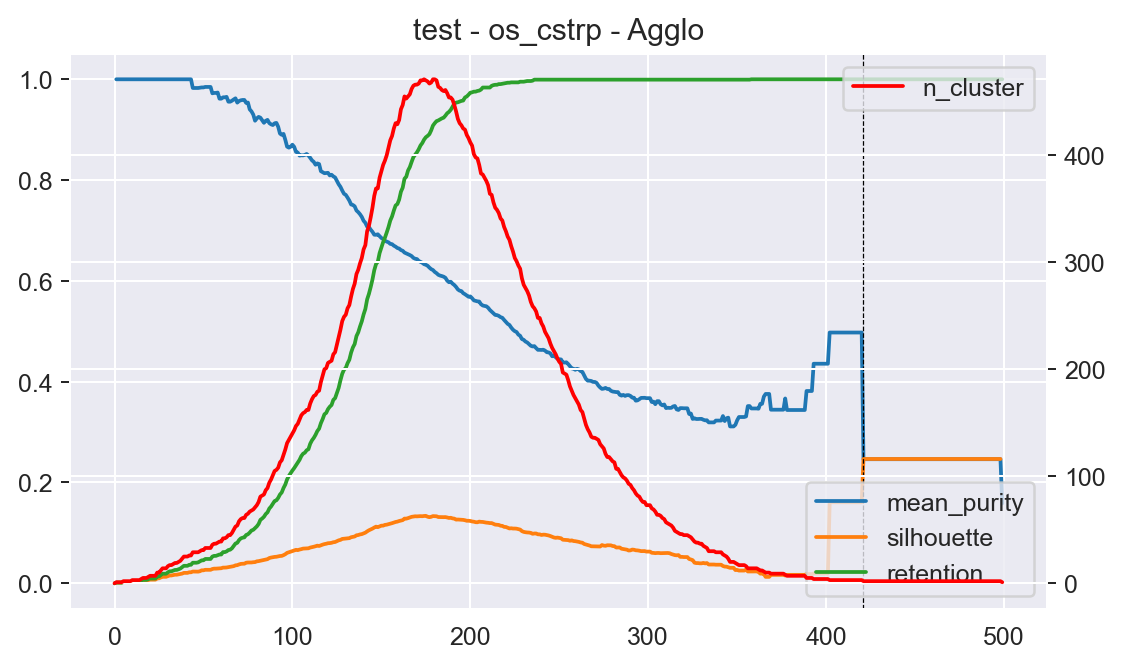

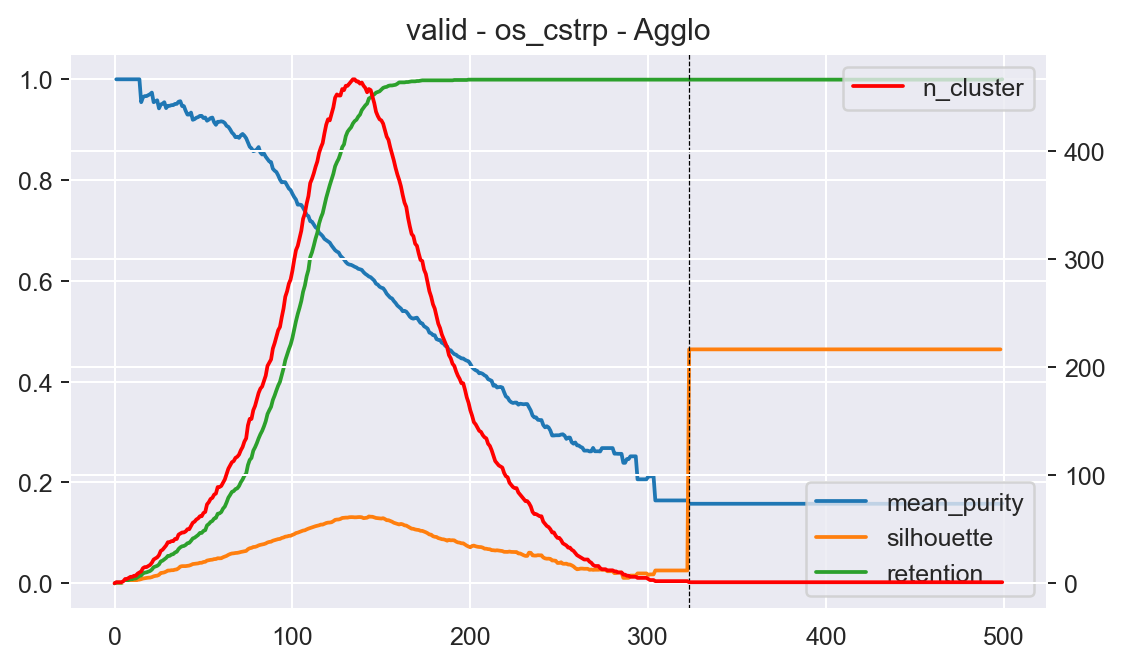

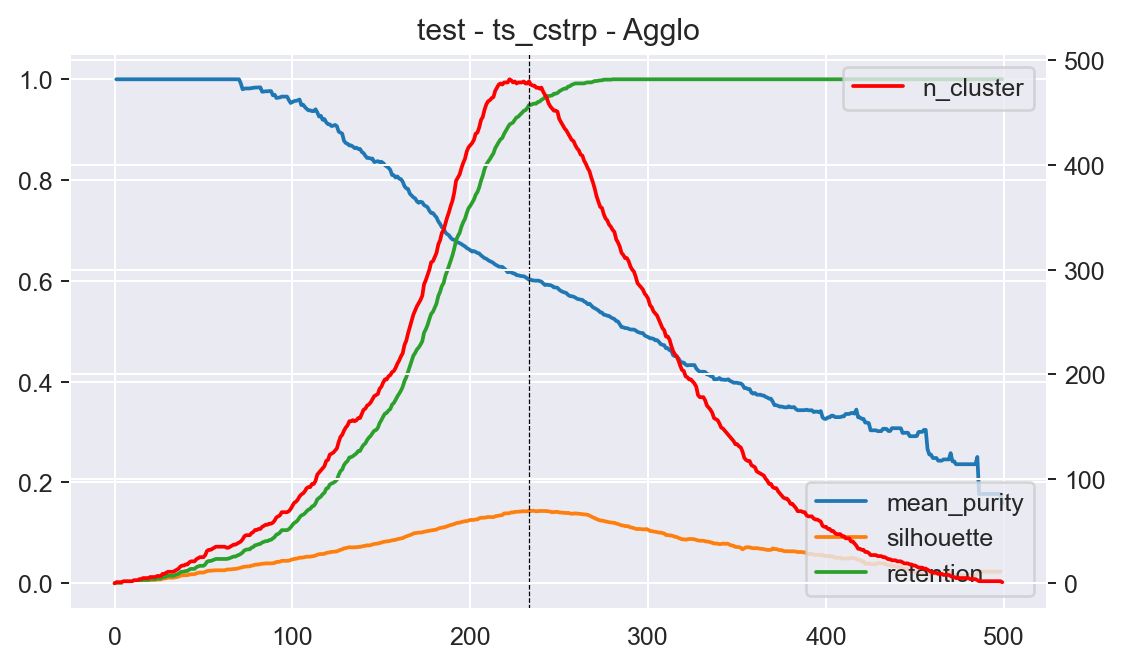

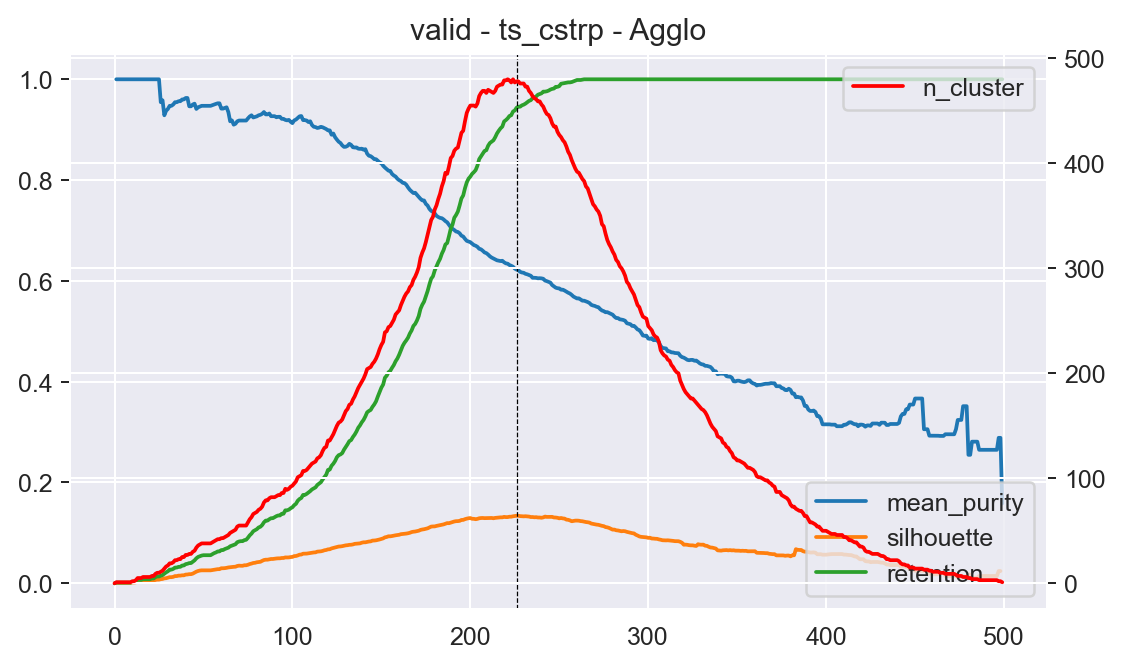

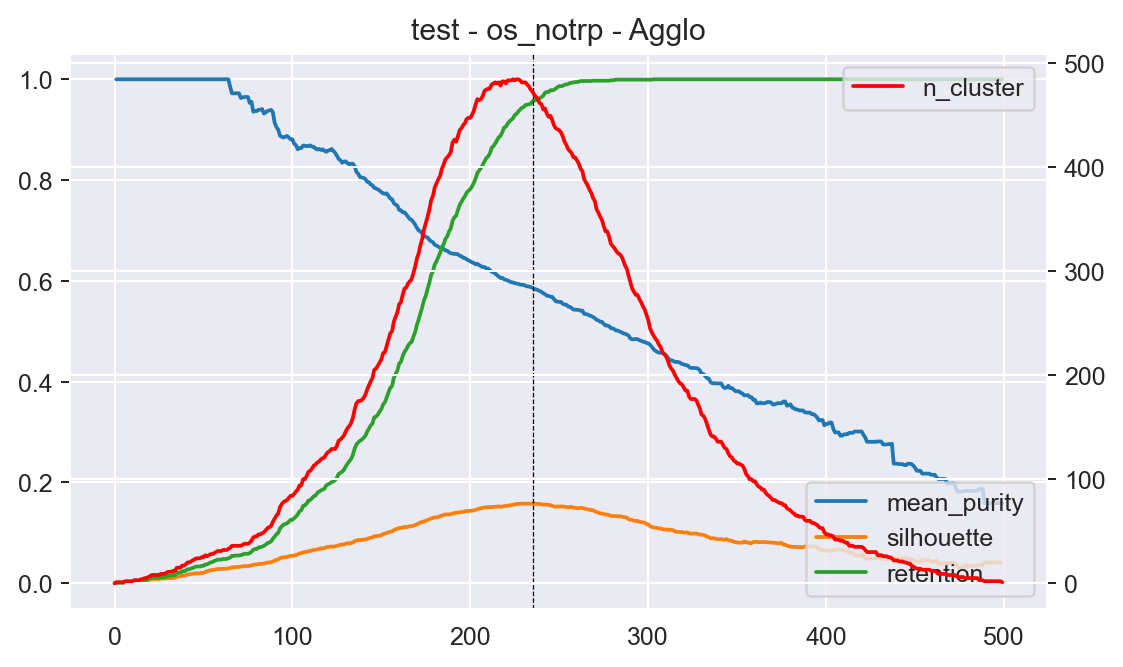

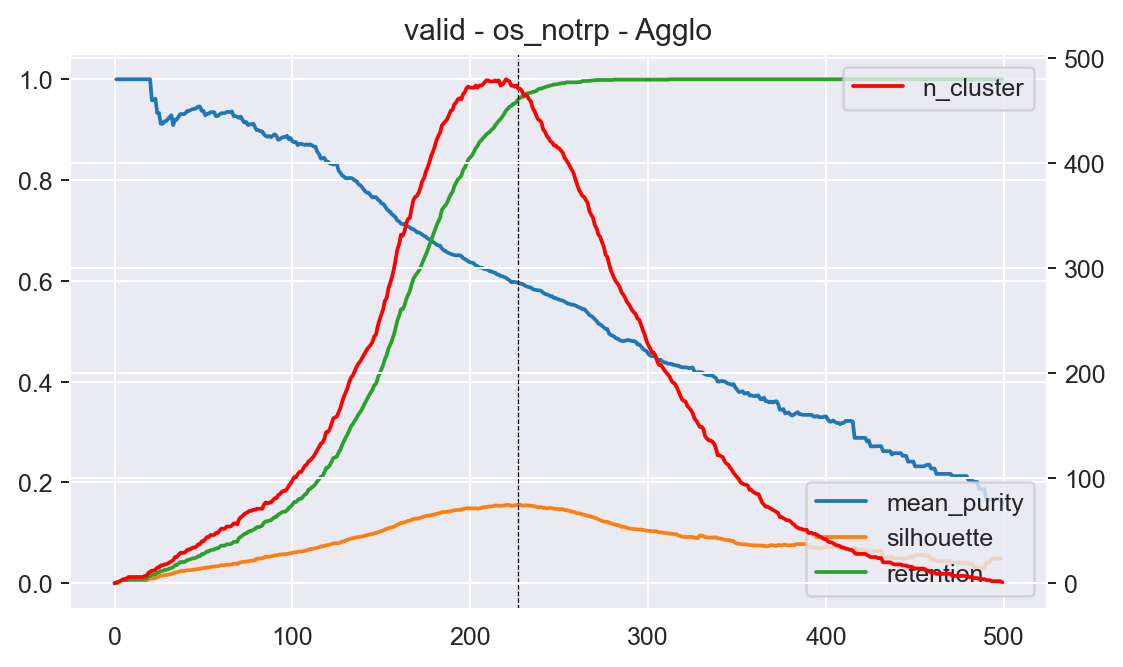

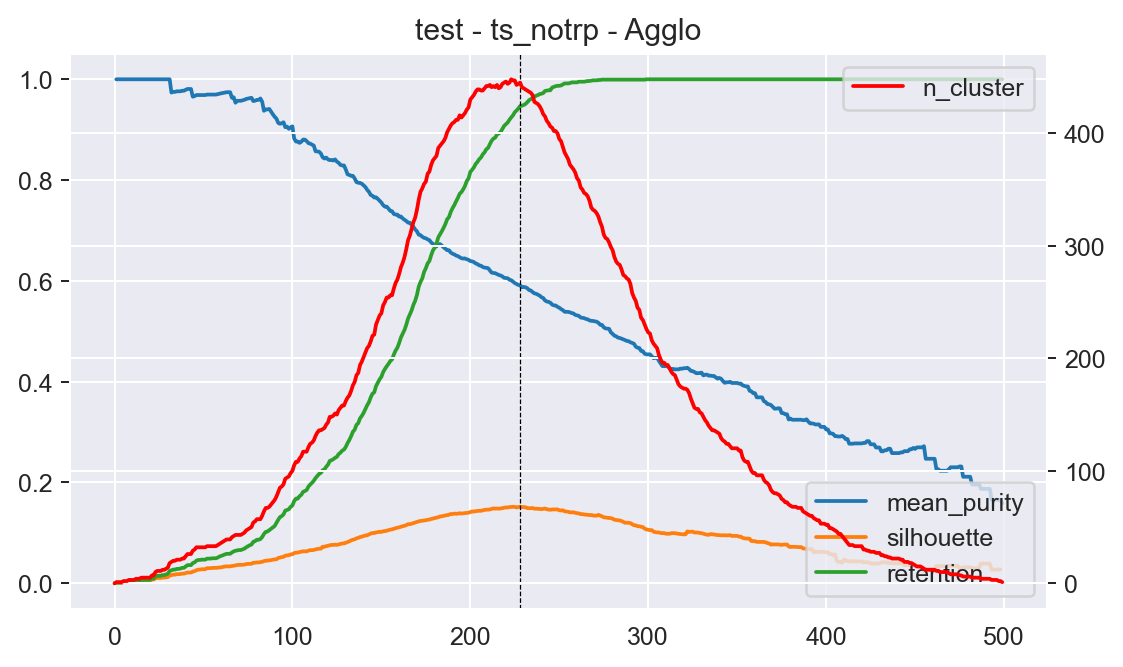

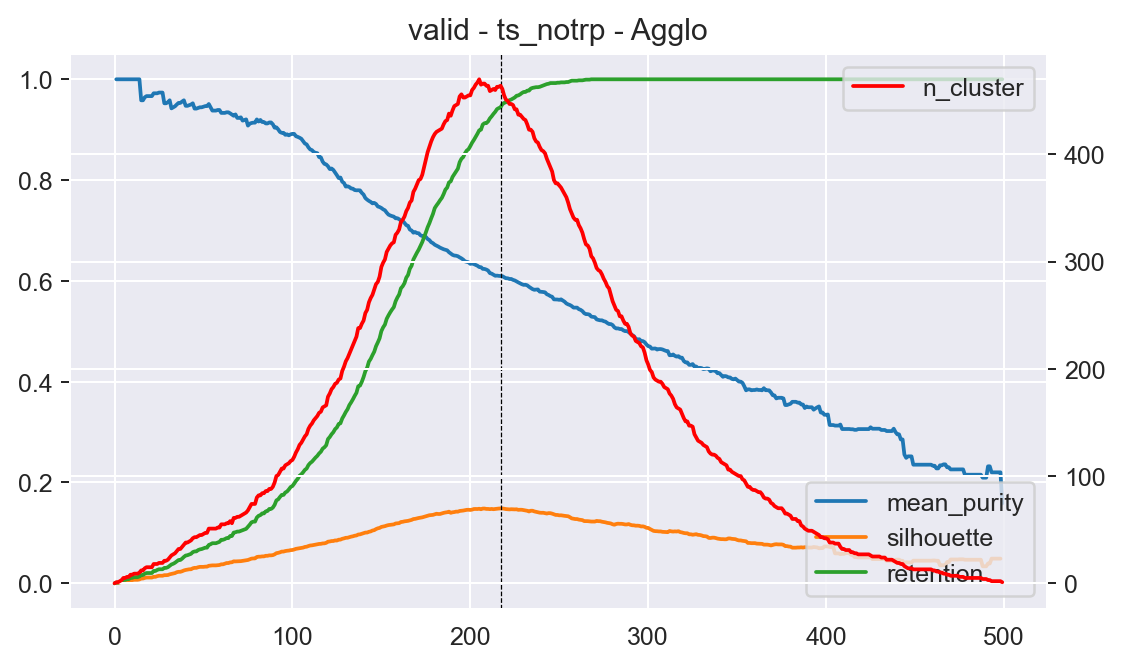

In [211]:
for input_type in vaes_results_test_valid['input_type'].unique():
    for partition in vaes_results_test_valid['partition'].unique():
        clusterfuck(vaes_results_test_valid, input_type, 'Agglo', partition, fn=f'../output/240924_PeptideRedoClustering/{input_type}_agglo_{partition}.png')

In [127]:
sc = get_sc(concat_res, 'os_cstrp', 'Agglo', 'valid')
threshold = sc['threshold']
latent = get_latent_df(os_cstrp, valid)
c = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=threshold)
dm, da, feats, labs, enc_labs, lab_enc = get_distances_labels_from_latent(latent, index_col='raw_index')
c.fit(da);
# cosine 
print('Cosine using features', round(silhouette_score(feats, c.labels_, metric='cosine'),4))
print('Eucli using features', round(silhouette_score(feats, c.labels_, metric='euclidean'),4))
print('Cosine-precomputed', round(silhouette_score(da, c.labels_, metric='precomputed'),4))
print('Get Metrics: ', get_all_metrics(threshold, torch.rand((len(latent), 2)), c, da, labs, enc_labs, lab_enc))
print('--'*10)

Cosine using features 0.4642
Eucli using features 0.1858
Cosine-precomputed 0.4642
Get Metrics:  {'threshold': 0.38982, 'n_cluster': 1, 'n_singletons': 1, 'n_cluster_over_70p': 0, 'mean_purity': 0.15782312925170067, 'min_purity': 0.15782312925170067, 'max_purity': 0.15782312925170067, 'mean_coherence': 0.24483567, 'min_coherence': 0.24483567, 'max_coherence': 0.24483567, 'mean_cluster_size': 1470.0, 'min_cluster_size': 1470, 'max_cluster_size': 1470, 'silhouette': 0.46415925, 'ch_index': 1.214636905422355, 'db_index': 0.8543384486171789, 'ARI': -0.00021522555719765817}
--------------------


In [195]:
# check singletons only solution and silhouette score:
almost_all_singletons = np.arange(len(da))
almost_all_singletons[-3:] = 0

two_clusters = np.zeros(len(da))
two_clusters[520] = 1
print('Silhouette score for artificial and real pred labels')
print('all singletons ', silhouette_score(da, almost_all_singletons, metric='precomputed'))
print('fake random 2 luster (idx=520)', silhouette_score(da, two_clusters, metric='precomputed'))
print('Predicted 2 cluster labels (idx 943) ', silhouette_score(da, c.labels_, metric='precomputed'))

two_clusters = np.zeros(len(da))
two_clusters[943] = 1
print('fake 2 cluster labels (idx 943) ', silhouette_score(da, two_clusters, metric='precomputed'))

Silhouette score for artificial and real pred labels
all singletons  -0.0014458016
fake random 2 luster (idx=520) -0.07268782
Predicted 2 cluster labels (idx 943)  0.46415925
fake 2 cluster labels (idx 943)  0.46415925


In [174]:
xd=dm.iloc[940:950, 940:950].reset_index(drop=True)
xd.columns = range(len(xd.columns))
xd


0         1         2         3         4         5         6  \
0  0.000000  0.240598  0.266497  0.522413  0.250180  0.321305  0.270900   
1  0.240598  0.000000  0.204717  0.352962  0.265179  0.244407  0.202990   
2  0.266497  0.204717  0.000000  0.458753  0.254106  0.232124  0.252131   
3  0.522413  0.352962  0.458753  0.000000  0.464012  0.510972  0.356215   
4  0.250180  0.265179  0.254106  0.464012  0.000000  0.249743  0.274041   
5  0.321305  0.244407  0.232124  0.510972  0.249743  0.000000  0.257306   
6  0.270900  0.202990  0.252131  0.356215  0.274041  0.257306  0.000000   
7  0.240681  0.201761  0.208461  0.452625  0.237470  0.199051  0.209485   
8  0.250795  0.204955  0.220546  0.416735  0.206282  0.242607  0.238401   
9  0.235284  0.198566  0.161613  0.414493  0.198369  0.250158  0.220821   

          7         8         9  
0  0.240681  0.250795  0.235284  
1  0.201761  0.204955  0.198566  
2  0.208461  0.220546  0.161613  
3  0.452625  0.416735  0.414493  
4  0.237470  0.206282  0.198369  
5  0.199051  0.242607  0.250158  
6  0.209485  0.238401  0.220821  
7  0.000000  0.210277  0.212857  
8  0.210277  0.000000  0.172623  
9  0.212857  0.172623  0.000000

In [197]:
xd2 = dm.drop(columns = ['peptide','partition','binder','origin','original_peptide','raw_index']).reset_index(drop=True)
xd2.columns = range(len(xd2.columns))
xd2.mean(axis=1).sort_values(ascending=False)

943     0.462527
1310    0.295110
521     0.294931
327     0.291638
300     0.279728
          ...   
182     0.220882
725     0.220362
855     0.218066
448     0.217952
108     0.210741
Length: 1471, dtype: float32

In [161]:
valid.iloc[[943]].apply(lambda x: [len(x['A3']), len(x['B3'])], axis=1)

4726    [22, 11]
dtype: object

In [166]:
valid['A3_len'] = valid['A3'].apply(len)
valid.query('A3_len>18').groupby('partition').count()

Unnamed: 0.1  Unnamed: 0  peptide  A1  A2  A3  B1  B2  B3  allele  \
partition                                                                      
0                     5           5        5   5   5   5   5   5   5       5   

           binder  origin  original_peptide  raw_index  reference  \
partition                                                           
0               5       5                 5          5          5   

           source_organism  input_type  db  len_q  A3_len  
partition                                                  
0                        0           5   5      5       5

In [156]:
exp = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv')
exp['seq'] = exp[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
exp.loc[exp.duplicated('seq', keep=False)]

Unnamed: 0    peptide     A1       A2            A3     B1      B2  \
7513       45520  GILGFVFTL  SIFNT  LYKAGEL  AGPMKTSYDKVI  SGHDY  FNNNVP   
8592       52052  NLVPMVATV  SIFNT  LYKAGEL  AGPMKTSYDKVI  SGHDY  FNNNVP   

              B3       allele  partition  binder origin original_peptide  \
7513  ASSSANYGYT  HLA-A*02:01          3       1  VDJdb        GILGFVFTL   
8592  ASSSANYGYT  HLA-A*02:01          2       1  VDJdb        NLVPMVATV   

        raw_index reference source_organism input_type  \
7513  VDJdb_65884  28636592      InfluenzaA    tcr_pep   
8592   VDJdb_4837  19864595             CMV    tcr_pep   

                                                seq  
7513  SIFNTLYKAGELAGPMKTSYDKVISGHDYFNNNVPASSSANYGYT  
8592  SIFNTLYKAGELAGPMKTSYDKVISGHDYFNNNVPASSSANYGYT

In [183]:
exp.query('seq=="TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDASSIRSAQPQH"')

Unnamed: 0    peptide     A1       A2                      A3     B1  \
6261       37725  GILGFVFTL  TTSDR  LLSNGAV  AVVRGISRWHQNAGGTSYGKLT  LNHDA   

          B2           B3       allele  partition  binder origin  \
6261  SQIVND  ASSIRSAQPQH  HLA-A*02:01          0       1    10x   

     original_peptide   raw_index reference source_organism input_type  \
6261        GILGFVFTL  ITRAP_1738  37133356             NaN    tcr_pep   

                                                    seq  
6261  TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDA...

## Redo Silhouette for TBCRalign and tcrdist

In [227]:
test_latent = get_latent_df(os_notrp, test)
valid_latent = get_latent_df(os_notrp, valid)
test_dm, _, _ ,_ ,_ ,_ = get_distances_labels_from_latent(test_latent, index_col='raw_index')
valid_dm, _, _ ,_ ,_ ,_ = get_distances_labels_from_latent(valid_latent, index_col='raw_index')

In [245]:
tbcralign = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
tbcr_valid = tbcralign.query('partition==0')
tbcr_test = tbcralign.query('partition==1')
tcrdist = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_cdr3_distmatrix_140peps_labeled.csv', index_col=0)
tcrdist_valid = tcrdist.query('partition==0')
tcrdist_test = tcrdist.query('partition==1')

In [246]:
tbcr_valid, _  = resort_baseline(tbcr_valid, valid_dm, 'raw_index')
tcrdist_valid, _  = resort_baseline(tcrdist_valid, valid_dm, 'raw_index')
tbcr_test, _  = resort_baseline(tbcr_test, test_dm, 'raw_index')
tcrdist_test, _  = resort_baseline(tcrdist_test, test_dm, 'raw_index')

In [237]:
def baseline_pipe_agglo(dm, input_type, clustering, partition):
    da = dm.iloc[:len(dm), :len(dm)].values
    labels = dm['peptide'].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    results = cluster_all_thresholds(da, da, labels, encoded_labels, label_encoder, n_jobs=8)
    return results.assign(input_type=input_type, clustering=clustering, partition=partition)
    

In [247]:
tbcr_valid_results = baseline_pipe_agglo(tbcr_valid, 'TBCRalign', 'Agglo', 'valid')
tcrdist_valid_results = baseline_pipe_agglo(tcrdist_valid, 'tcrdist', 'Agglo', 'valid')
tbcr_test_results = baseline_pipe_agglo(tbcr_test, 'TBCRalign', 'Agglo', 'test')
tcrdist_test_results = baseline_pipe_agglo(tcrdist_test, 'tcrdist', 'Agglo', 'test')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [248]:
baseline_results = pd.concat([tbcr_valid_results, tcrdist_valid_results, tbcr_test_results, tcrdist_test_results])
all_results = pd.concat([vaes_results_test_valid, baseline_results])
all_results.to_csv('../output/240924_PeptideRedoClustering/17peps_valid_test_agglo_micro_avg_results.csv')

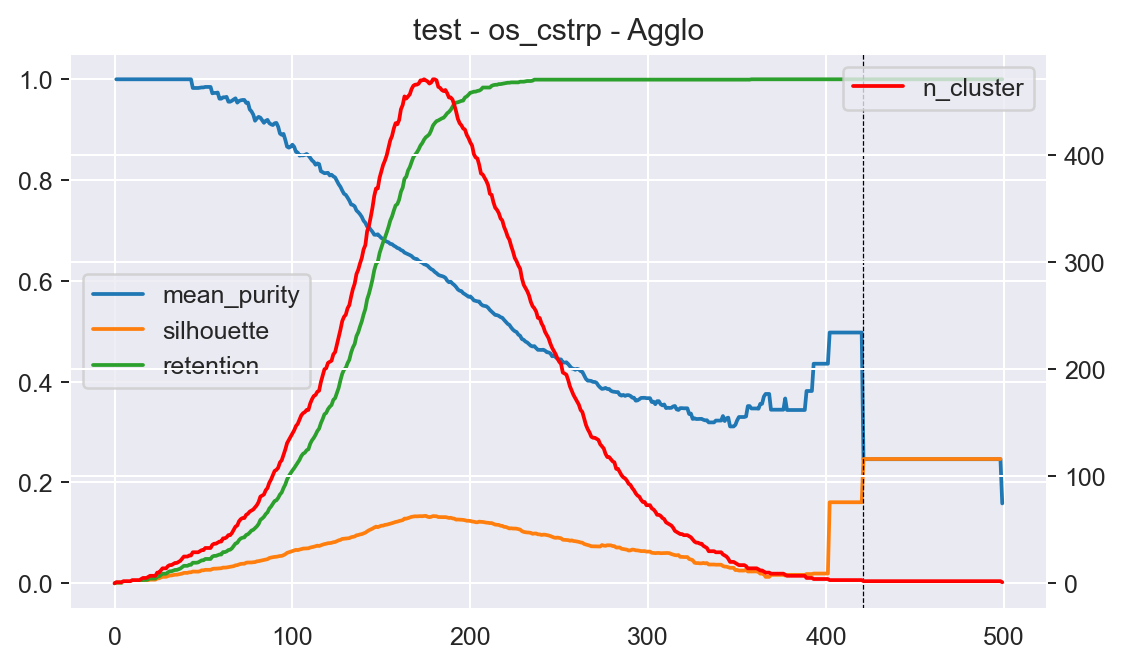

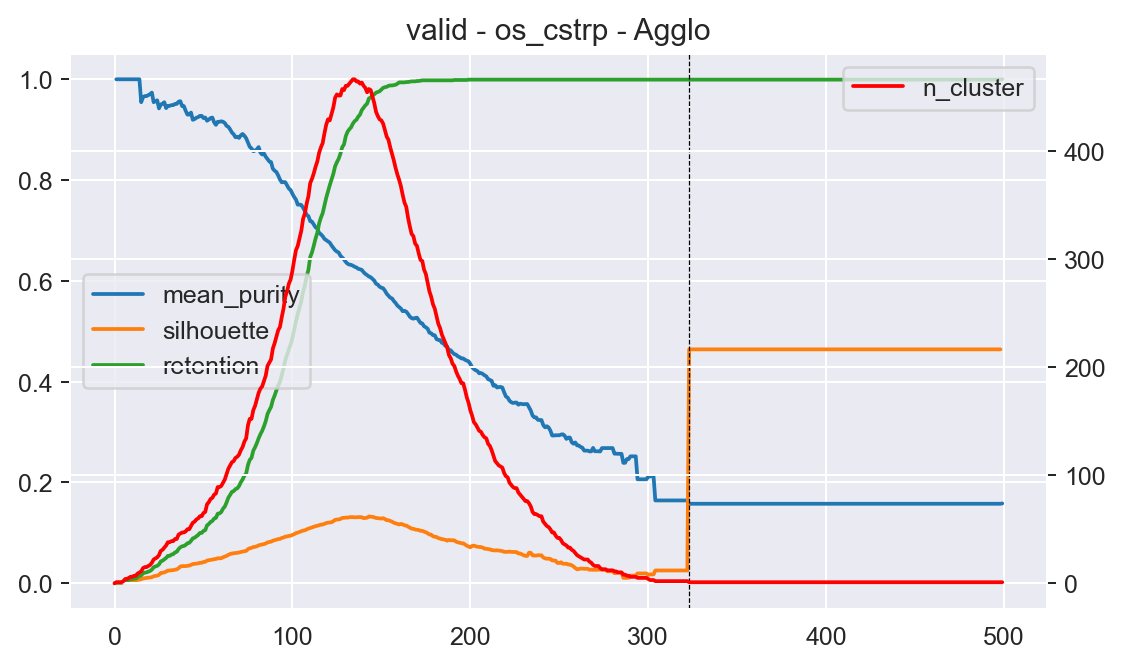

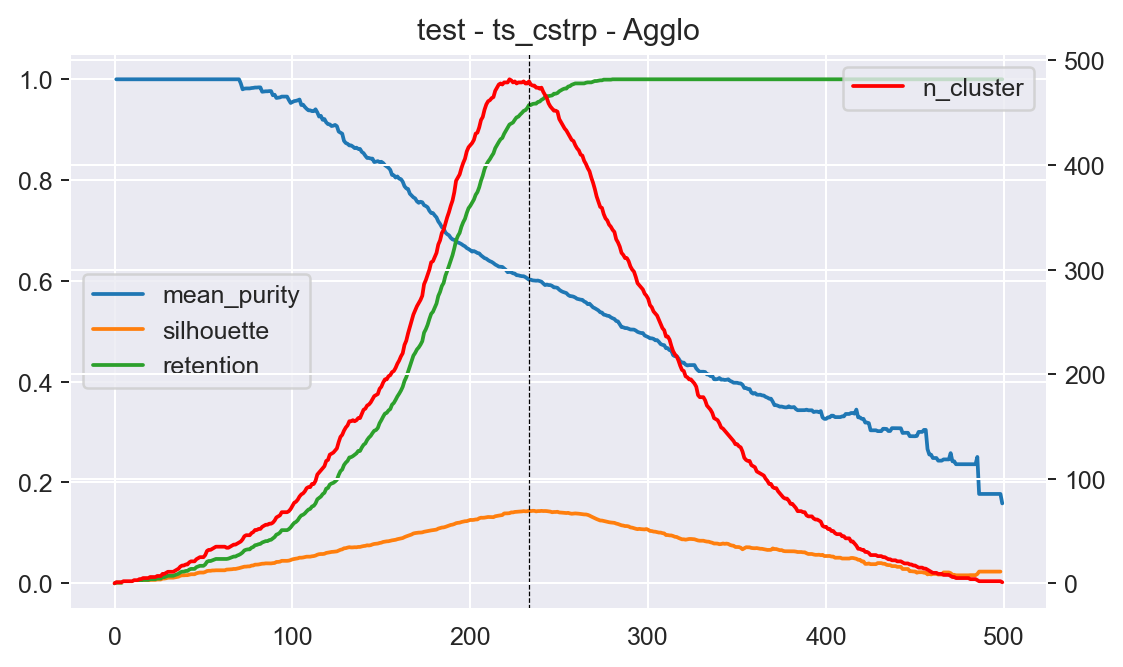

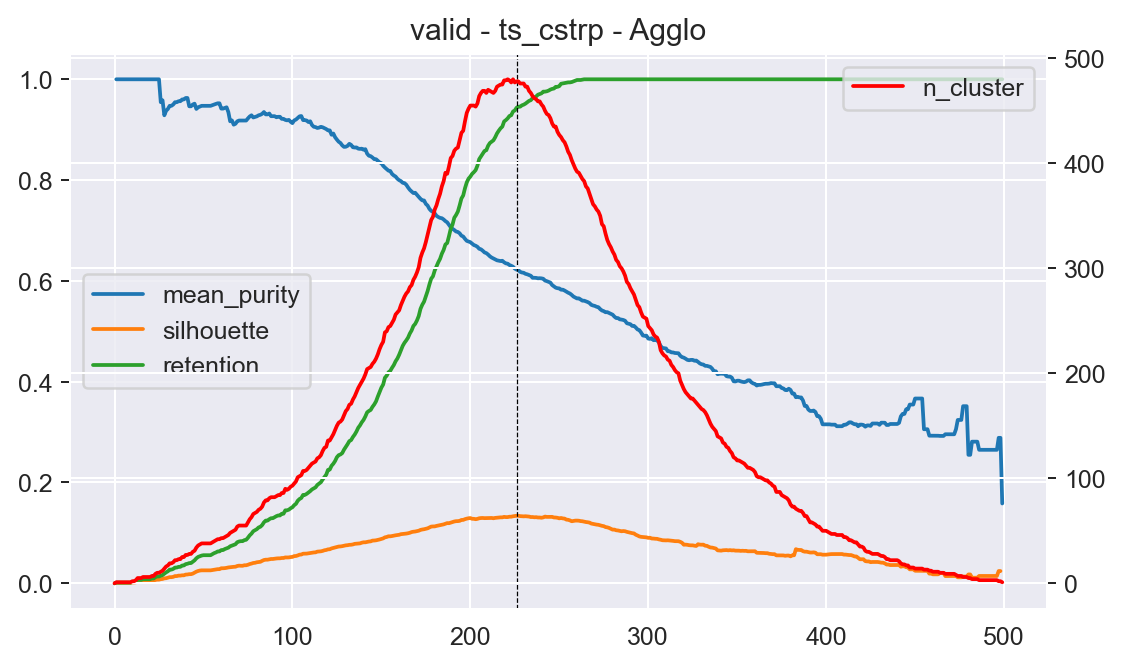

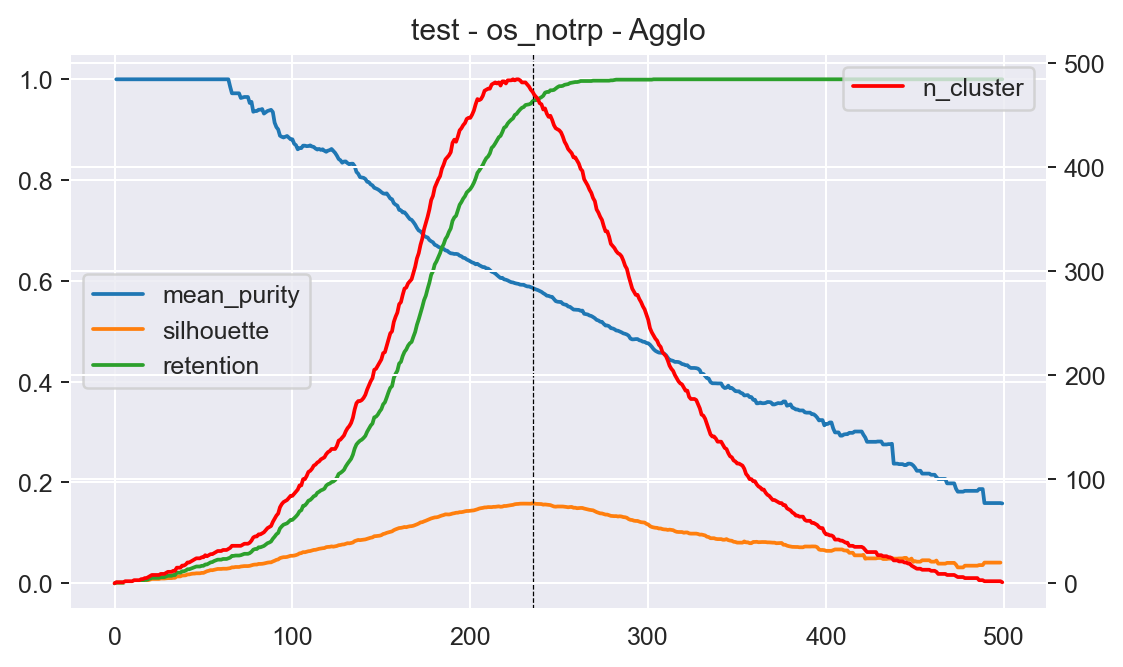

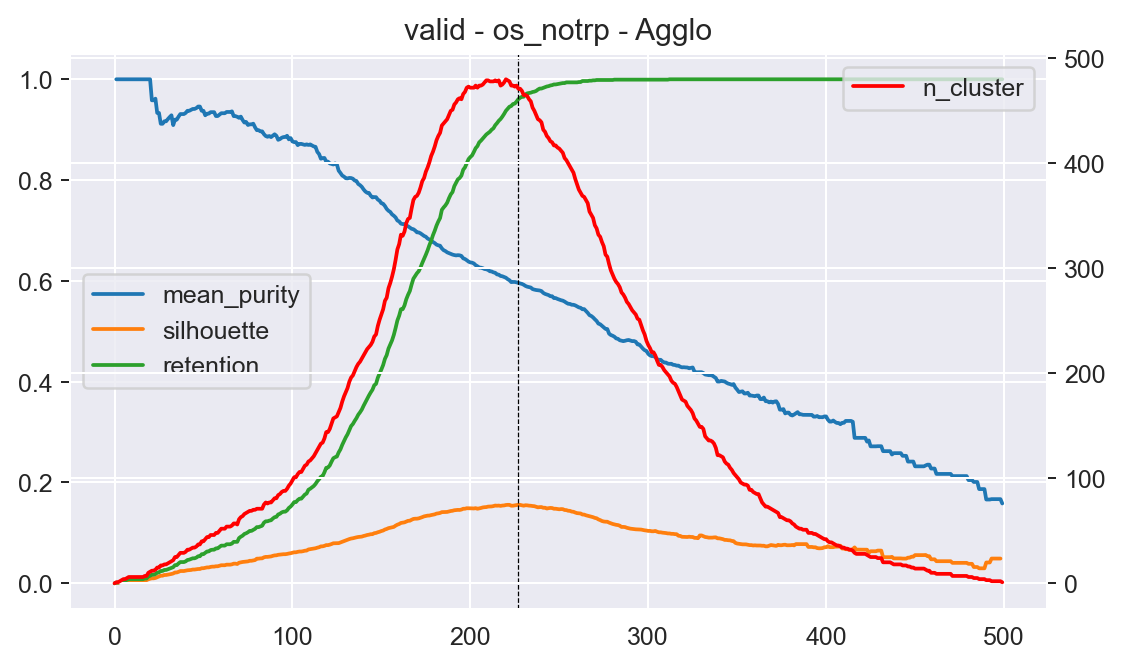

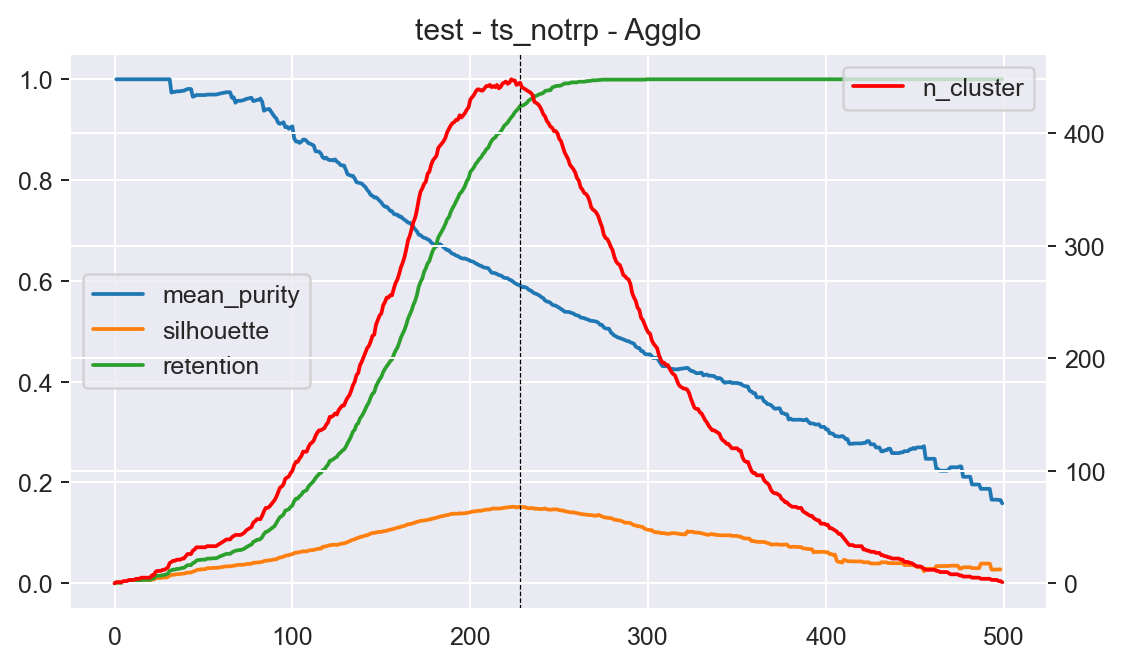

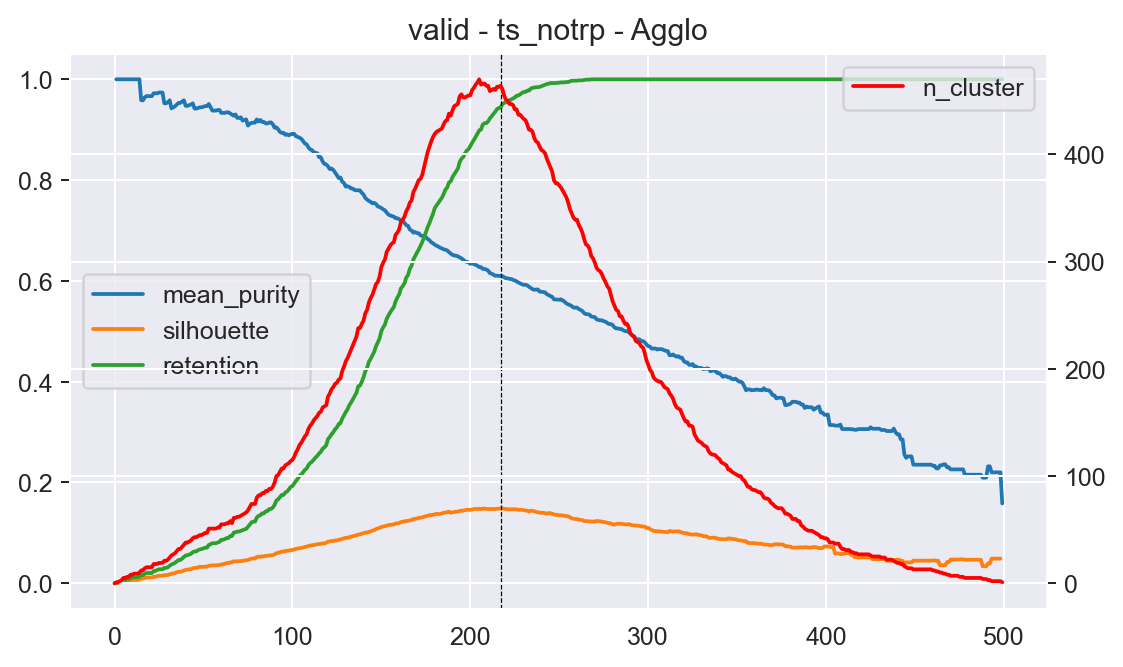

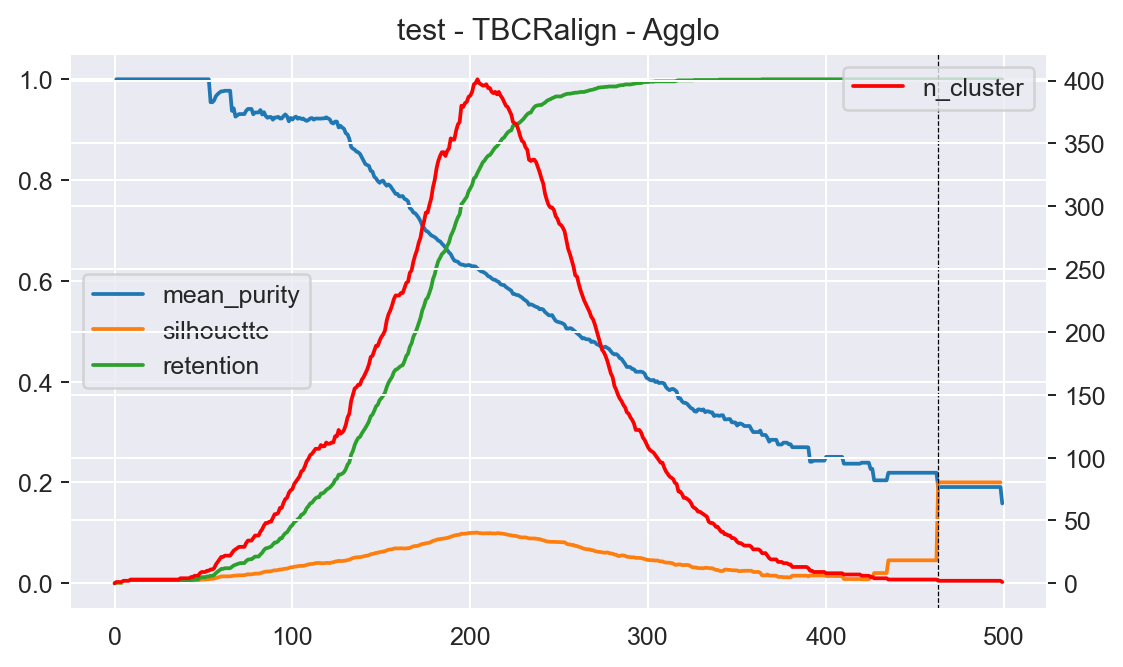

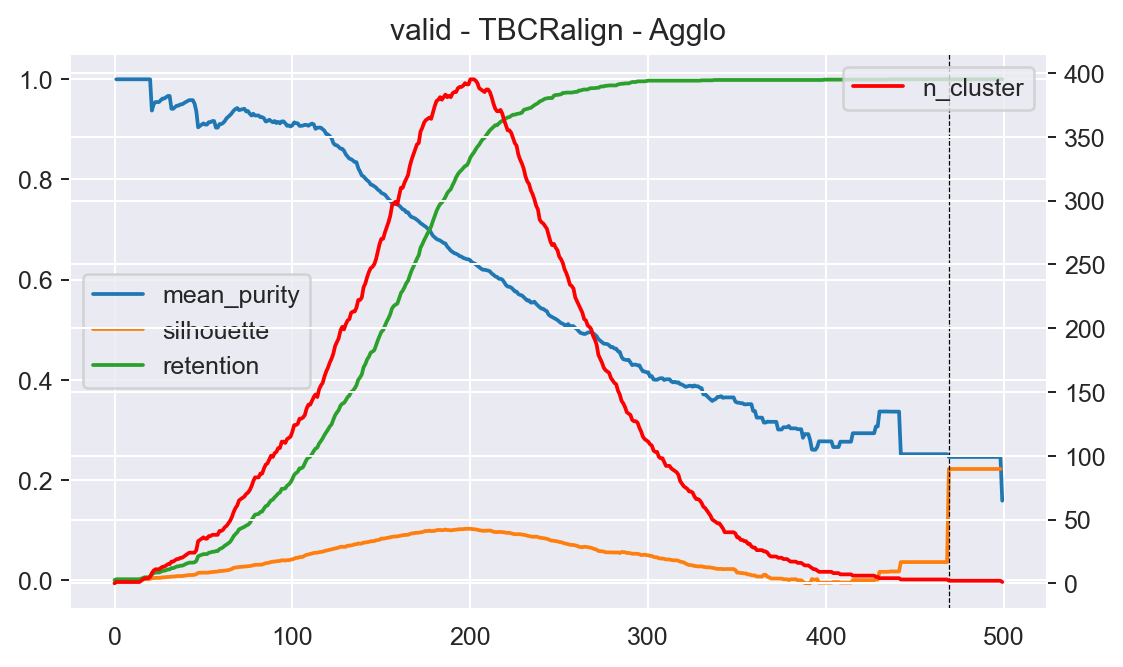

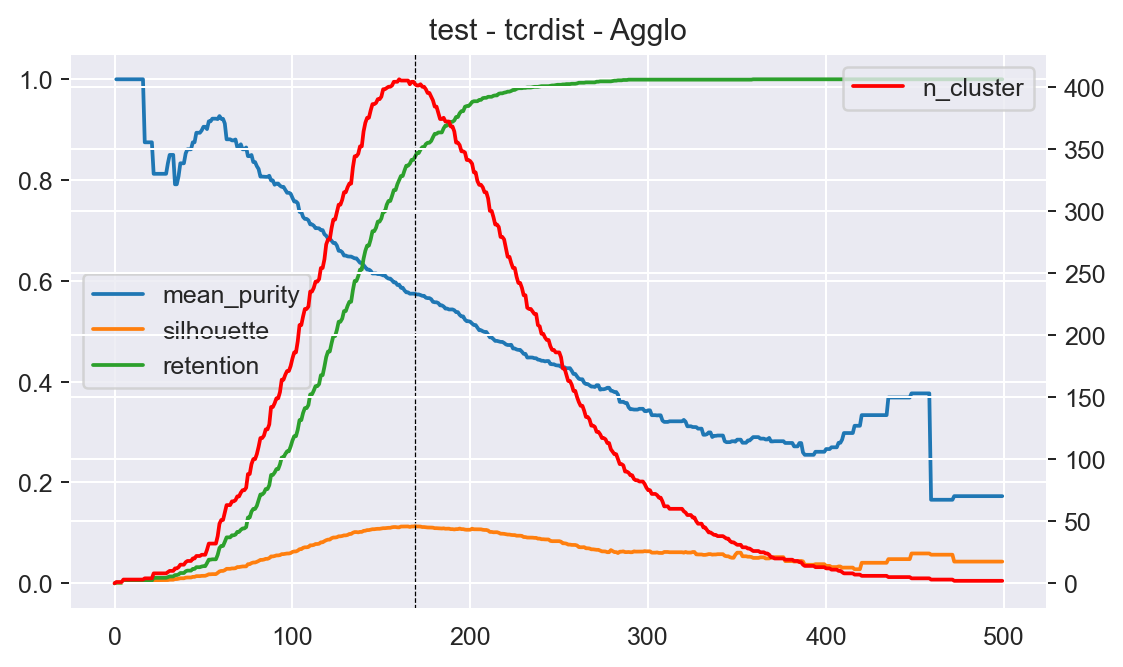

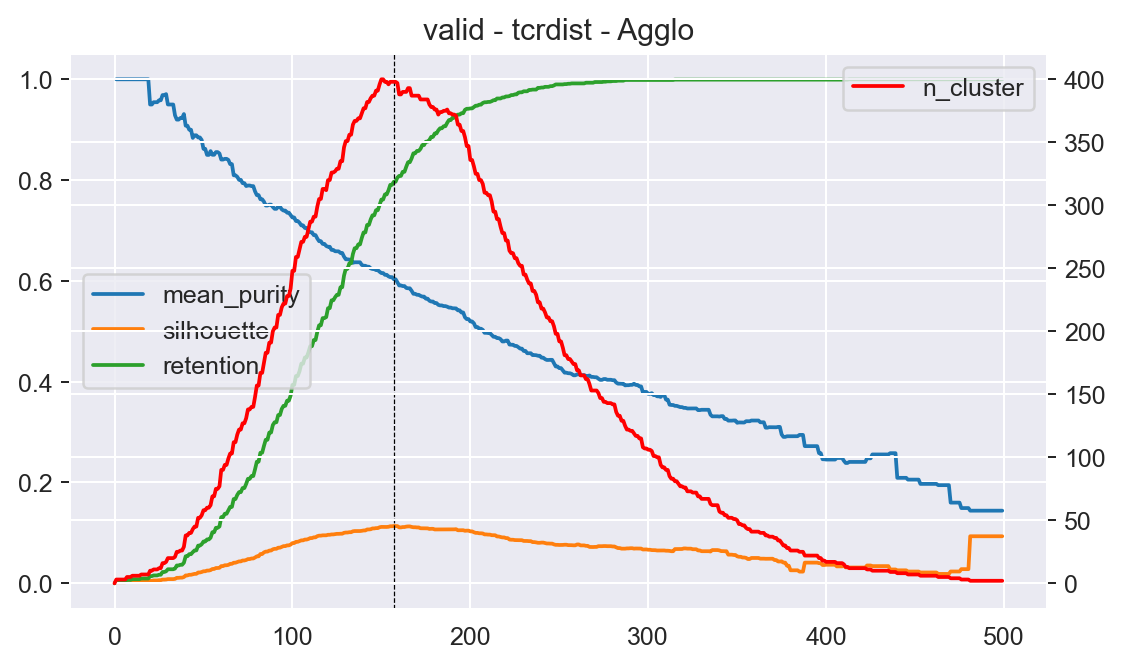

In [274]:
for input_type in all_results['input_type'].unique():
    for partition in all_results['partition'].unique():
        clusterfuck(all_results, input_type, 'Agglo', partition, fn=f'../output/240924_PeptideRedoClustering/MICRO_AVG_{input_type}_agglo_{partition}.png')

## Redo for Macro AVG : All 4 models and 2 baselines

In [263]:
from src.metrics import custom_silhouette_score as css

css(da, c.labels_, metric='precomputed', aggregation='micro'), css(da, c.labels_, metric='precomputed', aggregation='macro')

(0.46415925, 0.2322375)

In [270]:
def pipe_agglo(model, input_df, input_type, clustering, partition, aggregation='micro'):
    latent = get_latent_df(model, input_df)
    dm, da, feats, labs, enc_labs, lab_enc = get_distances_labels_from_latent(latent, index_col='raw_index')
    results = cluster_all_thresholds(da, feats, labs, enc_labs, lab_enc, n_jobs=8, silhouette_aggregation=aggregation)
    return results.assign(input_type=input_type, clustering=clustering, partition=partition)
    
def baseline_pipe_agglo(dm, input_type, clustering, partition, aggregation='micro'):
    da = dm.iloc[:len(dm), :len(dm)].values
    labels = dm['peptide'].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    results = cluster_all_thresholds(da, da, labels, encoded_labels, label_encoder, n_jobs=8, silhouette_aggregation=aggregation)
    return results.assign(input_type=input_type, clustering=clustering, partition=partition)
    


In [267]:
test_macro=pipe_agglo(os_cstrp, test, 'test', 'test', 'test', 'macro')

  0%|          | 0/500 [00:00<?, ?it/s]

In [271]:
os_cstrp_res = pd.concat([pipe_agglo(os_cstrp, test, 'os_cstrp', 'Agglo', 'test', aggregation='macro'),
                          pipe_agglo(os_cstrp, valid, 'os_cstrp', 'Agglo', 'valid', aggregation='macro')])
ts_cstrp_res = pd.concat([pipe_agglo(ts_cstrp, test, 'ts_cstrp', 'Agglo', 'test', aggregation='macro'),
                          pipe_agglo(ts_cstrp, valid, 'ts_cstrp', 'Agglo', 'valid', aggregation='macro')])
os_notrp_res = pd.concat([pipe_agglo(os_notrp, test, 'os_notrp', 'Agglo', 'test', aggregation='macro'),
                          pipe_agglo(os_notrp, valid, 'os_notrp', 'Agglo', 'valid', aggregation='macro')])
ts_notrp_res = pd.concat([pipe_agglo(ts_notrp, test, 'ts_notrp', 'Agglo', 'test', aggregation='macro'),
                          pipe_agglo(ts_notrp, valid, 'ts_notrp', 'Agglo', 'valid', aggregation='macro')])

tbcr_valid_results = baseline_pipe_agglo(tbcr_valid, 'TBCRalign', 'Agglo', 'valid', aggregation='macro')
tcrdist_valid_results = baseline_pipe_agglo(tcrdist_valid, 'tcrdist', 'Agglo', 'valid', aggregation='macro')
tbcr_test_results = baseline_pipe_agglo(tbcr_test, 'TBCRalign', 'Agglo', 'test', aggregation='macro')
tcrdist_test_results = baseline_pipe_agglo(tcrdist_test, 'tcrdist', 'Agglo', 'test', aggregation='macro')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [272]:
macro_vaes_results_test_valid = pd.concat([os_cstrp_res, ts_cstrp_res, os_notrp_res, ts_notrp_res])
macro_baseline_results = pd.concat([tbcr_valid_results, tcrdist_valid_results, tbcr_test_results, tcrdist_test_results])
macro_all_results = pd.concat([macro_vaes_results_test_valid, macro_baseline_results])
macro_all_results.to_csv('../output/240924_PeptideRedoClustering/17peps_valid_test_agglo_macro_avg_results.csv')

In [279]:
t=0.38982
dm_os_cstrp = make_dist_matrix(get_latent_df(os_cstrp, valid))
da_os_cstrp = dm_os_cstrp.iloc[:len(dm_os_cstrp), :len(dm_os_cstrp)].values
flat_da = da_os_cstrp.flatten()
flat_da = flat_da[flat_da!=0]
np.quantile(da_os_cstrp.flatten(), 0.995), np.quantile(flat_da, 0.995)

(0.32129606008529654, 0.32129931151866803)

In [292]:
all_results.query('input_type=="os_cstrp" and partition=="valid"').reset_index().loc[300:350]

index  threshold  n_cluster  n_singletons  n_cluster_over_70p  \
300    300    0.36296          4             1                   0   
301    301    0.36413          3             1                   0   
302    302    0.36529          3             1                   0   
303    303    0.36646          3             1                   0   
304    304    0.36763          2             1                   0   
305    305    0.36880          2             1                   0   
306    306    0.36996          2             1                   0   
307    307    0.37113          2             1                   0   
308    308    0.37230          2             1                   0   
309    309    0.37347          2             1                   0   
310    310    0.37464          2             1                   0   
311    311    0.37580          2             1                   0   
312    312    0.37697          2             1                   0   
313    313    0.37814          2             1                   0   
314    314    0.37931          2             1                   0   
315    315    0.38047          2             1                   0   
316    316    0.38164          2             1                   0   
317    317    0.38281          2             1                   0   
318    318    0.38398          2             1                   0   
319    319    0.38514          2             1                   0   
320    320    0.38631          2             1                   0   
321    321    0.38748          2             1                   0   
322    322    0.38865          2             1                   0   
323    323    0.38982          1             1                   0   
324    324    0.39098          1             1                   0   
325    325    0.39215          1             1                   0   
326    326    0.39332          1             1                   0   
327    327    0.39449          1             1                   0   
328    328    0.39565          1             1                   0   
329    329    0.39682          1             1                   0   
330    330    0.39799          1             1                   0   
331    331    0.39916          1             1                   0   
332    332    0.40032          1             1                   0   
333    333    0.40149          1             1                   0   
334    334    0.40266          1             1                   0   
335    335    0.40383          1             1                   0   
336    336    0.40500          1             1                   0   
337    337    0.40616          1             1                   0   
338    338    0.40733          1             1                   0   
339    339    0.40850          1             1                   0   
340    340    0.40967          1             1                   0   
341    341    0.41083          1             1                   0   
342    342    0.41200          1             1                   0   
343    343    0.41317          1             1                   0   
344    344    0.41434          1             1                   0   
345    345    0.41550          1             1                   0   
346    346    0.41667          1             1                   0   
347    347    0.41784          1             1                   0   
348    348    0.41901          1             1                   0   
349    349    0.42018          1             1                   0   
350    350    0.42134          1             1                   0   

     mean_purity  min_purity  max_purity  mean_coherence  min_coherence  ...  \
300     0.211822    0.143389    0.278788        0.237490       0.234641  ...   
301     0.212227    0.143389    0.266019        0.239622       0.234641  ...   
302     0.212227    0.143389    0.266019        0.239622       0.234641  ...   
303     0.212227    0.143389    0.266019    

In [278]:
all_results.loc[[all_results.query('input_type=="os_cstrp" and partition=="valid"')['silhouette'].idxmax()]]

threshold  n_cluster  n_singletons  n_cluster_over_70p  mean_purity  \
323    0.30247         44             1                   4     0.336030   
323    0.38982          1             1                   0     0.157823   
323    0.91802        195             0                  24     0.432918   
323    0.93173        178             0                  24     0.442553   
323    0.79874        179             0                  14     0.429157   
323    0.80912        167             0                  17     0.426571   
323    0.87881        169             0                  21     0.425004   
323    0.89282        147             0                  18     0.433466   
323    0.21603         72             4                   7     0.387841   
323  218.18838         73             1                   6     0.346884   
323    0.21848         66             3                   3     0.351493   
323  229.72745         55             1                   3     0.311535   

     min_purity  max_purity  mean_coherence  min_coherence  max_coherence  \
323    0.117647    1.000000        0.203668       0.142179       0.222075   
323    0.157823    0.157823        0.244836       0.244836       0.244836   
323    0.153846    1.000000        0.647133       0.428358       0.773417   
323    0.153846    1.000000        0.663232       0.447016       0.792721   
323    0.142857    1.000000        0.556111       0.349681       0.651302   
323    0.142857    1.000000        0.557853       0.386173       0.675334   
323    0.142857    1.000000        0.601817       0.374395       0.742906   
323    0.125000    1.000000        0.616473       0.401188       0.745426   
323    0.156250    1.000000        0.158053       0.092798       0.188521   
323    0.157895    1.000000      140.392384     106.680952     177.733333   
323    0.120000    0.941176        0.159430       0.093832       0.194135   
323    0.142857    1.000000      144.359699     103.666667     173.035714   

     ...  min_cluster_size  max_cluster_size  silhouette   ch_index  db_index  \
323  ...               2.0             131.0    0.048227   8.826995  3.520064   
323  ...            1470.0            1470.0    0.464159   2.027157  0.698310   
323  ...               2.0              50.0    0.087948   5.124596  2.266846   
323  ...               2.0              66.0    0.075615   5.284341  2.333955   
323  ...               2.0              55.0    0.099001   5.994629  2.258235   
323  ...               2.0              49.0    0.092444   6.267282  2.339952   
323  ...               2.0              71.0    0.101978   6.405178  2.241423   
323  ...               2.0              80.0    0.097198   7.014642  2.378192   
323  ...               2.0              79.0    0.029851  13.575776  2.807700   
323  ...               3.0              64.0    0.068737  13.700042  3.095087   
323  ...               2.0              93.0    0.035698  15.101834  3.011802   
323  ...               3.0              82.0    0.061004  16.332783  3.144196   

          ARI  retention  input_type clustering partition  
323  0.119619   0.999320    os_cstrp      Agglo      test  
323 -0.000215   0.999320    os_cstrp      Agglo     valid  
323  0.053401   1.000000    ts_cstrp      Agglo      test  
323  0.063192   1.000000    ts_cstrp      Agglo     valid  
323  0.027393   1.000000    os_notrp      Agglo      test  
323  0.025678   1.000000    os_notrp      Agglo     valid  
323  0.051729   1.000000    ts_notrp      Agglo      test  
323  0.050618   1.000000    ts_notrp      Agglo     valid  
323  0.066633   0.997281   TBCRalign      Agglo     valid  
323  0.030843   0.999320     tcrdist      Agglo     valid  
323  0.061629   0.997959   TBCRalign      Agglo      test  
323  0.035350   0.999320     tcrdist      Agglo      test  

[12 rows x 21 columns]

In [ ]:
def clusterfuck(df, input_type, clustering, partition, fn=None):
    f,ax = plt.subplots(1,1,figsize=(7,4))
    tmp = df.query('input_type==@input_type and clustering==@clustering and partition==@partition').reset_index(drop=True)

    tmp[['mean_purity', 'silhouette', 'retention']].plot(ax=ax)
    ax2 = ax.twinx()
    tmp[['n_cluster']].plot(ax=ax2, c='r')
    ax.axvline(tmp['silhouette'].idxmax(),
              ls='--', lw=0.5, c='k')
    ax.legend(loc='center left')
    ax.set_title(f'{partition} - {input_type} - {clustering}')
    if fn is not None:
        f.savefig(fn, dpi=200, bbox_inches='tight')

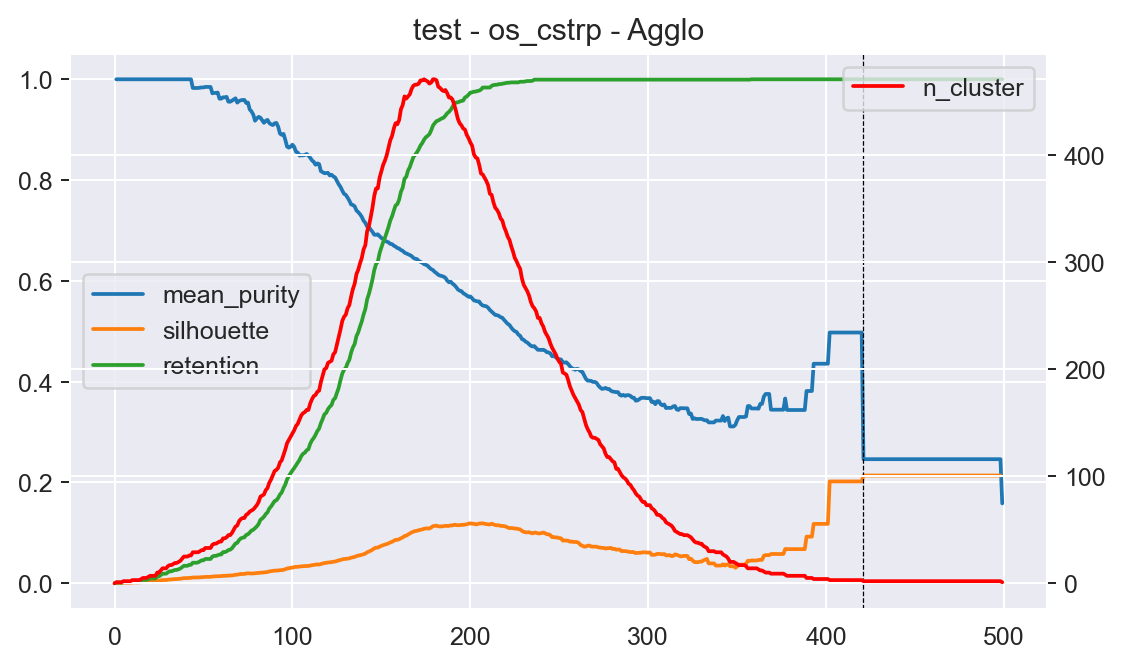

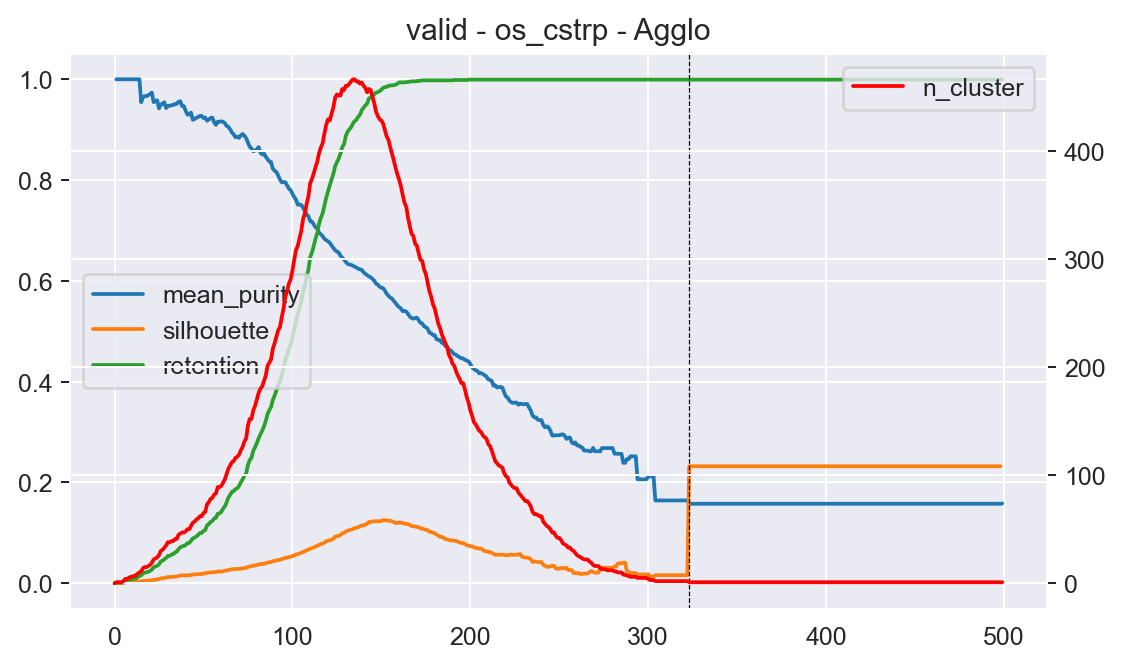

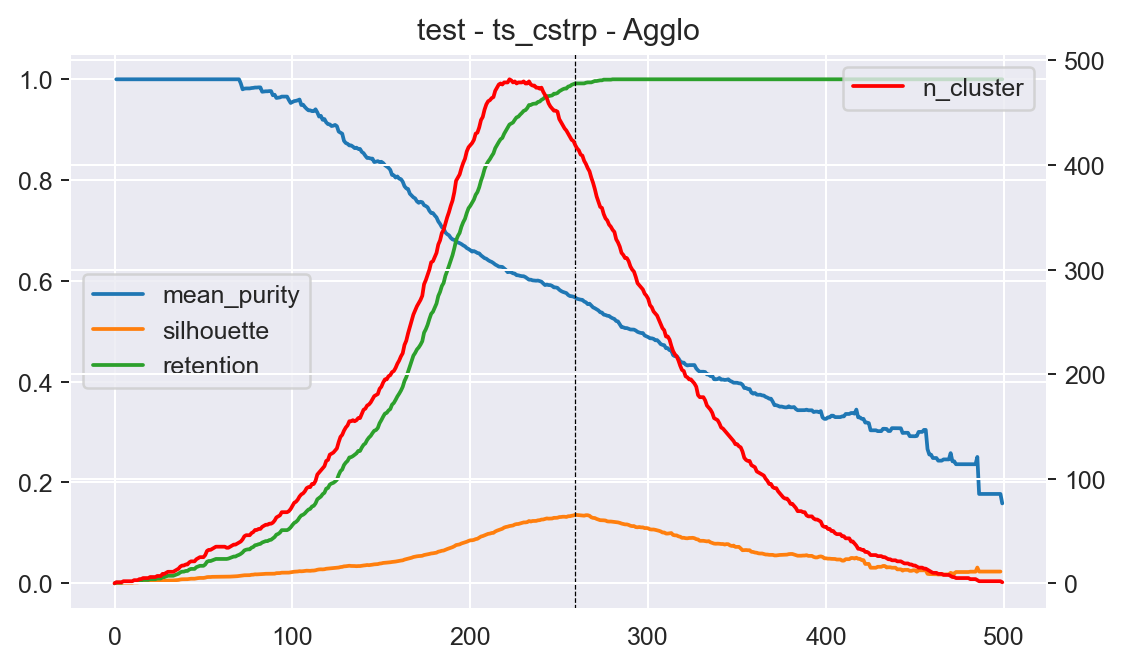

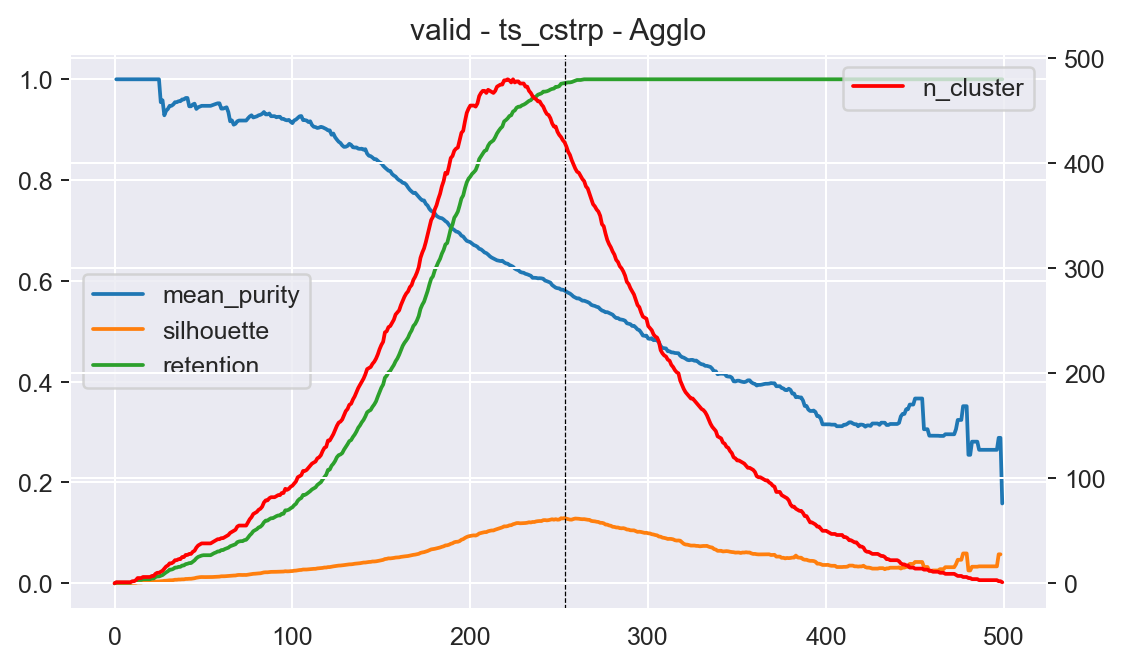

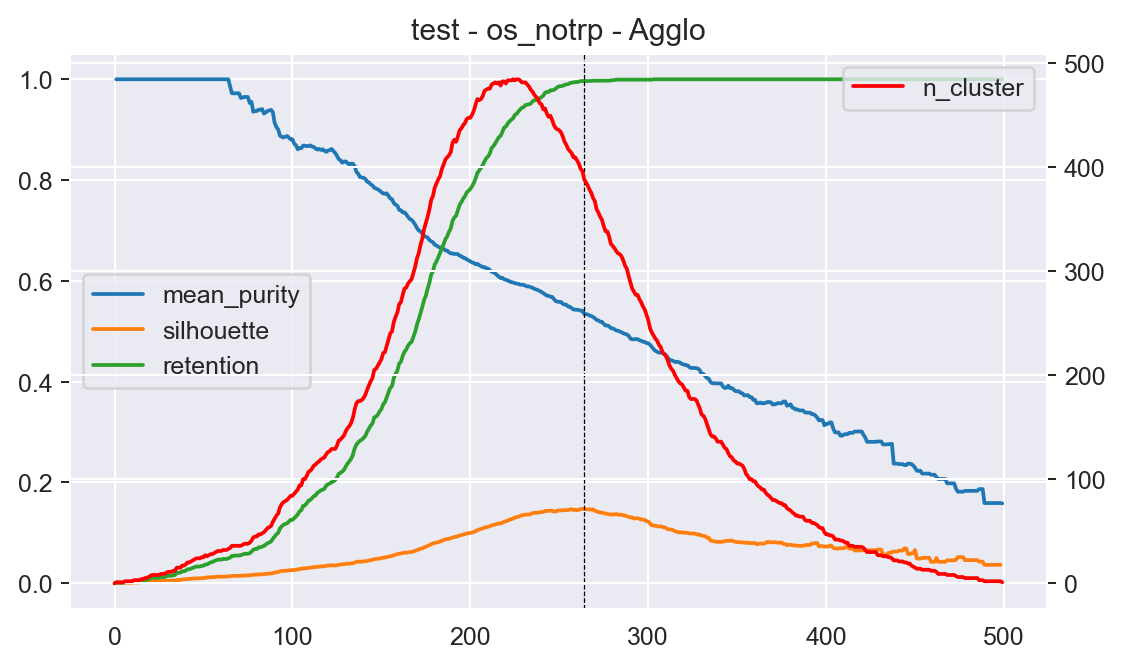

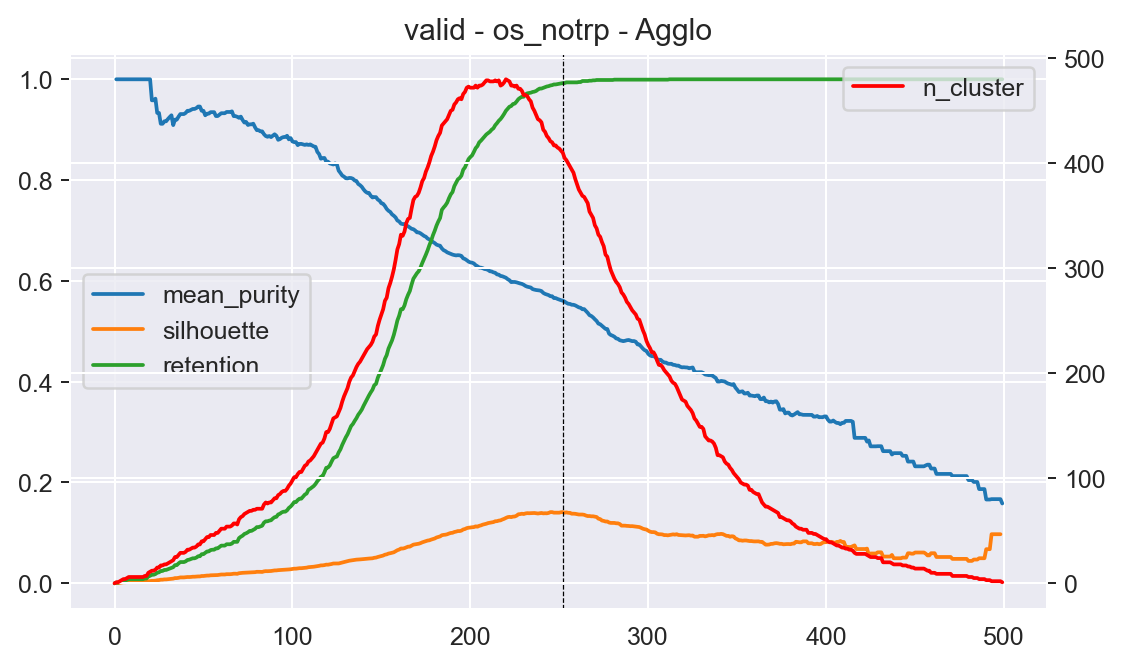

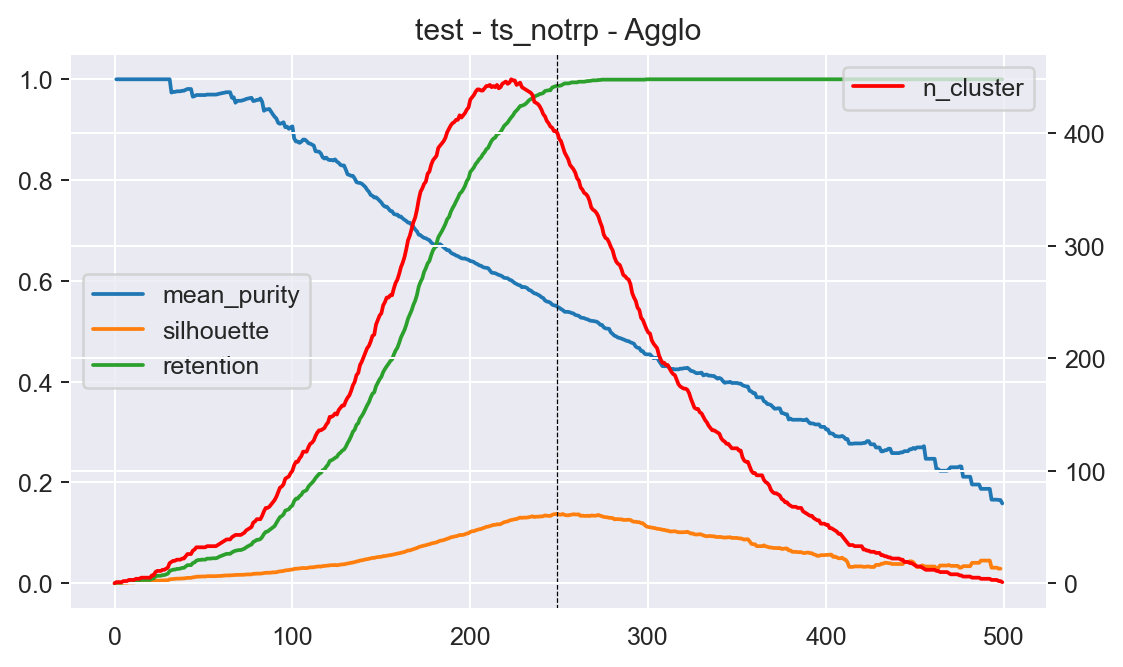

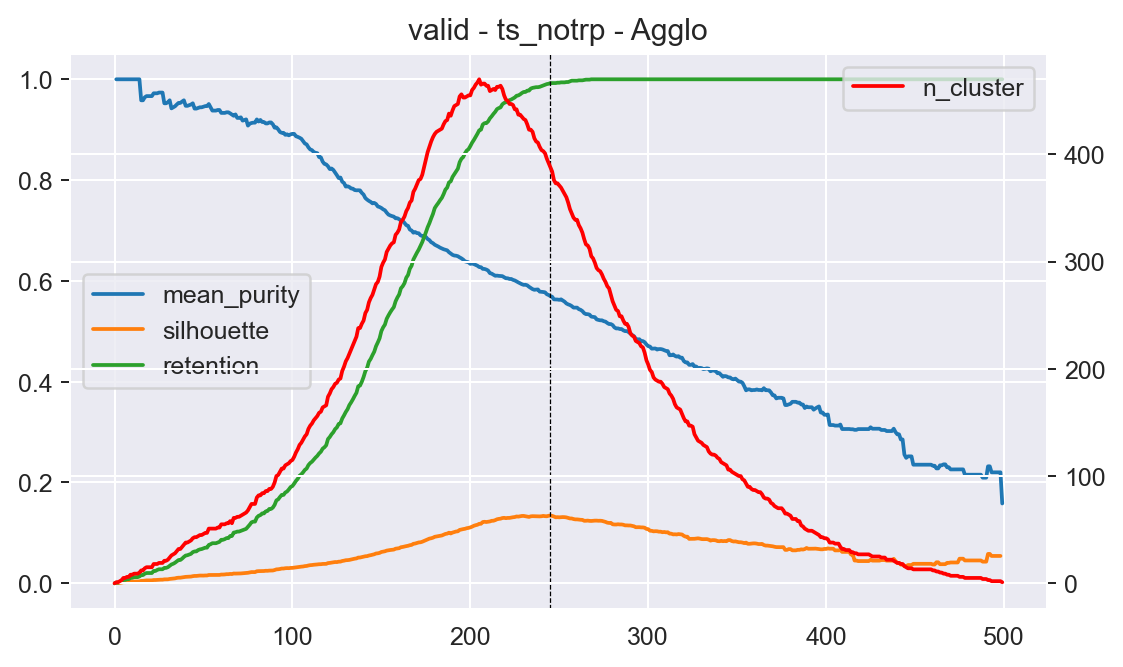

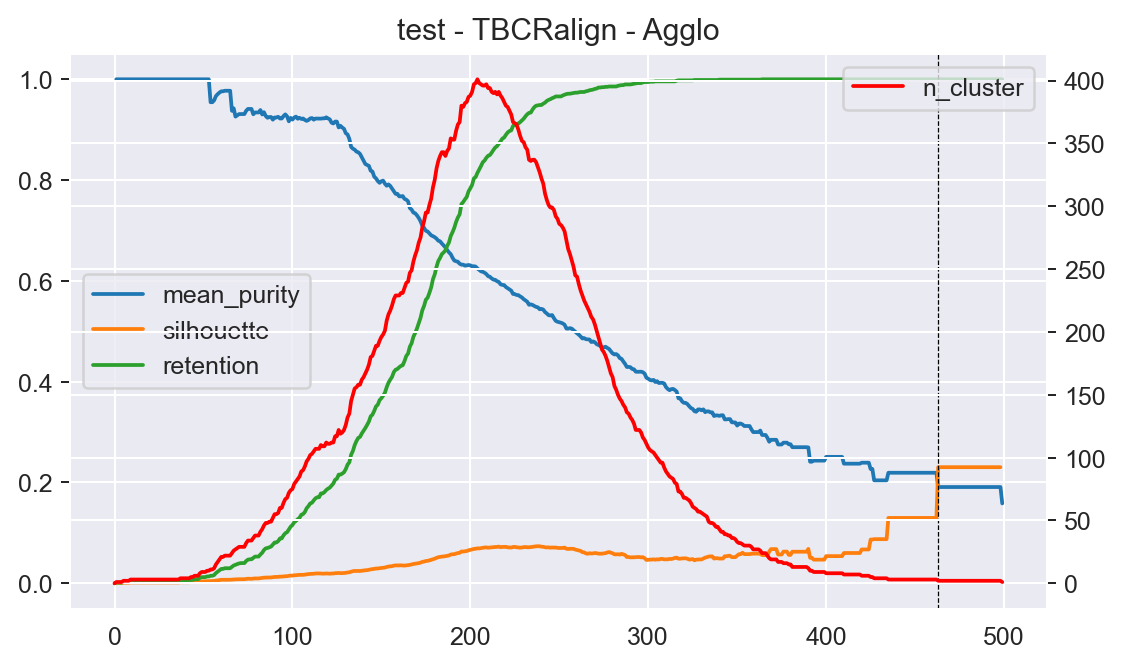

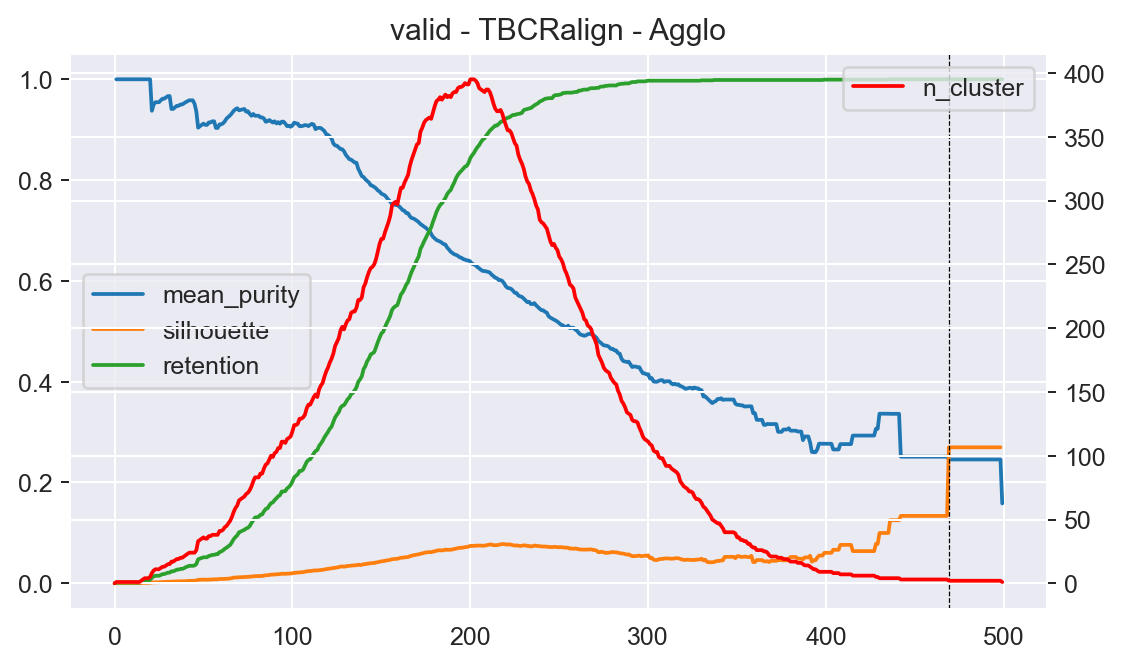

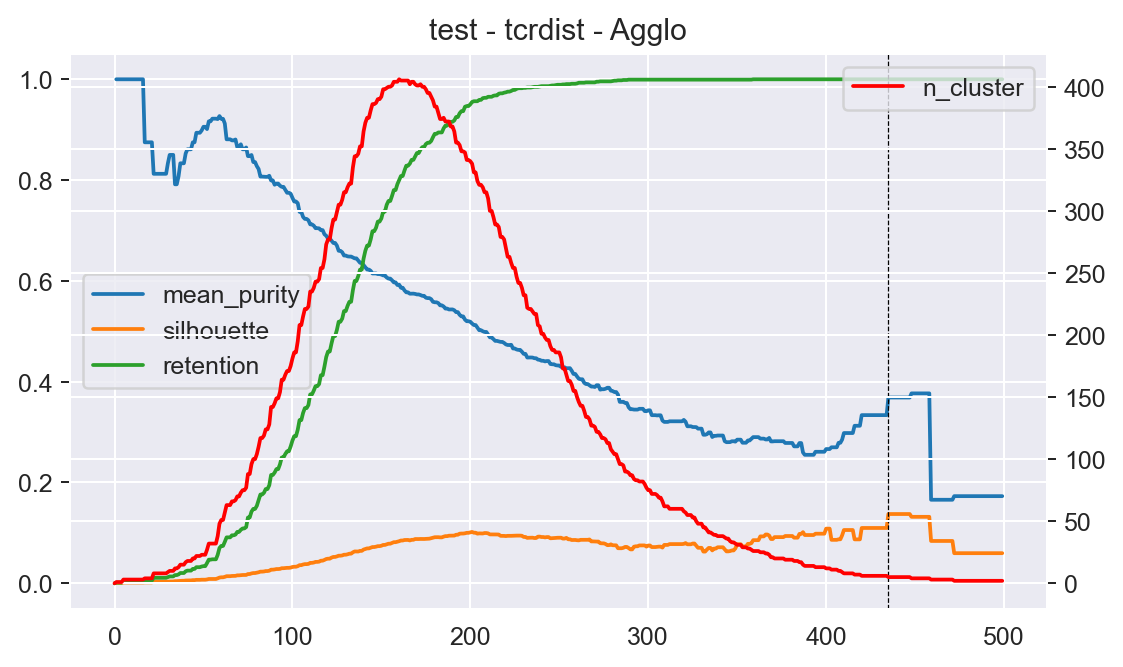

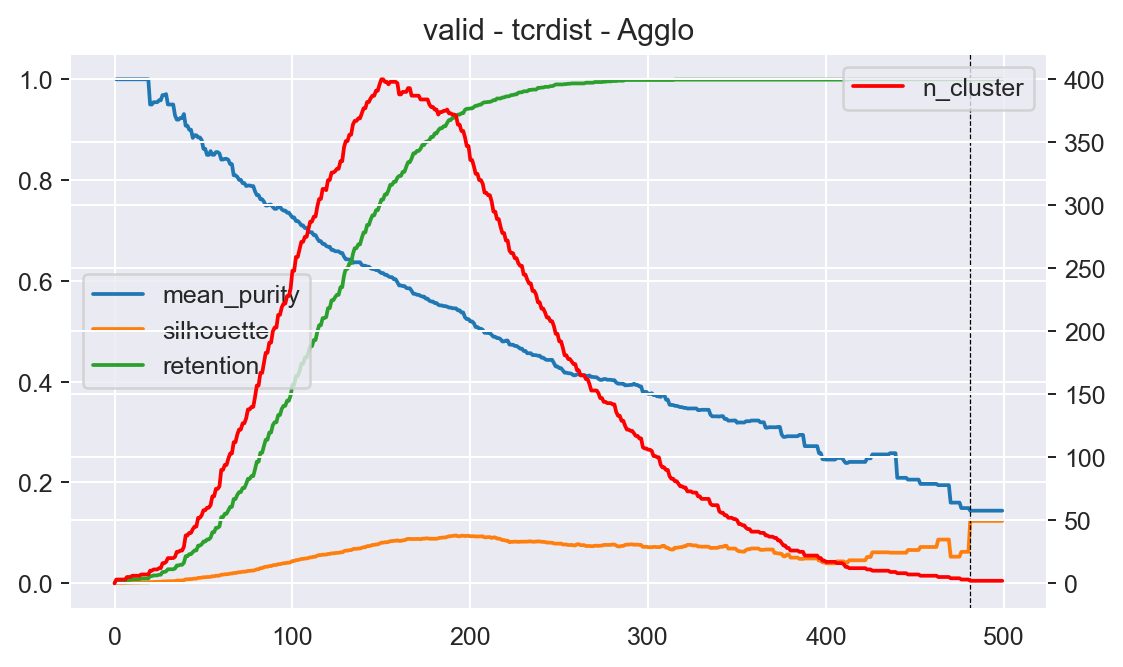

In [273]:
for input_type in macro_all_results['input_type'].unique():
    for partition in macro_all_results['partition'].unique():
        clusterfuck(macro_all_results, input_type, 'Agglo', partition, fn=f'../output/240924_PeptideRedoClustering/MACRO_AVG_{input_type}_agglo_{partition}.png')

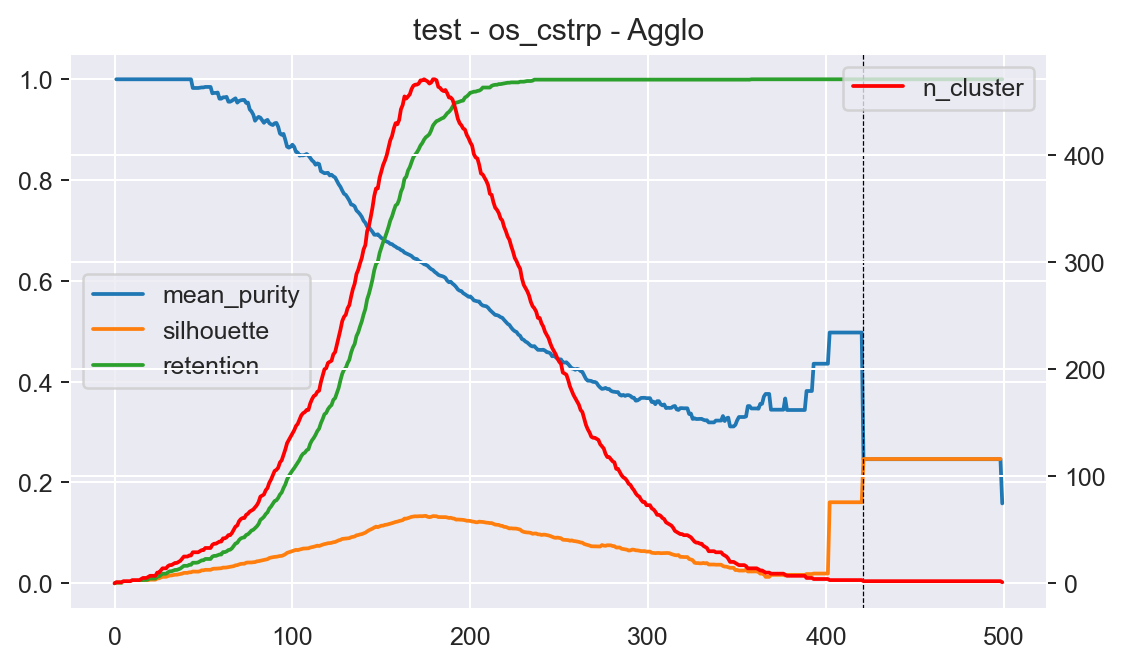

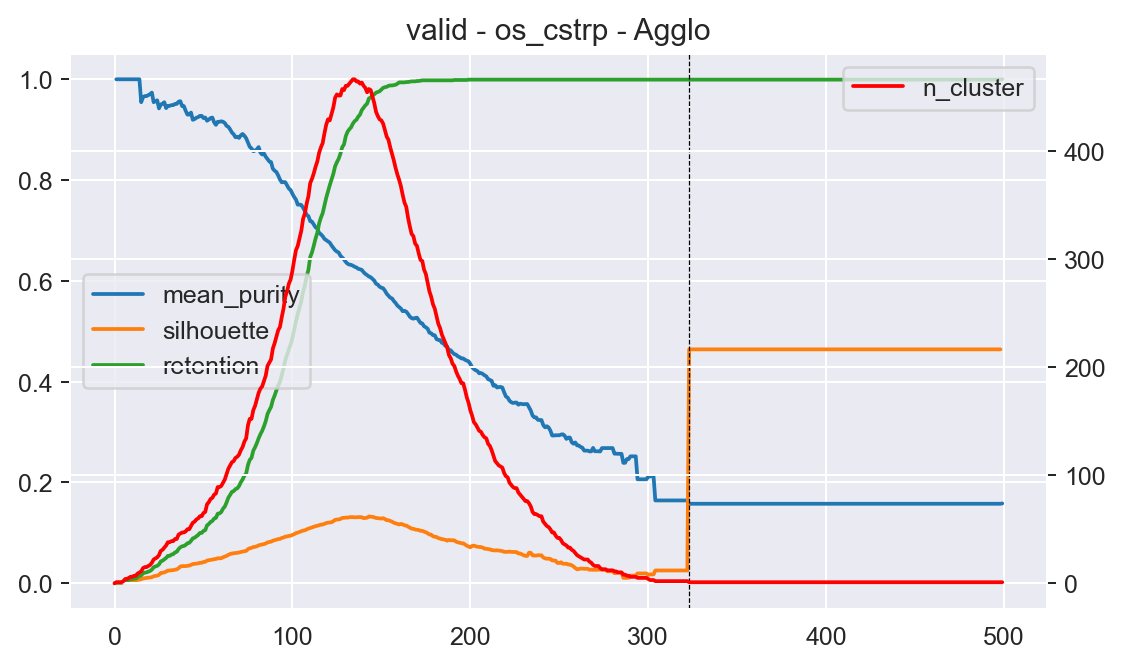

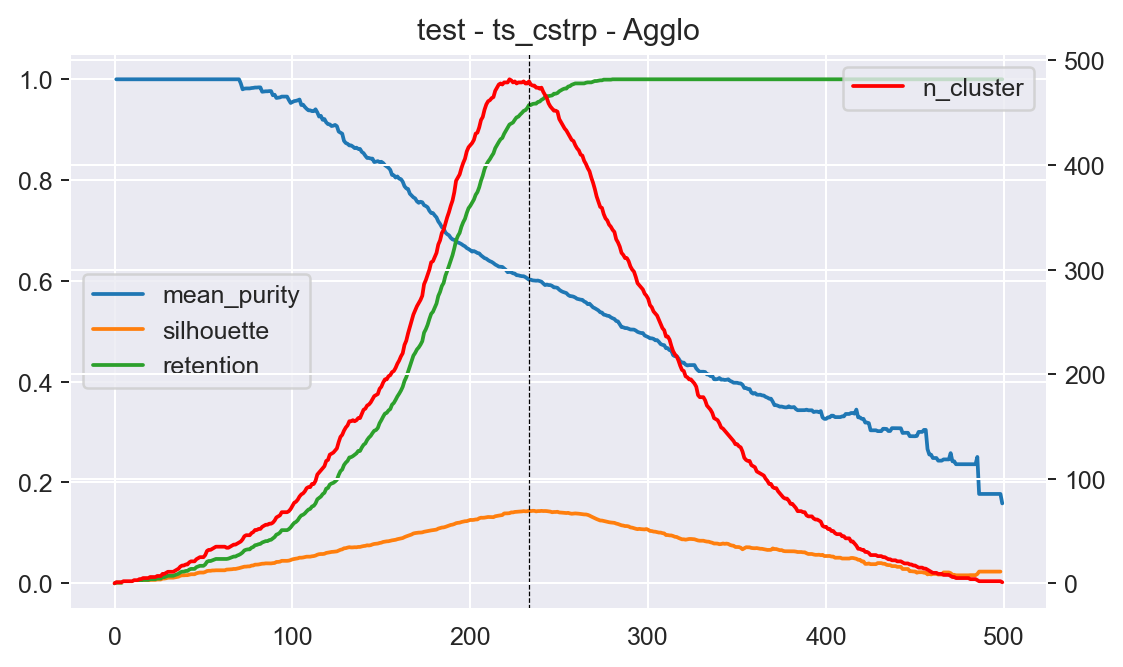

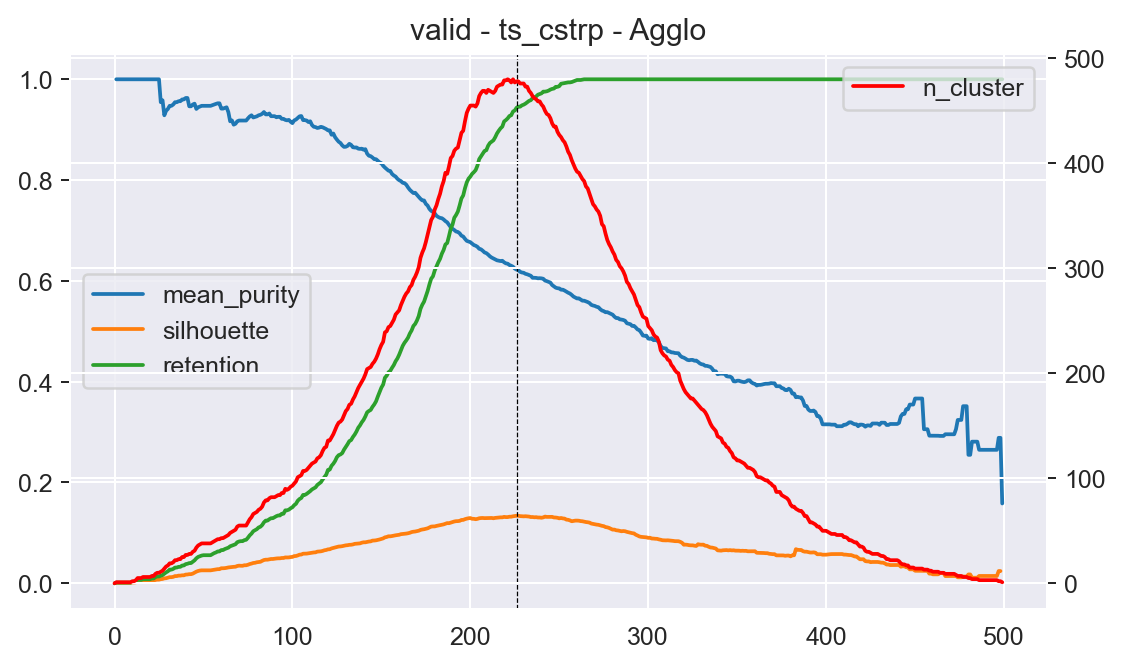

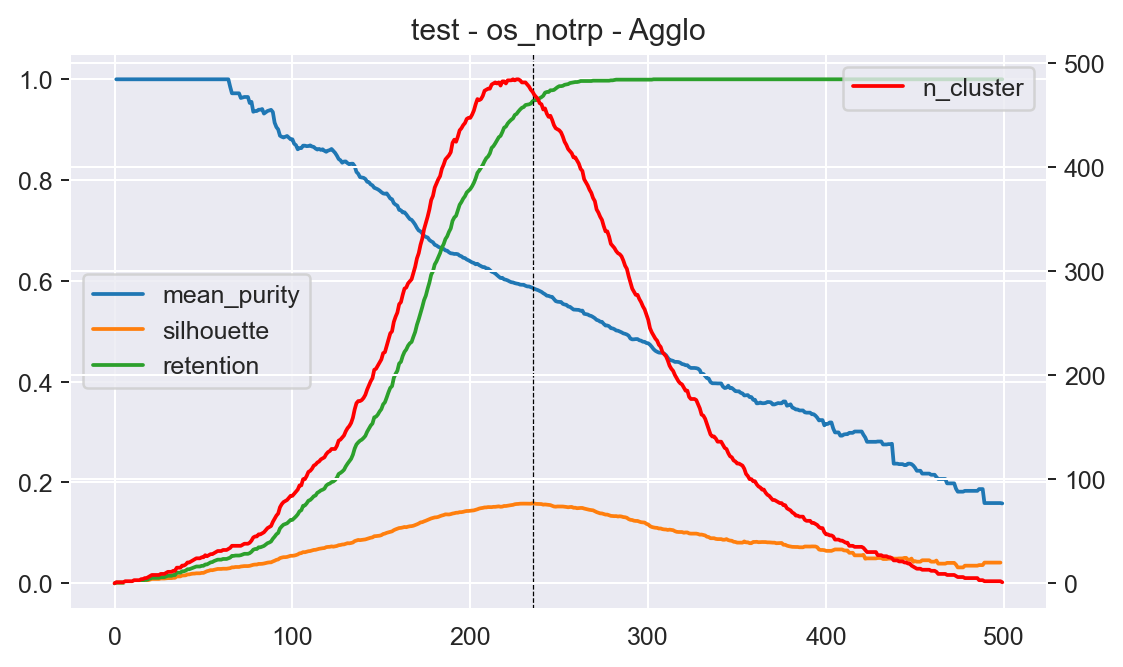

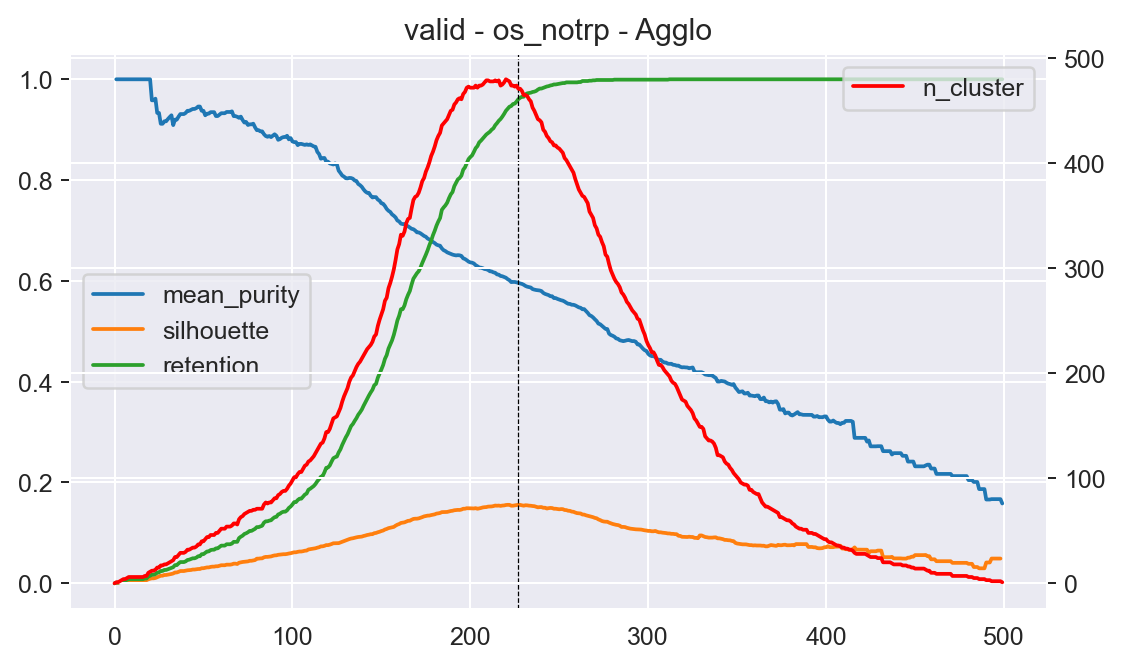

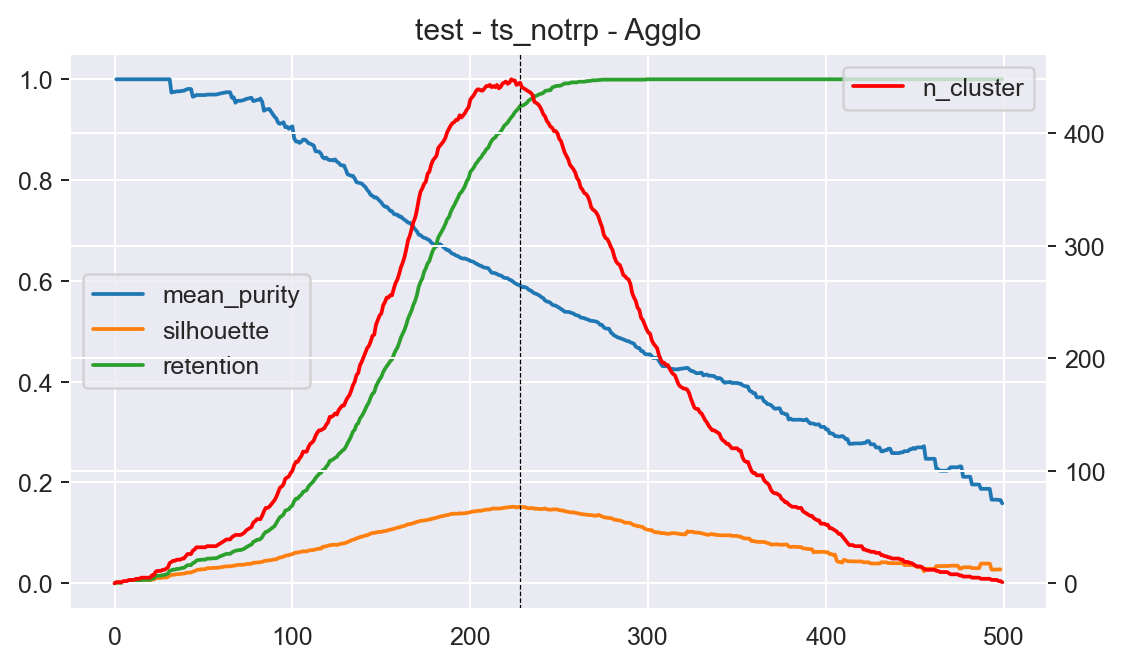

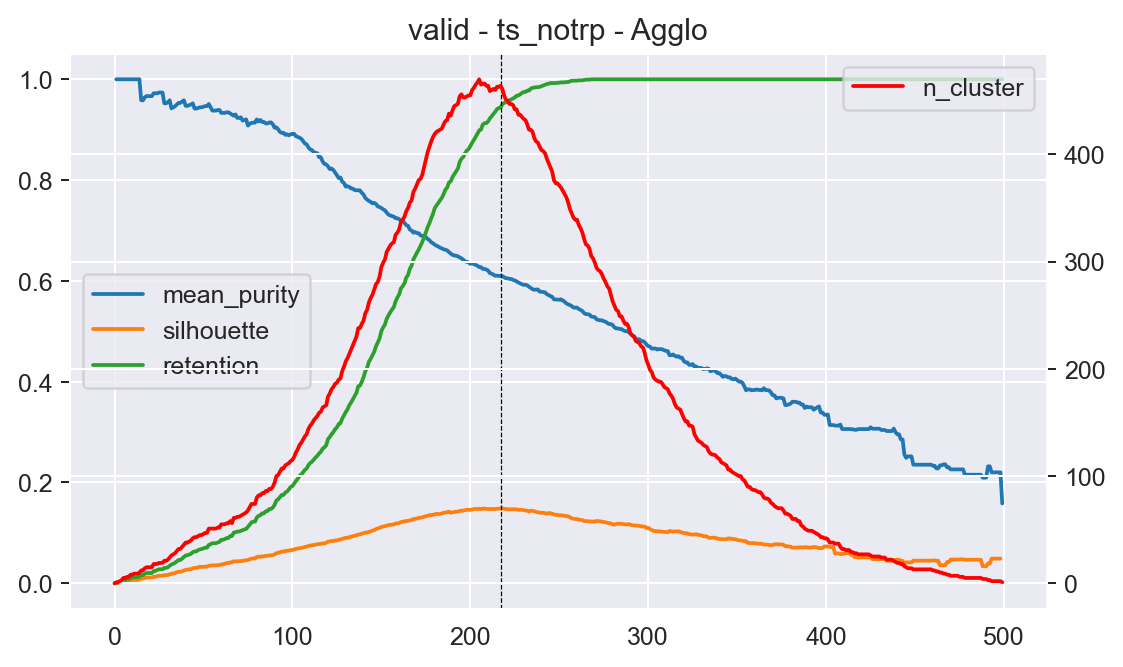

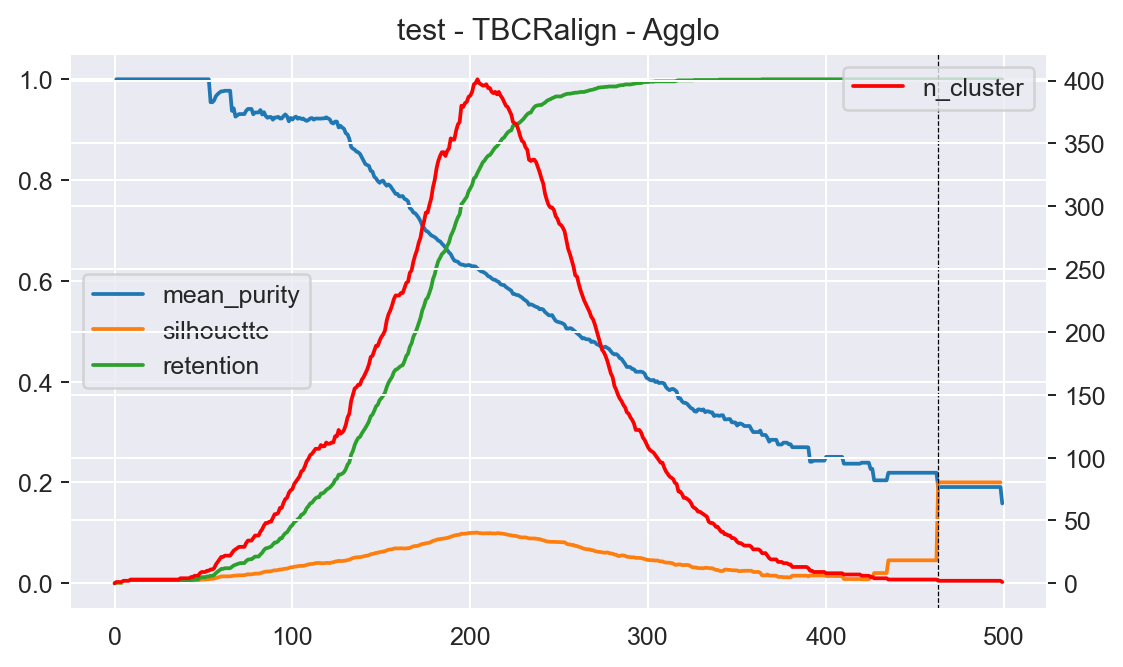

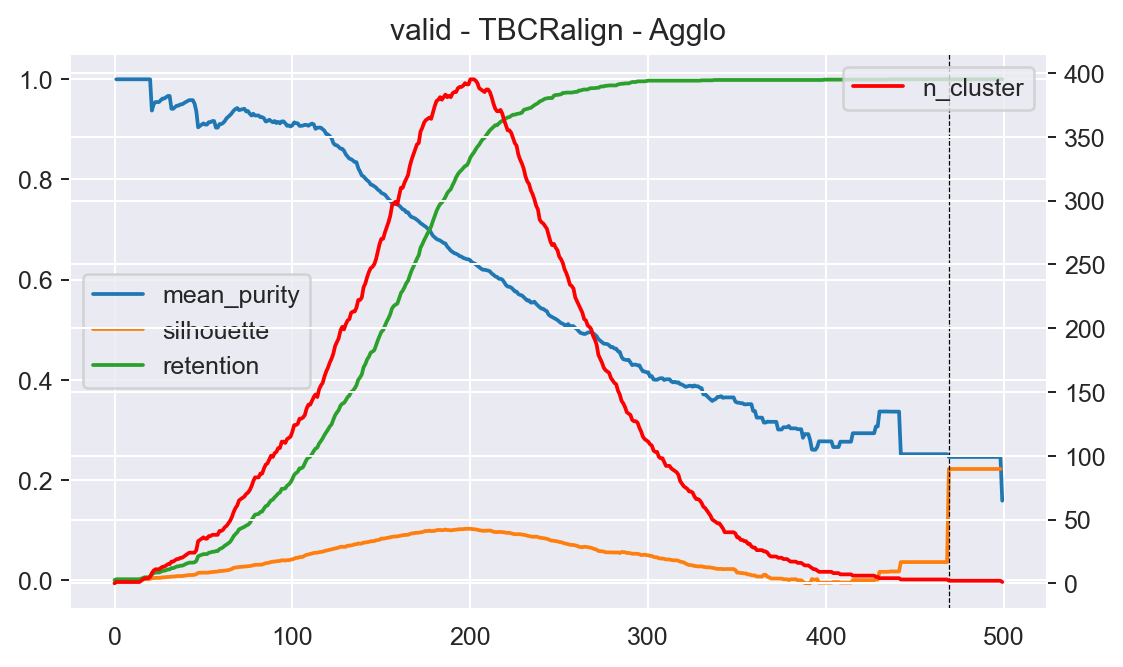

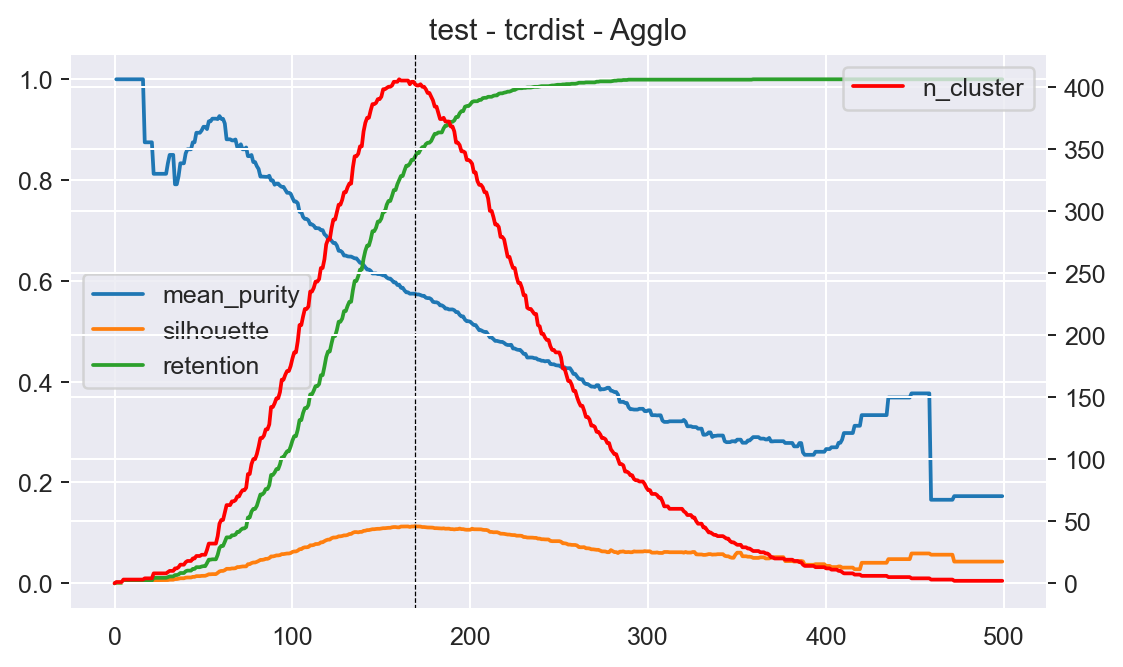

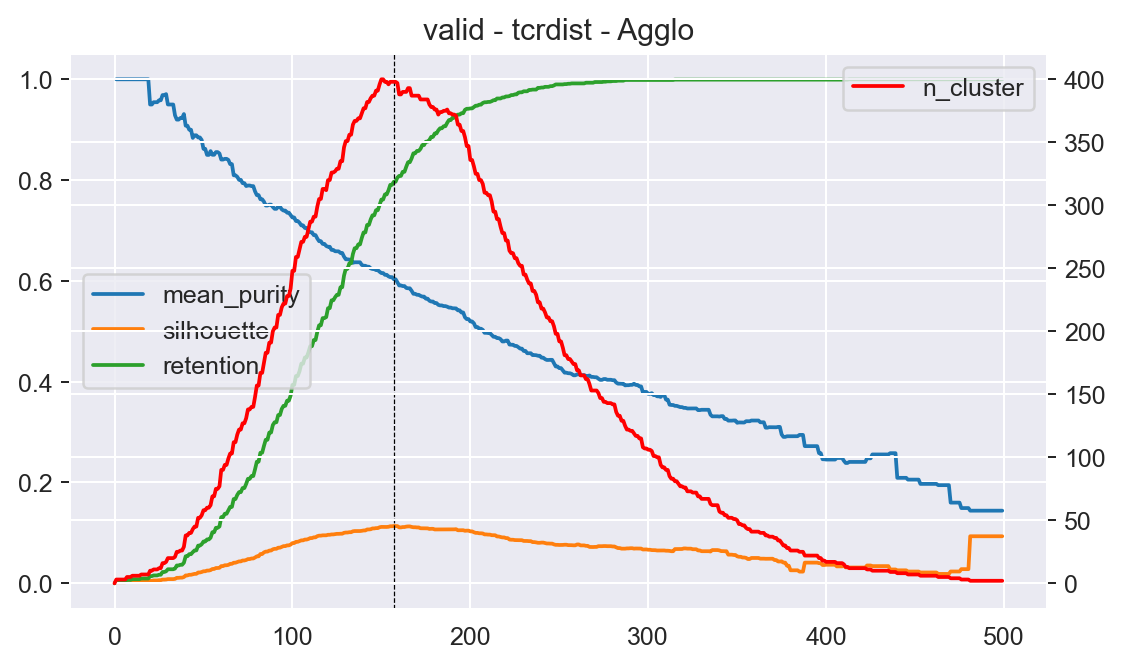

In [274]:
for input_type in all_results['input_type'].unique():
    for partition in all_results['partition'].unique():
        clusterfuck(all_results, input_type, 'Agglo', partition, fn=f'../output/240924_PeptideRedoClustering/MICRO_AVG_{input_type}_agglo_{partition}.png')

## Checking TBCRalign outlier

In [298]:
tmp=all_results.query('input_type=="TBCRalign" and partition=="valid"').reset_index(drop=True)
tmp.loc[tmp['silhouette'].idxmax()]

threshold               0.30134
n_cluster                     2
n_singletons                  0
n_cluster_over_70p            0
mean_purity            0.245686
min_purity             0.158038
max_purity             0.333333
mean_coherence         0.176003
min_coherence          0.164512
max_coherence          0.187493
mean_cluster_size         735.5
min_cluster_size            3.0
max_cluster_size         1468.0
silhouette             0.221685
ch_index              22.753235
db_index               0.567592
ARI                   -0.000256
retention                   1.0
input_type            TBCRalign
clustering                Agglo
partition                 valid
Name: 469, dtype: object

In [304]:
tbcr_da_valid = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values
labels = tbcr_valid['peptide'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
c = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=0.30134)
c.fit(tbcr_da_valid)
# cluster_single_threshold(tbcr_da_valid, tbcr_da_valid, labels, encoded_labels, label_encoder, threshold=0.30134)
np.where(c.labels_==1)[0]

array([  43,  237, 1310])

In [310]:
valid_dm.iloc[[943]]

TISGTDYGLTSNIQSQGGSEKLVSGHDTYYEEEEASSLRDGSEAF  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                       0.931949   

                                                    NIATNDYGYKTKLVGDGSNYQLISGHATFQNNGVASSWGGGSHYGYT  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                         1.095329   

                                                    NSMFDYISSIKDKAASARGQAGTALISGDLSYYNGEEASSGPGGGAF  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                         1.145068   

                                                    NYSPAYIRENEKEAIDTGGFKTIMNHNSSASEGTASSGTDSNQPQH  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                        1.022337   

                                                    TRDTTYYRNSFDEQNALSEAYAGGTSYGKLTSGHDTYYEEEEASSLRDGSEAF  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                           0.834891       

                                                    DSASNYIRSNVGEAASWVTGGGNKLTMNHEYSVGAGIASSYDSELNNEQF  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                           0.881333    

                                                    VGISALSSGKAGSYSGGGADGLTSGHNTYYREEEASSLEAGYRDTDTQY  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                           1.020316   

                                                    TISGTDYGLTSNICQDSGGSNYKLTSGHKSYYEKEEASSLRITGTGGVYEQY  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                           1.127796      

                                                    TSGFNGNVLDGLAPNSGGYQKVTSNHLYFYNNEIASSPGPETGELF  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                        1.051593   

                                                    ATGYPSATKADDKALNGNNRLAPRHDTFYEKMQASSLTGTPHQRLAKNIQY  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                           1.094986     

                                                    ...  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...  ...   

                                                    NSASQSVYSSGVVNAGGGADGLTMNHEYSVGAGIASSYPGQPQH  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                      1.022565   

                                                    VSGLRGLYSAGEEAVHTDNDYKLSMGHRAYSYEKLASSQARGGYEQY  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                         0.989134   

                                                    NSASQSVYSSGVVFNFNKFYKGHSHLQKENIASSPDGGHSTDTQY  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                       1.023683   

                                                    NSASDYIRSNMDKAENEVGSQGNLISGHTAFQGTGAASSFYAGSTNEQF  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...                                           0.956349   

                                                      peptide  partition  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...  GILGFVFTL          0   

                                                    binder  origin  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...       1     10x   

                                                    original_peptide  \
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...         GILGFVFTL   

                                                     raw_index  
TTSDRLLSNGAVAVVRGISRWHQNAGGTSYGKLTLNHDASQIVNDAS...  ITRAP_1738  

[1 rows x 1477 columns]

In [312]:
print(tbcr_da_valid.max())
flat_da = tbcr_da_valid.flatten()
flat_da = flat_da[flat_da!=0]
np.quantile(tbcr_da_valid.flatten(), 0.995), np.quantile(flat_da, 0.995)

0.3188611666666666


(0.25054864999999976, 0.25055648958333293)

In [317]:
tbcr_valid.iloc[[43, 237, 1310]].drop(columns=['peptide','original_peptide','binder','partition','raw_index']).max().sort_values(ascending=False).head(25)

6454    0.318861
8530    0.318344
3530    0.314628
6307    0.313792
3770    0.312396
2571    0.311013
9428    0.308087
3468    0.307455
6261    0.305050
7277    0.304451
6763    0.304433
4461    0.303079
8009    0.302979
454     0.302968
9657    0.302738
7705    0.301691
1933    0.300028
5037    0.299969
409     0.299243
4803    0.298597
473     0.297969
6033    0.297857
6322    0.297451
3510    0.297291
3274    0.297279
dtype: float64

# Tree-cutting with macro vs micro scores

In [332]:
G, original_tree, dist_matrix, values_array, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(
        tbcr_valid, label_col='peptide', index_col='raw_index', weight_col=None, algorithm='kruskal')
# Size-cut
best_tree, subgraphs, best_clusters, best_edges_removed, best_nodes_removed, scores, purities, retentions = iterative_topn_cut(
        values_array, original_tree, initial_cut_threshold=300, initial_cut_method='top',
        top_n=1, which='edge', distance_weighted=True, verbose=0, score_threshold=.75, silhouette_aggregation='macro')
print('TBCR')
tbcr_cut_df = pd.DataFrame(np.array([scores, purities, retentions]).T, columns=['silhouette', 'mean_purity', 'retention'])
tbcr_cut_df.loc[tbcr_cut_df['silhouette'].idxmax()]

Initial mean purity, silhouette score, retention
0.5173 -0.0491 0.9619
TBCR


silhouette     0.040200
mean_purity    0.708501
retention      0.709000
Name: 625, dtype: float64

In [333]:
G, original_tree, dist_matrix, values_array, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(
        tcrdist_valid, label_col='peptide', index_col='raw_index', weight_col=None, algorithm='kruskal')
# Size-cut
best_tree, subgraphs, best_clusters, best_edges_removed, best_nodes_removed, scores, purities, retentions = iterative_topn_cut(
        values_array, original_tree, initial_cut_threshold=300, initial_cut_method='top',
        top_n=1, which='edge', distance_weighted=True, verbose=0, score_threshold=.75, silhouette_aggregation='macro')
print('tcrdist3')
tcrdist_cut_df = pd.DataFrame(np.array([scores, purities, retentions]).T, columns=['silhouette', 'mean_purity', 'retention'])
tcrdist_cut_df.loc[tcrdist_cut_df['silhouette'].idxmax()]

Initial mean purity, silhouette score, retention
0.4772 -0.0405 0.9551
tcrdist3


silhouette     0.051900
mean_purity    0.659041
retention      0.671700
Name: 641, dtype: float64

In [338]:
valid_dm = make_dist_matrix(get_latent_df(os_cstrp, valid), cols = ('binder','partition','peptide','raw_index'))
G, original_tree, dist_matrix, values_array, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(
        valid_dm, label_col='peptide', index_col='raw_index', weight_col=None, algorithm='kruskal')
# Size-cut
best_tree, subgraphs, best_clusters, best_edges_removed, best_nodes_removed, scores, purities, retentions = iterative_topn_cut(
        values_array, original_tree, initial_cut_threshold=300, initial_cut_method='top',
        top_n=1, which='edge', distance_weighted=True, verbose=0, score_threshold=.75, silhouette_aggregation='macro')
print('OS CsTrp')
vae_cut_df = pd.DataFrame(np.array([scores, purities, retentions]).T, columns=['silhouette', 'mean_purity', 'retention'])
vae_cut_df.loc[vae_cut_df['silhouette'].idxmax()]

Initial mean purity, silhouette score, retention
0.5027 -0.0458 0.9524
OS CsTrp


silhouette     0.065200
mean_purity    0.676963
retention      0.760000
Name: 570, dtype: float64

In [339]:
plot_retention_purities??

Signature:
plot_retention_purities(
    runs,
    title=None,
    fn=None,
    palette='tab10',
    add_clustersize=False,
    figsize=(9, 9),
    legend=True,
    outdir=None,
)
Docstring: <no docstring>
Source:   
def plot_retention_purities(runs, title=None, fn=None, palette='tab10', add_clustersize=False,
                            figsize=(9, 9), legend=True, outdir=None):
    # plotting options
    sns.set_palette(palette, n_colors=len(runs.input_type.unique()))
    f, a = plt.subplots(1, 1, figsize=figsize)
    a.set_xlim([0, 1])
    a.set_ylim([0, 1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Mean Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='

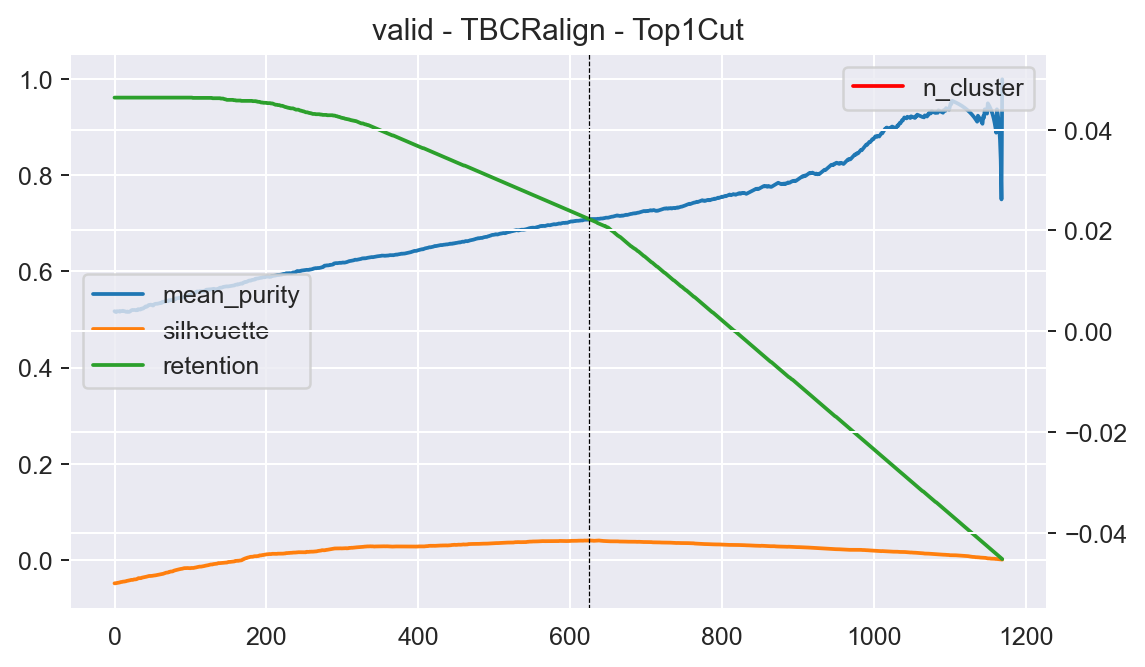

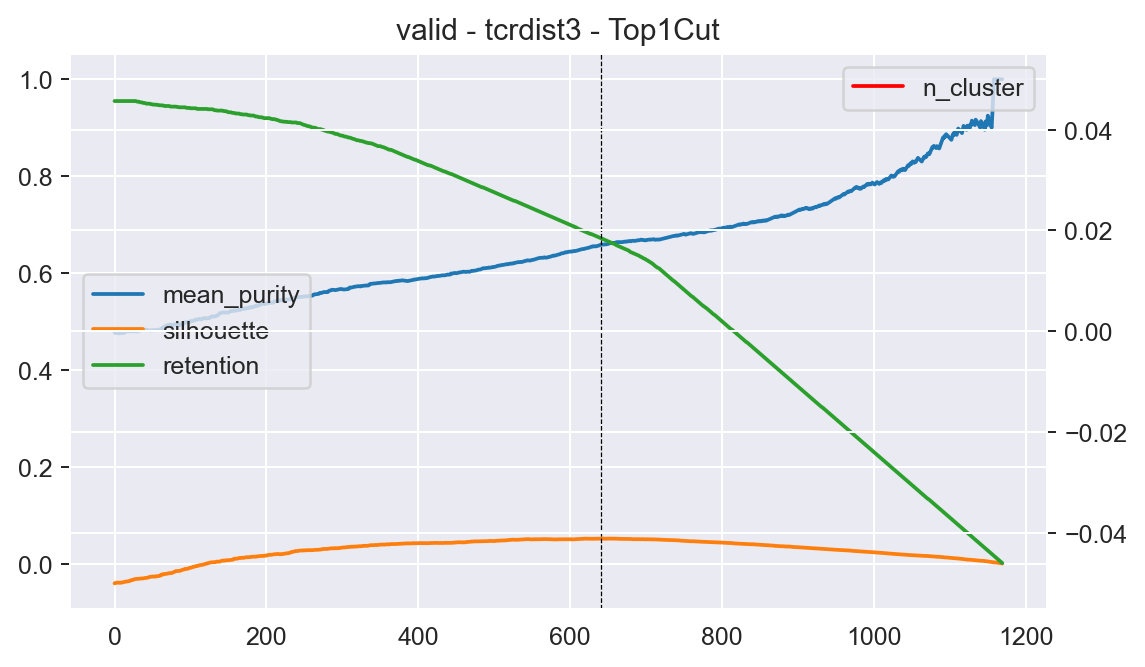

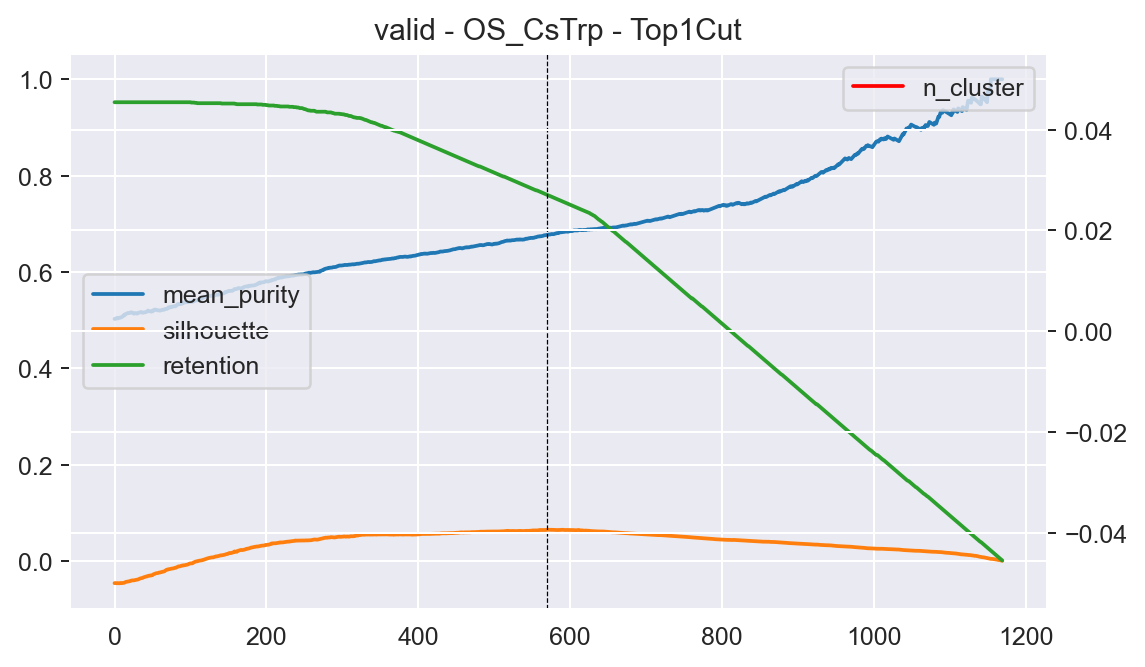

In [359]:
cut_df = pd.concat([tbcr_cut_df.assign(input_type='TBCRalign', 
                                       clustering='Top1Cut', 
                                       partition='valid'),
                    tcrdist_cut_df.assign(input_type='tcrdist3', 
                                          clustering='Top1Cut', 
                                          partition='valid'),
                    vae_cut_df.assign(input_type='OS_CsTrp', 
                                      clustering='Top1Cut', 
                                      partition='valid')])
cut_df['n_cluster']=np.nan
sns.set_palette('tab10', n_colors=4)
for f in cut_df.input_type.unique():
    clusterfuck(cut_df, f, 'Top1Cut', 'valid')

(<Figure size 1620x1620 with 1 Axes>,
 <Axes: xlabel='Retention', ylabel='Mean Purity'>)

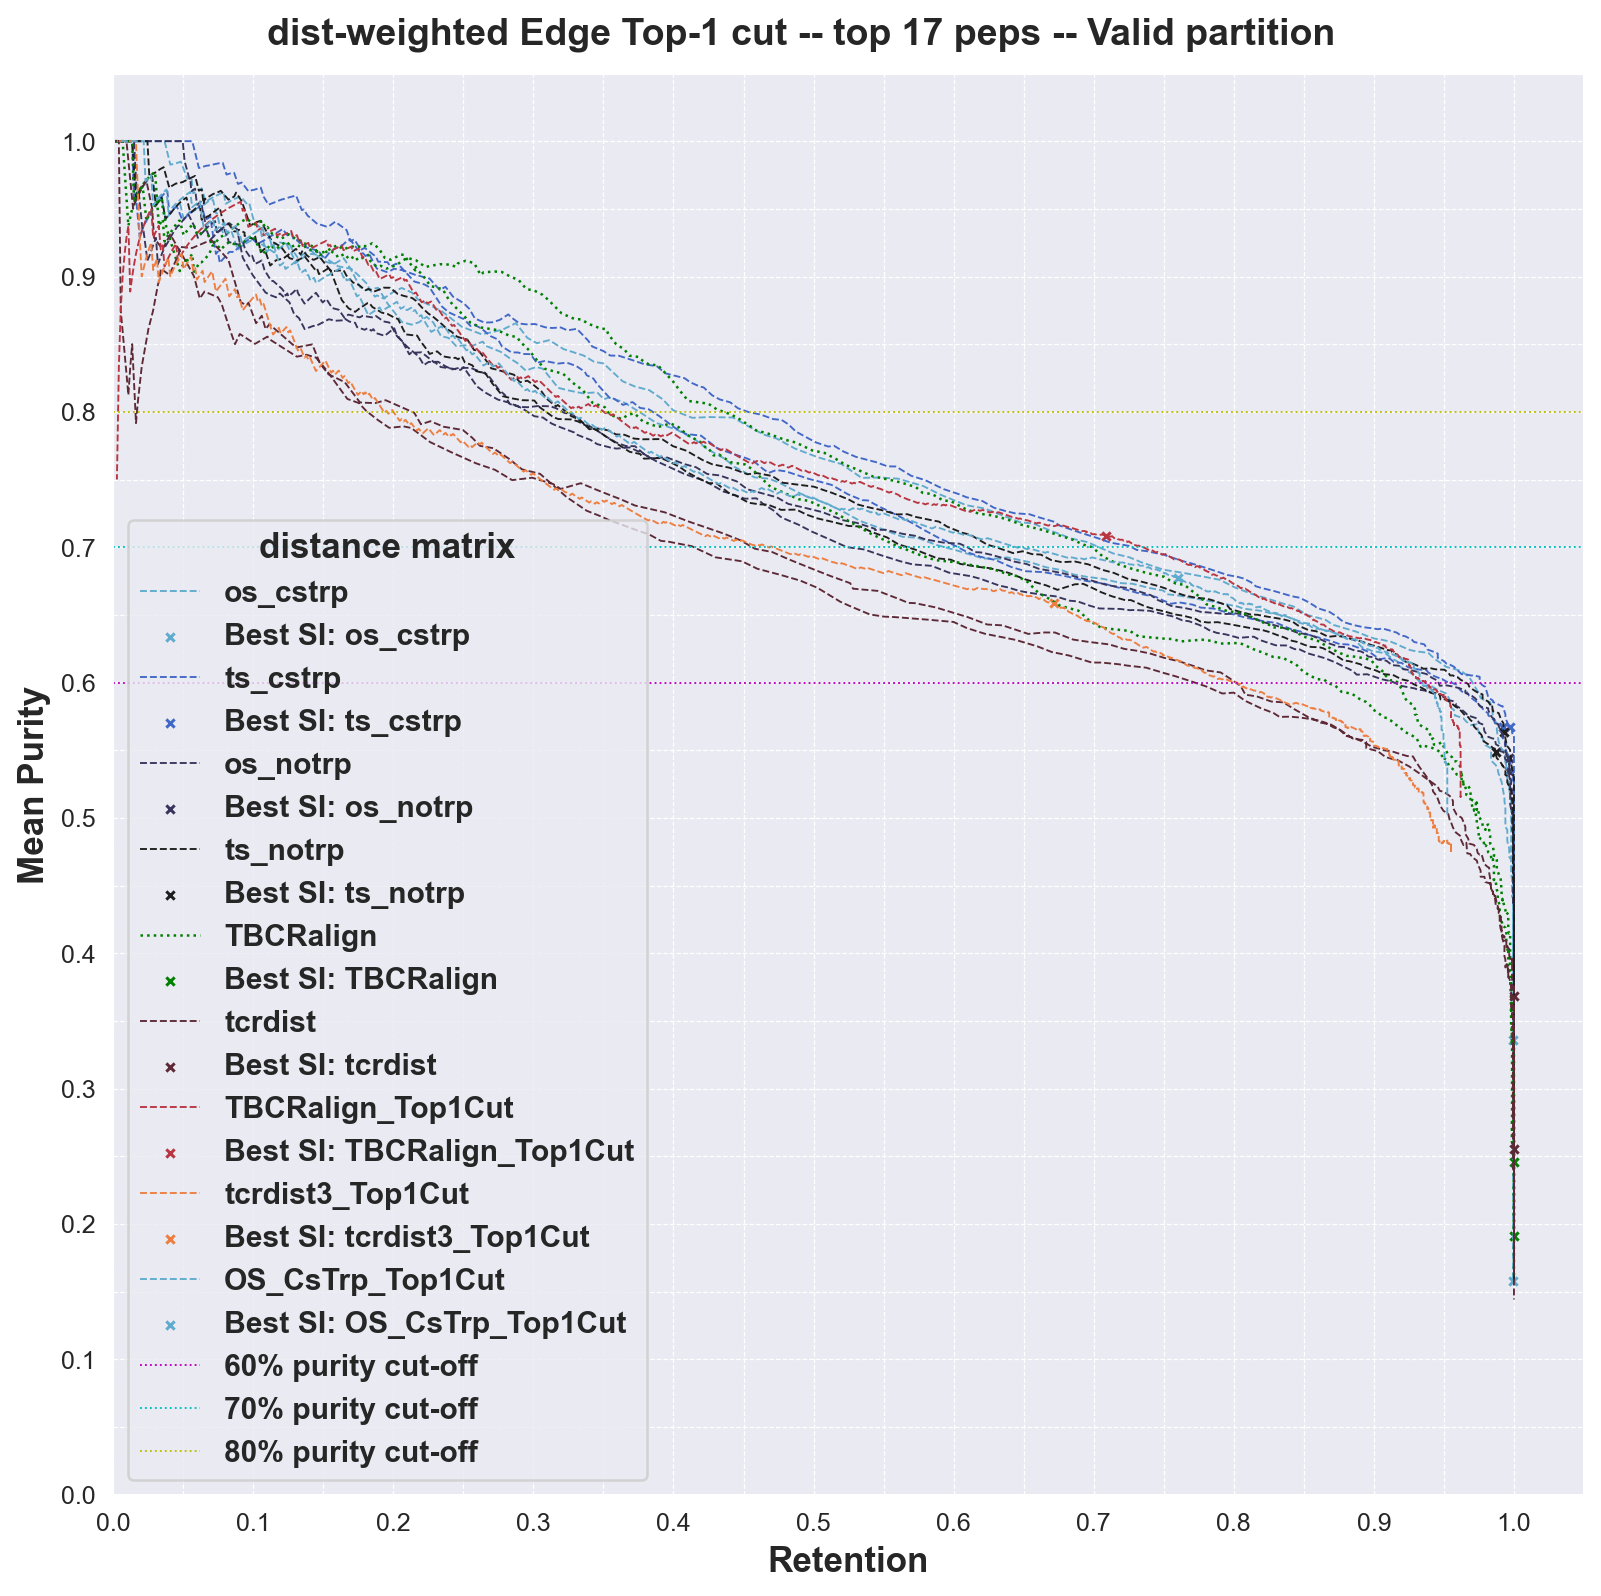

In [353]:

plot_retention_purities(pd.concat([macro_all_results, cut_df]), 
                        palette='icefire', 
                        title='dist-weighted Edge Top-1 cut -- top 17 peps -- Valid partition', add_best_silhouette=True)

In [366]:
import numpy as np

def find_true_maximum(scores, patience):
    """
    Efficiently finds the correct maximum score based on a patience-based early stopping criterion,
    handling NaN values in the scores array.

    Parameters:
    - scores: list or array-like, the sequence of scores for each iteration.
    - patience: int, the number of iterations to wait for an improvement before stopping.

    Returns:
    - max_score: float, the maximum score ignoring artificial spikes due to malfunctions.
    - max_index: int, the index of the detected maximum score.
    """
    max_score = float('-inf')  # Initialize to a very low value
    max_index = -1
    patience_counter = 0
    
    for i, score in enumerate(scores):
        # Skip NaN values
        if np.isnan(score):
            continue
        
        # If the current score improves the maximum, update max_score and reset patience
        if score > max_score:
            max_score = score
            max_index = i
            patience_counter = 0  # Reset patience because we found a new max
        
        # If the score does not improve, increase the patience counter
        else:
            patience_counter += 1
        
        # If patience limit is reached, break and return the best score seen so far
        if patience_counter >= patience:
            break
    
    # If no valid maximum was found (e.g., all NaNs), handle gracefully
    if max_index == -1:
        return None, None
    
    return max_score, max_index

In [374]:
find_true_maximum(macro_all_results.query('input_type=="os_cstrp" and partition=="valid"')['silhouette'].values, 50)

(0.12539175152778625, 152)

In [387]:
best_macro = []
for partition in macro_all_results.partition.unique():
    for clustering in macro_all_results.clustering.unique():
        for input_type in macro_all_results.input_type.unique():
            tmp = macro_all_results.query('input_type==@input_type and partition==@partition and clustering==@clustering').reset_index()
            best = find_true_maximum(tmp['silhouette'].values, 50)
            best_macro.append(tmp.iloc[best[1]])

In [391]:
best_micro = []
for partition in all_results.partition.unique():
    for clustering in all_results.clustering.unique():
        for input_type in all_results.input_type.unique():
            tmp = all_results.query('input_type==@input_type and partition==@partition and clustering==@clustering').reset_index()
            best = find_true_maximum(tmp['silhouette'].values, 50)
            best_micro.append(tmp.iloc[best[1]])

In [389]:
pd.DataFrame(best_macro)[['input_type','clustering','partition', 'min_cluster_size','mean_cluster_size', 'max_cluster_size','silhouette','retention', 'mean_purity']]

input_type clustering partition  min_cluster_size  mean_cluster_size  \
207   os_cstrp      Agglo      test               2.0           3.785340   
259   ts_cstrp      Agglo      test               2.0           3.479714   
264   os_notrp      Agglo      test               2.0           3.775773   
249   ts_notrp      Agglo      test               2.0           3.627500   
238  TBCRalign      Agglo      test               2.0           4.211480   
201    tcrdist      Agglo      test               2.0           4.153846   
152   os_cstrp      Agglo     valid               2.0           3.455847   
253   ts_cstrp      Agglo     valid               2.0           3.476190   
252   os_notrp      Agglo     valid               2.0           3.560976   
245   ts_notrp      Agglo     valid               2.0           3.762887   
219  TBCRalign      Agglo     valid               2.0           3.727273   
192    tcrdist      Agglo     valid               2.0           3.679245   

     max_cluster_size  silhouette  retention  mean_purity  
207              54.0    0.119040   0.983673     0.551193  
259              25.0    0.135875   0.991837     0.566985  
264              21.0    0.147601   0.996599     0.534765  
249              30.0    0.137700   0.987075     0.548550  
238              31.0    0.073556   0.948299     0.547482  
201              34.0    0.101964   0.955102     0.515407  
152              37.0    0.125392   0.984364     0.580656  
253              33.0    0.129514   0.992522     0.580801  
252              17.0    0.141346   0.992522     0.560767  
245              38.0    0.134387   0.992522     0.569792  
219              29.0    0.077956   0.919782     0.595162  
192              20.0    0.095054   0.927940     0.545357

In [392]:
pd.DataFrame(best_micro)[['input_type','clustering','partition', 'min_cluster_size','mean_cluster_size', 'max_cluster_size','silhouette','retention', 'mean_purity']]

input_type clustering partition  min_cluster_size  mean_cluster_size  \
175   os_cstrp      Agglo      test               2.0           2.768085   
233   ts_cstrp      Agglo      test               2.0           2.906250   
235   os_notrp      Agglo      test               2.0           2.978814   
228   ts_notrp      Agglo      test               2.0           3.128090   
204  TBCRalign      Agglo      test               2.0           2.985037   
169    tcrdist      Agglo      test               2.0           3.097015   
143   os_cstrp      Agglo     valid               2.0           3.096280   
226   ts_cstrp      Agglo     valid               2.0           2.903766   
227   os_notrp      Agglo     valid               2.0           3.000000   
217   ts_notrp      Agglo     valid               2.0           2.993534   
200  TBCRalign      Agglo     valid               2.0           3.141772   
157    tcrdist      Agglo     valid               2.0           2.944724   

     max_cluster_size  silhouette  retention  mean_purity  
175              21.0    0.133795   0.885034     0.631960  
233              18.0    0.144007   0.948980     0.602301  
235              11.0    0.158718   0.956463     0.586214  
228              20.0    0.151958   0.946939     0.591140  
204              31.0    0.100571   0.814286     0.624514  
169              13.0    0.113348   0.846939     0.574152  
143              37.0    0.132627   0.961931     0.608696  
226              33.0    0.134013   0.943576     0.622387  
227              14.0    0.155848   0.960571     0.595944  
217              38.0    0.148524   0.944256     0.609724  
200              25.0    0.102282   0.843644     0.638315  
157              14.0    0.113686   0.796737     0.603288

In [376]:
macro_all_results.loc[152]

threshold  n_cluster  n_singletons  n_cluster_over_70p  mean_purity  \
152    0.14326        395           462                 143     0.679779   
152    0.19014        419            23                  97     0.580656   
152    0.43654        195           975                 129     0.829573   
152    0.46144        239           871                 154     0.824885   
152    0.37892        222           942                 122     0.772834   
152    0.40284        269           816                 138     0.748575   
152    0.41865        250           845                 122     0.747270   
152    0.44488        302           716                 147     0.740117   
152    0.11611        275           724                 149     0.769622   
152  115.38277        398           336                 103     0.612081   
152    0.10576        201           914                 122     0.792833   
152  112.87174        398           386                 104     0.610958   

     min_purity  max_purity  mean_coherence  min_coherence  max_coherence  \
152    0.200000         1.0        0.115629       0.023153       0.142834   
152    0.181818         1.0        0.143644       0.083765       0.188712   
152    0.200000         1.0        0.338914       0.090424       0.435984   
152    0.333333         1.0        0.363498       0.078584       0.461064   
152    0.200000         1.0        0.289047       0.053530       0.378502   
152    0.250000         1.0        0.318060       0.047179       0.402679   
152    0.200000         1.0        0.327069       0.092254       0.417468   
152    0.333333         1.0        0.349793       0.064957       0.443148   
152    0.222222         1.0        0.096105       0.054052       0.116007   
152    0.200000         1.0       89.988721      45.000000     115.000000   
152    0.333333         1.0        0.087034       0.037073       0.105742   
152    0.200000         1.0       88.772785      40.000000     112.000000   

     ...  min_cluster_size  max_cluster_size  silhouette  ch_index  db_index  \
152  ...               2.0              14.0    0.076939  3.109945  0.880706   
152  ...               2.0              37.0    0.125392  3.588370  1.552877   
152  ...               2.0              10.0    0.040787  3.448262  0.591095   
152  ...               2.0              11.0    0.048143  3.400180  0.626863   
152  ...               2.0               8.0    0.051056  3.763027  0.590608   
152  ...               2.0               9.0    0.056774  3.691260  0.635288   
152  ...               2.0              11.0    0.054068  3.709947  0.624676   
152  ...               2.0              16.0    0.063541  3.632962  0.698159   
152  ...               2.0              20.0    0.044632  4.665059  0.903055   
152  ...               2.0              14.0    0.081463  5.341810  1.225330   
152  ...               2.0              10.0    0.031275  5.169779  0.749004   
152  ...               2.0              12.0    0.076115  5.168747  1.178993   

          ARI  retention  input_type clustering partition  
152  0.014309   0.685714    os_cstrp      Agglo      test  
152  0.041161   0.984364    os_cstrp      Agglo     valid  
152  0.007690   0.336735    ts_cstrp      Agglo      test  
152  0.009658   0.407886    ts_cstrp      Agglo     valid  
152  0.005476   0.359184    os_notrp      Agglo      test  
152  0.007364   0.445275    os_notrp      Agglo     valid  
152  0.008642   0.425170    ts_notrp      Agglo      test  
152  0.010289   0.513256    ts_notrp      Agglo     valid  
152  0.017262   0.507818   TBCRalign      Agglo     valid  
152  0.011104   0.771584     tcrdist      Agglo     valid  
152  0.009868   0.378231   TBCRalign      Agglo      test  
152  0.010821   0.737415     tcrdist      Agglo      test  

[12 rows x 21 columns]

# Cancer QVD vs KSA

## inits

In [98]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata

def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    df['Run']=metadata['Run']
    df['TSubtype'] = metadata['TSubtype']
    return df, metadata
    
def read_subtype(df, source, subtype):
    paths = df.query('TSource.str.contains(@source) and TSubtype.str.contains(@subtype)')['relpath'].values
    return pd.concat([read_ots_unique(x)[0] for x in paths]).drop_duplicates('tcr')

In [59]:
ebh = pd.read_csv('../data/OTS/metadata/cancer_eberhardt.csv')
ksa_paths = ebh.query('TSubtype.str.contains("ksa")')['relpath'].unique()
qvd_paths = ebh.query('TSubtype.str.contains("qvd")')['relpath'].unique()

In [99]:
# Two HPV-specific peptides tetramers : QVDYYGLYY (A0101), KSAIVTLTY (A01-01)
# and PD-1+ for the immune blockade pathway 
tmp = ebh.query('Author.str.contains("Eber") and TSubtype.str.contains("tetramer") and Subject in ["hpv15","hpv34", "hpv51", "hpv7"]')
tmp.groupby(['Subject','TSource', 'TSubtype', 'Treatment', 'CancerType']).agg(count=('n_seq','count'),
                                                                              avg_unique = ('n_unique', 'mean'),
                                                                              max_unique = ('n_unique', 'max'),
                                                                              min_unique = ('n_unique', 'min'))

count  \
Subject TSource               TSubtype     Treatment CancerType          
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc      1   
                              tetramer_qvd untreated hpv+_hnscc      1   
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 tetramer_qvd untreated hpv+_hnscc      3   
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 tetramer_ksa untreated hpv+_hnscc      3   

                                                                 avg_unique  \
Subject TSource               TSubtype     Treatment CancerType               
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc   14.000000   
                              tetramer_qvd untreated hpv+_hnscc   15.000000   
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc   13.666667   
                              tetramer_qvd untreated hpv+_hnscc   34.666667   
        tumor                 tetramer_qvd untreated hpv+_hnscc   26.000000   
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc    5.000000   
        tumor                 tetramer_ksa untreated hpv+_hnscc    3.666667   
                              tetramer_qvd untreated hpv+_hnscc    6.666667   
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc   19.000000   
                              tetramer_qvd untreated hpv+_hnscc   56.000000   
        tumor                 tetramer_ksa untreated hpv+_hnscc   17.333333   

                                                                 max_unique  \
Subject TSource               TSubtype     Treatment CancerType               
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc          14   
                              tetramer_qvd untreated hpv+_hnscc          15   
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          16   
                              tetramer_qvd untreated hpv+_hnscc          35   
        tumor                 tetramer_qvd untreated hpv+_hnscc          27   
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc           5   
        tumor                 tetramer_ksa untreated hpv+_hnscc           5   
                              tetramer_qvd untreated hpv+_hnscc           7   
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          21   
                              tetramer_qvd untreated hpv+_hnscc          57   
        tumor                 tetramer_ksa untreated hpv+_hnscc          18   

                                                                 min_unique  
Subject TSource               TSubtype     Treatment CancerType              
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc          14  
                              tetramer_qvd untreated hpv+_hnscc          15  
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          12  
                              tetramer_qvd untreated hpv+_hnscc          34  
        tumor                 tetramer_qvd untreated hpv+_hnscc          25  
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc           5  
        tumor                 tetramer_ksa untreated hpv+_hnscc           3  
                              tetramer_qvd untreated hpv+_hnscc           6  
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          17  
                              tetramer_qvd untreated hpv+_hnscc          55  
        tumor                 tetramer_ksa untreated hpv+_hnscc          17

In [122]:
hpv15 = ebh.query('Subject=="hpv15"')
hpv34 = ebh.query('Subject=="hpv34"')
hpv51 = ebh.query('Subject=="hpv51"')
hpv7 = ebh.query('Subject=="hpv7"')
hpv34_ksa = read_subtype(hpv34, "lymph", "ksa")
hpv34_qvd = read_subtype(hpv34, "lymph", "qvd")
hpv15_ksa = read_subtype(hpv15, "tumor", "ksa")
hpv15_qvd = read_subtype(hpv15, "tumor", "qvd")
hpv51_ksa = read_subtype(hpv51, "tumor", "ksa")
hpv51_qvd = read_subtype(hpv51, "tumor", "qvd")
hpv7_ksa = read_subtype(hpv7, "lymph", "ksa")
hpv7_qvd = read_subtype(hpv7, "lymph", "qvd")

hpv34 = pd.concat([hpv34_ksa.assign(index_col=[f'hpv34_ksa_{i:03}' for i in range(len(hpv34_ksa))]),
                   hpv34_qvd.assign(index_col=[f'hpv34_qvd_{i:03}' for i in range(len(hpv34_qvd))])]).drop_duplicates('tcr')
hpv15 = pd.concat([hpv15_ksa.assign(index_col=[f'hpv15_ksa_{i:03}' for i in range(len(hpv15_ksa))]),
                   hpv15_qvd.assign(index_col=[f'hpv15_qvd_{i:03}' for i in range(len(hpv15_qvd))])]).drop_duplicates('tcr')
hpv51 = pd.concat([hpv51_ksa.assign(index_col=[f'hpv51_ksa_{i:03}' for i in range(len(hpv51_ksa))]),
                   hpv51_qvd.assign(index_col=[f'hpv51_qvd_{i:03}' for i in range(len(hpv51_qvd))])]).drop_duplicates('tcr')
hpv7 = pd.concat([hpv7_ksa.assign(index_col=[f'hpv7_ksa_{i:03}' for i in range(len(hpv7_ksa))]),
                  hpv7_qvd.assign(index_col=[f'hpv7_qvd_{i:03}' for i in range(len(hpv7_qvd))])]).drop_duplicates('tcr')

In [124]:
%mkdir ../data/OTS/eberhardt_cancer
hpv34.to_csv('../data/OTS/eberhardt_cancer/hpv34_mixed_qvd_ksa.txt', index=False)
hpv15.to_csv('../data/OTS/eberhardt_cancer/hpv15_mixed_qvd_ksa.txt', index=False)
hpv51.to_csv('../data/OTS/eberhardt_cancer/hpv51_mixed_qvd_ksa.txt', index=False)
hpv7.to_csv('../data/OTS/eberhardt_cancer/hpv7_mixed_qvd_ksa.txt', index=False)

mkdir: ../data/OTS/eberhardt_cancer: File exists


In [134]:
%rm -r ../data/OTS/eberhardt_garner_mixed_subsampled/

In [148]:
%mkdir ../data/OTS/eberhardt_garner_mixed_subsampled/
tcrs = pd.concat([hpv7, hpv15, hpv34, hpv51]).tcr.unique()
g = garner.query('count==1 and tcr not in @tcrs')
g['TSubtype'] = 'healthy'
for seed in range(100):
    pd.concat([hpv7, g.sample(n=len(hpv7), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv7_garner_subsampled_seed_{seed:03}.txt')
    pd.concat([hpv15, g.sample(n=len(hpv15), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv15_garner_subsampled_seed_{seed:03}.txt')
    pd.concat([hpv34, g.sample(n=len(hpv34), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv34_garner_subsampled_seed_{seed:03}.txt')
    pd.concat([hpv51, g.sample(n=len(hpv51), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv51_garner_subsampled_seed_{seed:03}.txt')

mkdir: ../data/OTS/eberhardt_garner_mixed_subsampled/: File exists


## results 

# ?